
# Uma Rede neural Consegue Reproduzir uma série temporal do tipo $1/f^\beta$ atravez do seu espectro?



## For the Next


Pq a MLP não esta entrando os dados?

Criar função `universa_loss` para o `optuna`.



# Introduction

This code is the final initial version of the attempt to make different neural network architectures able to generalize and reproduce $1/f^\beta$ noise. In the format in which this code is found, it is possible to generate data of the type $1/f^\beta$, separate them into a test and validation set, and analyze the distribution of different values ​​of $\beta$s for different generated time series structures. And test the performance of different neural network architectures.

This version is being archived on GitHub for future use. Since, we are sending it to be optimized with a hyperparameter optimizer, [optuna](https://optuna.org/).

From this code, it is possible to make scientific conclusions relevant to the study of colored noise and deep learning. However, in an attempt to achieve better accuracy in the results, we will be migrating to a version in which such a hyperparameter optimizer will be tested.

Special thanks for this version go to Doctor R Sautter, a colleague, and friend to whom he made significant contributions to the design and development of neural network architectures.

# Librarys

In [1]:
#!pip install colorednoise
#!pip install optuna

import colorednoise as cn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import matplotlib.ticker as mtick

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import optuna

import seaborn as sns
from matplotlib.gridspec import GridSpec
import time
import datetime
import os 
import warnings
warnings.filterwarnings('ignore')
np.random.seed(55)
torch.manual_seed(55)
#sns.set_style('darkgrid')
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [ ]:
#If exist, create folder for saving figures
if not os.path.exists('figures'):
    os.makedirs('figures')

# Paramentes

In [45]:
colors = ['C0', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Functions

In [3]:
class const(nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input):
        return input # simply apply already implemented SiLU

In [52]:
def create_dataset(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  NORMALIZED DATASET BETEWENN -1 AND 1
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  # This function must 
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [], []
  data_test_X, data_test_Y   = [], []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    _,data_norm = norm(dataset_train[i:i + window_in + window_ou])
    data_train_X.append(data_norm[0:(window_in)])
    data_train_Y.append(data_norm[ window_in:window_in + window_ou])
    #print(len(data_train_X[i]))

    _,data_norm = norm(dataset_test[i:i + window_in + window_ou])
    data_test_X.append(data_norm[0:(window_in)])
    data_test_Y.append(data_norm[window_in:window_in + window_ou])
    #print((data_train_X).astype(float))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

def create_dataset2(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  NORMALIZED DATASET BETEWENN 0 AND 1
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  # This function must 
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [] , []
  data_test_X , data_test_Y  = [] , []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    _,data_norm = norm2(dataset_train[i:i + window_in + window_ou])
    data_train_X.append(data_norm[0:(window_in)])
    data_train_Y.append(data_norm[ window_in:window_in + window_ou])
    #print(len(data_train_X[i]))

    _,data_norm = norm2(dataset_test[i:i + window_in + window_ou])
    data_test_X.append(data_norm[0:(window_in)])
    data_test_Y.append(data_norm[window_in:window_in + window_ou])
    #print((data_train_X).astype(float))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)
def generate_data(size,win_in,win_ou,title='data.pt'):
  '''
  Create a Dataset in pytorch format and save it
  trainX[i] and trainY[i] are genereted from the same time serie 
  Normalized  between [-1,1].
  data[0] = whitenoise
  data[1] = pink noise
  data[2] = rednoise
  data[3] = Turbulence
  data[i][0] = trainX
  data[i][1] = trainY
  data[i][2] = train_testX
  data[i][3] = train_testY
  list = [0,1,2,3,4,5,6,7,8,9,10,11]
  if the window_in is equal to 3 anf window_ou equal to to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  data = [] #Empyty Vector
  betas = [0,1,2,5/3] #Values of Betas
  for i in range(len(betas)): #loop for alocate the tensot
    trainX, trainY          = dataset_test2(betas[i],size,win_in,win_ou)
    trainX_test,trainY_test = dataset_test2(betas[i],size,win_in,win_ou)
    
    data.append([trainX,trainY,trainX_test,trainY_test])
  torch.save(data, title) #Savig the file in .pt format
  return data

def skew(t):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**3,dim=1)

def kurtosis(t, fisher=True):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**4,dim=1) - fisher*3    

def param(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def param_2(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  #data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def norm(data):
  '''
  Normalize the dataframe from -1 to 1
  '''
  scaler = MinMaxScaler((-1,1))
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2


def norm2(data):
  '''
  Normaliza os dados entre 0 e 1
  '''
  scaler = MinMaxScaler()
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2  

def norm4(data):
  '''
  Normaliza os dados entre 0 e 1
  but return vectors in a single shape
  '''
  #scaler = MinMaxScaler()
  scaler = MinMaxScaler((-1,1))
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1) 
  data2 = np.reshape(data1,len(data1))
  return data2  

def norm5(data):
    """
    Normalize the input data between -1 and 1, while returning the vectors in a single shape
    """
    # Create the scaler object
    scaler = MinMaxScaler((-1,1))

    # Reshape the input data to have only one column
    data1 = data.view(-1, 1).float()

    # Normalize the data
    data1 = scaler.fit_transform(data1)

    # Reshape the normalized data back to a single vector
    data2 = data1.view(-1)

    return data2


##################
# PLOT FUNCTIONS #
##################


# def plot_psd(data,label='PSD',color='k',n_cut=None,n_cut_color = [None]):
#   '''
#   This functions will show the PSD representation for any time series
#   '''
#   ft = np.fft.fft(data)
#   #ft = np.fft.fft(y[0,:])
#   ft = np.real(ft*np.conj(ft))
#   freq = np.fft.fftfreq(len(ft))
#   seq = np.argsort(freq)
#   a,b = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
#   text = "{} {}f + {}".format(label,np.round(a,3),np.round(b,3))
#   #plota o psd
#   return plt.loglog(freq[seq],ft[seq],color=color,label=text)

def plot_psd(data,label='PSD',color='k',is_subplot = False,axis=None):
  '''
  This functions will show the PSD representation for any time series
  '''
  ft = np.fft.fft(data)
  ft = np.real(ft*np.conj(ft))
  freq = np.fft.fftfreq(len(ft))
  seq = np.argsort(freq)
  a,b = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
  text = "{} {}f + {}".format(label,np.round(a,3),np.round(b,3))
  #plota o psd
  if is_subplot:
    return freq[seq],ft[seq], a,b 
  else:
    return plt.loglog(freq[seq],ft[seq],color=color,label=text)  

def plot_color_psd(data,n_cut=1,colors=['C9','C8','C7','C6','C5','C4','C3','C2','C1','C0']):
    '''
    Plot the PSD of a time series with different colors
    '''
    x = []
    ft = np.fft.fft(data)
    ft = np.real(ft*np.conj(ft))
    freq = np.fft.fftfreq(len(ft))
    seq = np.argsort(freq)
    freq = freq[seq]
    ft = ft[seq]

    df = pd.DataFrame()
    df.insert(0,'freq',freq)
    df.insert(1,'ft',ft)

    for i in range(n_cut): x.append(len(data)**(-(i+1)/n_cut))
    for i in reversed(range(n_cut)):
        plt.loglog(df['freq'][(df['freq'] >= x[i])],df['ft'][(df['freq'] >= x[i])])#,lw=1.0000001*n_cut-i)#,label=(i,x[i]))
        plt.axvline(x=x[i],color='gray',linestyle='--',label=(i,x[i]))

def plot_test(x_,y_,color_x='C0',color_y='C1'):
  '''
  Plot two time series in sequence
  '''
  empty = np.empty_like(x_)
  empty[:] = np.nan
  y2 = np.append(empty,y_)
  plt.plot(x_,label='Input' ,color = color_x)
  plt.plot(y2,label='Target',color = color_y) 


def create_dataframe(data_x,data_y,data_val_x=None,data_val_y =None,len_future=0):
    '''
     ########### CREATING DATAFRAME ###############
    #Create A inicial Dataframe with this size    
    #data_x = list(test_input_clone[0].detach().numpy().copy())
    #data_y = list(test_target_clone[0].detach().numpy().copy())
    '''
    l = DBeta()
    #Is data_y larger than data_x or vice-versa?
    if len(data_y) > len(data_x):  
      for index in range(len(data_y) - len(data_x)):  data_x.append(np.nan)
    elif len(data_x) > len(data_y):
      for index in range(len(data_x) - len(data_y)):  data_y.append(np.nan)
    #Is x and y smaller then the future predicts?
    if len_future > len(data_x):
      for index in range(len_future - len(data_x)): data_x.append(np.nan)
    if len_future > len(data_y):
      for index in range(len_future - len(data_y)): data_y.append(np.nan)
    #Create a Dataframe
    df = pd.DataFrame()
    df.insert(0,'trainX',data_x)
    df.insert(1,'trainY',data_y)
    df.insert(2,'input_GNI',np.random.rand(len(data_x)))
    
    if data_val_x is not None:
      ori_betas_x,ori_betas_y = [],[]
      #for i_1 in range(len(data_val_x)): ori_betas_x.append(plot_psd(norm4(data_val_x[i_1]),is_subplot=True)[2])
      #for i_2 in range(len(data_val_y)): ori_betas_y.append(plot_psd(norm4(data_val_y[i_2]),is_subplot=True)[2])

      for i_1 in range(len(data_val_x)):
          x = torch.tensor(np.resize(data_val_x[i_1],(1,data_val_x[i_1].shape[0])))
          ax = l.beta_mono(x).detach().numpy().item()
          ori_betas_x.append(ax) 
      for i_2 in range(len(data_val_y)):
          y = torch.tensor(np.resize(data_val_y[i_2],(1,data_val_y[i_2].shape[0])))
          ay = l.beta_mono(y).detach().numpy().item()
          ori_betas_y.append(ay)
      # y = torch.tensor(np.resize(data_val_y,(1,data_val_y.shape[0])))
      # ax = l.beta_mono(x).detach().numpy().item()
      # ay = l.beta_mono(y).detach().numpy().item()
      # for i_1 in range(len(data_val_x)): ori_betas_x.append(ax)
      # for i_2 in range(len(data_val_y)): ori_betas_y.append(ay)
      
      for index in range(len(data_x) - len(ori_betas_x)): ori_betas_x.append(np.nan)
      for index in range(len(data_x) - len(ori_betas_y)): ori_betas_y.append(np.nan)

      df.insert(3,'ori_betas_x',list(ori_betas_x))
      df.insert(4,'ori_betas_y',list(ori_betas_y))
    
    
    empty = np.empty_like(data_x)
    empty[:] = np.nan
    df.insert(len(df.columns),'loss_train',empty)
    df.insert(len(df.columns),'loss_valid',empty)
    df.insert(len(df.columns),'time',empty)
    
    return df


def append_dataframe(df,out,fut,out_betas,fut_betas,i):
  '''
  Function for append the new coluns in the traingloop
  '''
  out = list(out)
  fut = list(fut)
  out_betas = list(out_betas)
  fut_betas = list(fut_betas)
  len_data = len(df)
  #is the output smaller then the df numer of lines?  
  if len(out) < len_data:  
    for index_1 in range(len_data - len(out)):    out.append(np.nan)
  #is the output smaller then the df numer of lines?
  if len(fut) < len_data:  
    for index_2 in range(len_data - len(fut)):    fut.append(np.nan)
  #is the output smaller then the df numer of lines?
  if len(out_betas) < len_data:
    for index_3 in range(len_data - len(out_betas)):    out_betas.append(np.nan)
  #is the output smaller then the df numer of lines?
  if len(fut_betas) < len_data:
    for index_4 in range(len_data - len(fut_betas)):    fut_betas.append(np.nan)
  df.insert(len(df.columns),f'out{i+1}',out)
  df.insert(len(df.columns),f'fut{i+1}',fut)
  df.insert(len(df.columns),f'out_betas{i+1}',out_betas)
  df.insert(len(df.columns),f'fut_betas{i+1}',fut_betas)



# def plot_results(x,y,z,w,shift_1=0,epoch=0):
#   '''
#   One single function to plot all the results
#   '''
#   plt.figure(figsize=(15,6))
#   plt.suptitle(f'Results for Epoch {epoch+1}',  y=1.00, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
#   gs = GridSpec(1,2,width_ratios=[2,1])

#   plt.subplot(gs[0,0])
#   plt.title("Time Series")
#   plt.xlabel("x")
#   plt.ylabel("y")

#   shift_2 = len(x) + shift_1
#   shift_3 = len(y) + shift_2
#   plt.plot(np.arange(shift_1,shift_1+len(x)), x, color='C0',      linewidth=1.0,label='Input')            
#   plt.plot(np.arange(shift_2,shift_2+len(y)), y, color='C1',      label='Target')
#   plt.plot(np.arange(shift_2,shift_2+len(z)), z, color = 'brown', linewidth=1.0,label='Model Output')
#   plt.plot(np.arange(shift_3,shift_3+len(w)), w, color = 'green', linewidth=1.0,label='Future')
#   plt.axvline(shift_3,ls='--')
#   plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
#            ncol=4, fancybox=True, shadow=True)#,prop={'size': 15}) 

#   plt.subplot (gs[0,1])
#   plot_psd(z,'Expected','brown')
#   plot_psd(w,'Future','green')
#   plot_psd(y,'Output','C1')
#   plt.title('Power Spectrum Density')
#   plt.xlabel("f (Frequency)")
#   plt.ylabel("Energy (PSD)")
#   plt.tight_layout()
#   for k in range(n_cut): plt.axvline(x=(len(x)**(-(k+1)/n_cut)),color='r',ls='--')
#   plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
#            ncol=1, fancybox=True, shadow=True)#,prop={'size': 15}) 

#   #plt.savefig("predict%d.png"%i, dpi=200)
#   plt.show()
#   plt.close()


# def plot_results(y,z,w,ay,az,aw,size_x=10,size_y=10,model = None,title = None):
#   '''
#   One single function to plot all the results
#   '''
#   if model == None: model = ''
#   #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(size_x,size_y))
#   fig.subplots_adjust(hspace=0.3)
#   #fig.suptitle(f'{title}',  y=1.00, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)

#   #x, y, z, w , ay, by, az, bz, aw, bw, score = time_series(models[i], betas[j], 'usuario',gni,trials[i][j])        
#   # Original Signal
#   axs[0,0].plot(np.arange(len(y)), y, color = 'k',label='Target')
#   axs[0,0].set_ylabel(f'Test', fontsize = 15)

#   axs[0,1].loglog(ay[0],ay[1], color = 'k',label=ay[2])#,linewidth=linewidth)     
#   axs[0,1].legend()
#   axs[0,1].set_ylim(1e-4,1e5)
#   # Validation Signal
#   axs[1,0].plot(np.arange(len(z)), z, color = 'C0')
#   axs[1,0].set_title(f'$\\Delta \\beta_1$ = {az[2]-ay[2]:.5f}',y=0.99,x=1.1, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
  
#   axs[1,1].loglog(az[0],az[1], color = 'C0',label= "{} {}f + {}".format('PSD',np.round(az[2],3),np.round(az[3],3)))#,linewidth=linewidth)
#   axs[1,1].legend()
#   axs[1,1].set_ylim(1e-4,1e5)
#   # Free Signal
#   axs[2,0].plot(np.arange(len(w)), w, color = 'C1')
#   axs[2,0].set_title(f'$\\Delta \\beta_2$ = {az[2]-aw[2]:.5f}',y=0.99,x=1.1, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
  
#   axs[2,1].loglog(aw[0],aw[1], color = 'C1',label= "{} {}f + {}".format('PSD',np.round(aw[2],3),np.round(aw[3],3)))#,linewidth=linewidth)
#   axs[2,1].legend()
#   axs[2,1].set_ylim(1e-4,1e5)
#   axs[1,0].set_ylabel(f'{model}\n     Free                      Validation', y = -.1, fontsize = 15)
#   axs[1,1].legend()


def plot_results2(y,z,w,ay,az,aw,ori_betas,out_betas,fut_betas,size_x=10,size_y=10,model_title = None,sup_title = None,beta=2):
  '''
  One single function to plot all the results
  '''
  models_color = ['black','magenta','red','blue']
  if model_title == None: model_title = ''
  #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(size_x,size_y))
  
  fig = plt.figure(figsize=(10,10))
  gs = GridSpec(4, 2)

  fig.suptitle(f'{sup_title}',  y=.90, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)

  # Original Signal
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(np.arange(len(y)), y, color = models_color[beta],label=f'{beta}')
  ax1.set_ylabel(f'Test', fontsize = 15)
  #ax1.legend()
  
  ax2 = fig.add_subplot(gs[0, 1])
  ax2.loglog(ay[0],ay[1], color = models_color[beta],label= "{} {}f + {}".format('PSD',np.round(ay[2],3),np.round(ay[3],3)))
  ax2.legend()
  ax2.set_ylim(1e-4,1e5)
  
  # Validation Signal
  ax3 = fig.add_subplot(gs[1, 0])
  ax3.plot(np.arange(len(z)), z, color = 'C0')
  #ax3.set_title(f'$\\Delta \\beta_1$ = {az[2]-ay[2]:.5f}',y=0.99,x=1.1, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
  ax3.set_ylabel(f'{model_title}\n     Free                      Validation', y = -.1, fontsize = 15)

  ax4 = fig.add_subplot(gs[1,1])
  ax4.loglog(az[0],az[1], color = 'C0',label= "{} {}f + {}".format('PSD',np.round(az[2],3),np.round(az[3],3)))#,linewidth=linewidth)
  ax4.legend()
  ax4.set_ylim(1e-4,1e5)
  ax4.legend()
  # Free Signal
  ax5 = fig.add_subplot(gs[2,0])
  ax5.plot(np.arange(len(w)), w, color = 'C1')
  #ax5.set_title(f'$\\Delta \\beta_2$ = {az[2]-aw[2]:.5f}',y=0.99,x=1.1, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
  
  #Future prediction
  ax6 = fig.add_subplot(gs[2, 1])
  ax6.loglog(aw[0],aw[1], color = 'C1',label= "{} {}f + {}".format('PSD',np.round(aw[2],3),np.round(aw[3],3)))#,linewidth=linewidth)
  ax6.legend()
  ax6.set_ylim(1e-4,1e5)

  beta_t, beta_v,  beta_o= round(np.mean(out_betas),4), round(np.mean(fut_betas),4),round(np.mean(ori_betas),4)
  delta_beta_t = round(abs(np.mean(ori_betas)-np.mean(out_betas)),4)
  delta_beta_v = round(abs(np.mean(ori_betas)-np.mean(fut_betas)),4)
      
  ax7 = fig.add_subplot(gs[3, :])
  #ax7.set_title(f'$\\beta$ = {beta}\n$\\Delta \\beta_t$ = {delta_beta_t} - $\\Delta \\beta_v$ = {delta_beta_v}\n{title}')
  ax7.hist(out_betas,bins = 20,label = f'out {beta_t}')
  ax7.hist(fut_betas,bins = 20,label = f'fut {beta_v}')
  ax7.hist(ori_betas,bins = 20,label = f'ori {beta_o}' ,color= models_color[beta])
  ax7.axvline(x=-beta,color='purple',label = f'beta {beta}')
  ax7.axvline(x=beta_t,color='green',linestyle = '--')
  ax7.axvline(x=beta_v,color='blue' ,linestyle = '--')
  ax7.axvline(x=beta_o,color='gray',linestyle = '--')
  ax7.set_ylabel('Frequency',fontsize = 15)
  ax7.set_xlabel('$\\beta$',fontsize = 15)
  ax7.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),ncol=4, fancybox=True, shadow=True)#,prop={'size': 15}) 

  
def plot_results3(y,z,w,ay,az,aw,ori_betas,out_betas,fut_betas,size_x=10,size_y=10,model_title = None,sup_title = None,beta=2):
  '''
  One single function to plot all the results
  '''
  models_color = ['black','magenta','red','blue']
  if model_title == None: model_title = ''
  #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(size_x,size_y))
  
  import matplotlib.pyplot as plt
  import numpy as np
  from scipy.stats import gaussian_kde
  '''
  One single function to plot all the results
  '''
  models_color = ['black','magenta','red','blue']

  #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(size_x,size_y))
  
  fig = plt.figure(figsize=(10,10))
  gs = GridSpec(4, 2)

  fig.suptitle(f'{sup_title}',  y=.90, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
  #Trial = {trial}
  # Original Signal
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(np.arange(len(y)), y, color = models_color[beta],label=f'{beta}')
  ax1.set_ylabel(f'Test', fontsize = 15)
  #ax1.legend()
  
  ax2 = fig.add_subplot(gs[0, 1])
  ax2.loglog(ay[0],ay[1], color = models_color[beta],label= "{} {}f + {}".format('PSD',np.round(ay[2],3),np.round(ay[3],3)))
  ax2.legend()
  ax2.set_ylim(1e-4,1e5)
  
  # Validation Signal
  ax3 = fig.add_subplot(gs[1, 0])
  ax3.plot(np.arange(len(z)), z, color = 'C0')
  ax3.set_ylabel(f'{model_title}\n     Free                      Validation', y = -.1, fontsize = 15)

  ax4 = fig.add_subplot(gs[1,1])
  ax4.loglog(az[0],az[1], color = 'C0',label= "{} {}f + {}".format('PSD',np.round(az[2],3),np.round(az[3],3)))#,linewidth=linewidth)
  ax4.legend()
  ax4.set_ylim(1e-4,1e5)
  ax4.legend()
  # Free Signal
  ax5 = fig.add_subplot(gs[2,0])
  ax5.plot(np.arange(len(w)), w, color = 'C1')
  
  #Future prediction
  ax6 = fig.add_subplot(gs[2, 1])
  ax6.loglog(aw[0],aw[1], color = 'C1',label= "{} {}f + {}".format('PSD',np.round(aw[2],3),np.round(aw[3],3)))#,linewidth=linewidth)
  ax6.legend()
  ax6.set_ylim(1e-4,1e5)

  beta_t, beta_v,  beta_o= round(np.mean(out_betas),4), round(np.mean(fut_betas),4),round(np.mean(ori_betas),4)
  delta_beta_t = round(abs(np.mean(ori_betas)-np.mean(out_betas)),4)
  delta_beta_v = round(abs(np.mean(ori_betas)-np.mean(fut_betas)),4)
      
  ax7 = fig.add_subplot(gs[3, :])

  df_plot = pd.DataFrame({'Test':ori_betas,'Validation':out_betas,'Future':fut_betas})
  sns.violinplot(data=df_plot,palette=[models_color[beta],colors[0],colors[1]],cut=0,inner='quartile',scale='width',width=0.8,linewidth=1.5,ax=ax7)
  beta_especial = '5/3'

  ax7.set_xlabel(f'$\\Delta \\beta_t$ = {delta_beta_t} - $\\Delta \\beta_v$ = {delta_beta_v}')
  ax7.set_ylabel('Violin Plot',fontsize = 15)
  # if savefig == True: 
  #   if fig_pdf == True:
  #     os.chdir('/home/barauna/Documentos/P1_RNN/Results/')
  #     fig.savefig(f'best_model_beta_{beta}.pdf',bbox_inches='tight',dpi=300)
  #   else:
  #     if not os.path.exists('figures'):  os.mkdir('figures')
  #     fig.savefig('figures/Trial_{:03d}.png'.format(trial)) #Getting the 3 values 
  # if showfig == True: plt.show()
  # plt.close()  
  
  
    #axs[2*i+1 ,0].set_ylabel(f'{models[i]}\nFree             Validation', y = -.1, fontsize = fontsize)


def plot_loss(train,valid,title='Loss Metrics'):
  '''
  Plot Loss metrics
  '''
  plt.figure(figsize=(15,6))
  plt.title(title)
  plt.plot(train,label='Train')
  plt.plot(valid,label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()


def dt(t0,t1):
  '''
  Print Time Interval
  '''
  dt = t1-t0
  if dt < 60:           dtf = str(round(dt,3))+' s'
  elif 3600 > dt > 60:  dtf = str(round(dt/60,3))+' min'
  elif dt > 3600:       dtf = str(round(dt/3600,3))+' hours'
  return dtf  


#Clean Bad seteces
def clean_results(file_input, df_output = 'result.csv',best_model = True):
    '''
    The output files runing in a HPC extract a lot of warning.
    This warnings is provide by the randow choices that some times get nan values
    For this reason the output.txt file need do be clean to be analysed
    #######
    This code extract usefull information for the original output file and print the value of the best trial case
    If the output file come with new 'bad sentences' fell free do fill the `bad_sentence` vector with tham
    '''
    file_output = 'CLEAR_'+file_input
    #Extract the Best trial result
    with open(file_input, "r") as file: 
        lines = file.readlines()
        last_line = lines[-2] #
    result = last_line[12:200]
    #Print the Best trial value
    for i in range(len(lines)-2):
        if lines[i].find(result) != -1: index = i
    best_trial = lines[index][37:46]
    #https://stackoverflow.com/questions/11968998/read-lines-from-one-file-and-write-to-another-file-but-remove-lines-that-contain
    bad_sentences = ["/home/barauna/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered",
                "/home/barauna/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered",
                "  data_min = np.nanmin(X, axis=0)",
                "/home/barauna/anaconda3/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.",
                "  warnings.warn(",
                "[32m[I 2022-12-09 15:47:21,401] [0m A new study created in memory with name: no-name-4c3905de-7efe-42f5-8327-c1e279438960[0m",
                "  data_max = np.nanmax(X, axis=0)",
                "failed",
                "A new study created in memory with name",
                "Number of finished trials",
                "/home/luan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:46",
                "Email Sent"]
    with open(file_input) as oldfile, open(file_output, 'w') as newfile:
        for line in oldfile:
            if not any(bad_sentences in line for bad_sentences in bad_sentences):
                newfile.write(line)
                 
    f = open(file_output)
    lines = f.readlines()
    f.close()
    f = open(file_output, 'w')
    for line in lines:
        f.write(line[37:].split("}", 1)[0]+"}\n")
    f.close()

    dic = {}
    dfs = []
    #Create a list of dictionaries
    for i in range(len(lines)-1):
        dic.update({'Trial':lines[i].split('Trial ')[1].split(' finished')[0]})
        dic.update({'Score':lines[i].split('value: ')[1].split(' and parameters')[0]})
        a = lines[i].split('{')[1].split('}')[0].split(', ')
        for j in range(len(a)):
            b = a[j].split(': ')
            dic.update({str(b[0][1:-1]):b[1]})
        #Apeend the dictionary to a list of dictionaries into a dataframe    
        dfs.append(pd.DataFrame(dic, index=[0]))
    #Concatenate the list of dataframes into a dataframe
    df = pd.concat(dfs)    
    #Change the type of the columns
    df['Trial'] = df['Trial'].astype(int)
    df = df.sort_values(by=['Trial'])
    df['Score'] = df['Score'].astype(float)
    df['n_layers'] = df['n_layers'].astype(int)
    df['n_cut'] = df['n_cut'].astype(int)
    for i in range(max(df['n_layers'])):
        df['hidden_layers'+str(i)] = df['hidden_layers'+str(i)].astype(float)
        df['dropout'+str(i)] = df['dropout'+str(i)].astype(float)
    
    if best_model: print(df.iloc[df['Score'].idxmin()])
    return df.to_csv(df_output, index=False)

def plot_summary(df):
    plt.subplot(2,2,1)
    plt.title('Optimiser')
    sns.histplot(df['optimiser'])

    plt.subplot(2,2,2)
    plt.title('Number of layers')
    sns.histplot(df['n_layers'].astype(str))

    plt.subplot(2,2,3)
    plt.title('Neurons per layer')
    for i in range(1,max(df['n_layers'])+1): 
        plt.plot(df['hidden_layers'+str(i)].values,label=f'Layer {i}')
    plt.legend()

    plt.subplot(2,2,4)
    plt.title('Dropout')
    for i in range(1,max(df['n_layers'])+1): 
        plt.plot(df['dropout'+str(i)].values)

def report(CODE_NAME,CPU=None):
  # Creating the respective object along with the gmail login and port number
  from smtplib import SMTP
  import socket
  if CPU: 
     pass
  else: CPU = str(socket.gethostname())

  email_mine  = "fismatcom.py1@gmail.com"
  password_mine  = "kuwfpepwzukdydwd"
  email1 = "luanorion@hotmail.com"
  #email2 = "luanorion1@gmail.com"
  CODE_NAME = str(CODE_NAME)

  smtp_port = SMTP("smtp.gmail.com", 587)# Establishing a connection to the SMTP server with Transport Layer Security (TLS) mode
  smtp_port.ehlo()# Informing the client to establish a secure connection, either to a TLS or SSL
  smtp_port.starttls()# Logging into your account
  smtp_port.login(email_mine , password_mine)

  # Creating the contents of the email
  subject = f"[{CPU}'s Report] {CODE_NAME} has Finish"
  body = f"\nCongratulations \n\n{CODE_NAME}\n\nHas finished"
  final_message = f"Subject: {subject} \n \n {body}"

  # Creating the list of email addresses
  address_list = [email1]#, email2]
  smtp_port.sendmail(email_mine, address_list, final_message)
  print("Email Sent")
  smtp_port.quit()        

In [5]:
## Functions for Data Analize
def dataset_test(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  Create a data 1 sets for teste the spectra time series
  Here the data_set will be splited like in create_dataset but without test data
  All the data will be splited in two type of series.
  '''
  data_train_X, data_train_Y = [], []
  for i in range(0,len(dataset)-window_in-window_ou+1,strid):
    data_train_X.append(norm4(dataset[i:(i+window_in)]))
    data_train_Y.append(norm4(dataset[i + window_in:i + window_in + window_ou]))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

#Data Set 03 - TrainX and TrainY from a single Series

def dataset_test2(beta,n_series, len_trainX=10,len_trainY=10,isTensor=True):
  '''
  We create a time serie and split it in trainX and trainY
  '''
  data_train_X, data_train_Y = [], []
  for i in range(n_series):
    dataset = norm4(cn.powerlaw_psd_gaussian(beta, len_trainX+len_trainY))
    data_train_X.append(dataset[:len_trainX])
    data_train_Y.append(dataset[len_trainX:])
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)    


## Δβ - Diferent Index


A biblioteca pytorch possui as funções de transformada rápida de fourier (fft),respectivo conjunto de frequência (fftfreq) e logarítmo implementada já a nível vetorizado.

No entanto, foi necessário implementar manualmente o ajuste linear para medir o beta, uma boa referência (com o método dos minimos quadrados) é:

http://195.134.76.37/applets/AppletPoly/Appl_Poly2.html

In [6]:
class DBeta2(nn.Module):
  def __init__(self):
    super(DBeta2, self).__init__();

  def beta(self,vet):
    ft = torch.fft.fft(vet,dim =1)
    ft = ft*torch.conj(ft)
    psd = torch.real(ft)
    freq = torch.fft.fftfreq(vet.size(dim=1))
    freq = freq.repeat(psd.size(dim=0),1)

    # remove frequencias negativas e zero
    freq = freq[:,1:vet.size(dim=1)//2]
    psd = psd[:,1:vet.size(dim=1)//2]
    #passa para escala log
    freq = torch.log(freq)
    psd = torch.log(psd)

    # calcula o angulo do ajuste linear
    b = (psd.size(dim=1)*torch.sum(psd*freq,dim=1)-torch.sum(psd,dim=1)*torch.sum(freq,dim=1))/(psd.size(dim=1)*torch.sum(freq**2,dim=1) - (torch.sum(freq,dim=1)**2) )
    return b
    
  def forward(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

  def __call__(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

## Δβλ - Separete the PSD in `n_cut` sizes
This function will return the value of the $\beta$ index from a linearized time series or, the values if de `n_cut` is larger then $1$.

$$ f_1 = \sqrt{\beta_1} $$

In [7]:
class DBeta(nn.Module):
  def __init__(self,n_cut=1, low_freq_cut=0 ,high_freq_cut=0 ):
    super(DBeta, self).__init__();
    '''
    >>>>> DELTA BETA funcion <<<<<<
    This function will calculate the power law index beta in the power spectrum
    space for a given time series and  split it from a frequency space in n_cut times.
    You can also select what kind of part of the frequency could NOT been calulated
    Ignoring low and high frequncys.

    n_cut        - is the number of cuted betas
    low_freq_cut - Is the ignored first betas
    high_freq_cut - its the ignored last betas
    '''         
    self.n_cut = n_cut                                    #Save n_cut numbers in the object
    self.high_freq_cut = high_freq_cut                    #How many parts from higth frequency will be ignored
    self.low_freq_cut = low_freq_cut                      #How many parts from low frequency will be ignored
  def psd(self,vet):                
      ft = torch.fft.fft(vet,dim =1)                      #ft will computes the one dimensional discrete Fourier transform of input.
      ft = ft*torch.conj(ft)                              #Extract the conjugated complex from the tranformation
      psd = torch.real(ft)                                #Take only the real values from the transformation
      freq = torch.fft.fftfreq(vet.size(dim=1))           #freq will computes the discrete Fourier Transform sample frequencies for a signal of size n 
      freq = freq.repeat(psd.size(dim=0),1)               #Repeat the freq vector for the psd size
      freq = freq[:,1:vet.size(dim=1)//2]                 #Freq will be cutted in half
      psd = psd[:,1:vet.size(dim=1)//2]                   #PSD will be cutted in half
      return psd, freq   

  def beta_mono(self,vet):
    ft = torch.fft.fft(vet,dim =1)
    ft = ft*torch.conj(ft)
    psd = torch.real(ft)
    freq = torch.fft.fftfreq(vet.size(dim=1))
    freq = freq.repeat(psd.size(dim=0),1)
    # remove frequencias negativas e zero
    freq = freq[:,1:vet.size(dim=1)//2]
    psd = psd[:,1:vet.size(dim=1)//2]
    #passa para escala log
    freq = torch.log(freq)
    psd = torch.log(psd)
    # calcula o angulo do ajuste linear
    b = (psd.size(dim=1)*torch.sum(psd*freq,dim=1)-torch.sum(psd,dim=1)*torch.sum(freq,dim=1))/(psd.size(dim=1)*torch.sum(freq**2,dim=1) - (torch.sum(freq,dim=1)**2) )
    return b        
           
  def beta(self,vet):                                     #n_cut number of cut for the series
    n_cut = self.n_cut                                    
    low_freq_cut = self.low_freq_cut                      #Setting the low freqs
    high_freq_cut = self.high_freq_cut                    #Setting hig_freq_cut 
    psd,freq = self.psd(vet)                              #generating the PSD and FREQ returned by the psd function
    beta= torch.zeros(vet.size(0), n_cut)                 #Alocating a lot of zeros in the beta vector wwith vec size
    for i in range(low_freq_cut,n_cut-high_freq_cut):     #For each cut
      for j in range(vet.size(0)):                        #For each serie
        int_min,int_max = len(vet)**(-(i+1)/n_cut),len(vet)**(-(i)/n_cut) #Calculating the interval of the cut
        p = psd[j,:]                                      #Extracting the psd from the j-esime serie
        f = freq[j,:]                                     #Extracting the freq from the j-esime serie
        p = p[(f>int_min) & (f<int_max)]                  #Extracting the psd from the interval
        f = f[(f>int_min) & (f<int_max)]                  #Extracting the freq from the interval
        p = torch.log(p)                                  #Passing to log scale
        f = torch.log(f)                                  #Passing to log scale
        
        #Calculating the beta
        b = (p.size(0)*torch.sum(p*f)-torch.sum(p)*torch.sum(f))/(p.size(0)*torch.sum(f**2) - (torch.sum(f)**2) )
        beta[j,i] = b
    return beta
  #METODOLOGY 1 - Calculating the mean of the square difference  %ORIGINAL!!!!
  def forward(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.nanmean(square_difference)
  def __call__(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.nanmean(square_difference)


# Data
Here we will study the structure of differents data analizes to discute the $1/f$ aplications

## Data 1: Combined $w_1 \sin(x) + w_2 \sin(x)$

Combined $w_1 \sin(x+\theta_1) + w_2 \sin(x+\theta_2) + Noise()$

https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

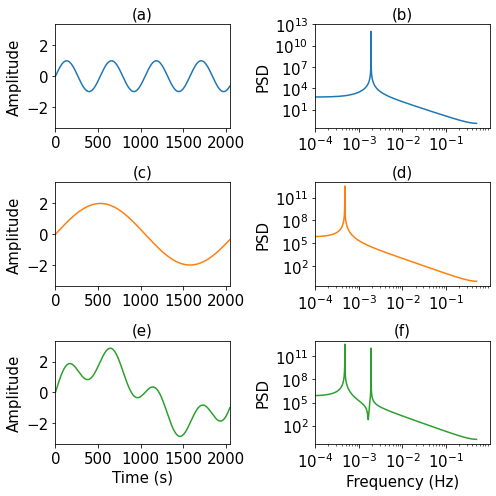

In [8]:
def generate_time_series(batch_size, n_steps,w1=0.5,w2=0,w3=0,w4=0,f1=1000,f2=1000,f3=1000,var_freq=True):
    #offsets1, offsets2 = np.random.rand(2, batch_size, 1)
    if var_freq == True:
      freq1, freq2 = np.random.rand(2, batch_size, 1)
    else:
      freq1, freq2 = np.empty((batch_size,n_steps), np.float32), np.empty((batch_size,n_steps), np.float32), 
      freq1[:], freq2[:] = 0.5,0.5
    time = np.linspace(0, 1, n_steps)
    series =  w1 * np.sin((time ) * (freq1 * f1))  #   wave 1
    series += w2 * np.sin((time ) * (freq1 * f2)) # + wave 2
    series += w3 * np.sin((time ) * (freq1 * f3)) # + wave 2
    series += w4 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series#[..., np.newaxis].astype(np.float32)

N = 1 # number of time series
L = 2**21 # length of each sample (number of values for each sine wave)

y1 = generate_time_series(batch_size=N,
                         n_steps = L,
                         w1= 1,   w2=0,     w3=0.00,   w4 = 0.0,
                         f1= 50000,f2 = 3000,f3 = 1000, 
                         var_freq=False)

y2 = generate_time_series(batch_size=N,
                         n_steps = L,
                         w1= 0,   w2=2,     w3=0.00,   w4 = 0.0,
                         f1= 50000,f2 = 50000//4,f3 = 1000, 
                         var_freq=False)
y3 = y2[0]+y1[0]
#!wget "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
# df_airlines = pd.read_csv('airline-passengers.csv')
# airlines = df_airlines.iloc[:,1].values


plt.figure(figsize=(7,7))
font=15
def plot_sin(data,color,title,label = False):
  plt.plot(data,color=color)
  plt.xlim(0,2*1024)
  plt.ylim(min(y3)-0.5,max(y3)+0.5)
  plt.ylabel('Amplitude',fontsize= font)
  if label == True : 
    plt.xlabel('Time (s)',fontsize=font)
    plt.xticks(fontsize=font)
  plt.yticks(fontsize=font)
  plt.title(title,fontsize= font)

def plot_sinPSD(data,title, color = 'k', label = False):
  plot_psd(data,color=color)
  plt.xlim(1e-4,0)
  plt.ylim(0,1e13)
  if label == True : plt.xlabel('Frequency (Hz)',fontsize=font)
  plt.ylabel('PSD',fontsize= font)
  plt.yticks(fontsize=font)
  plt.xticks(fontsize=font)
  plt.title(title,fontsize= font)

plt.rc('font', size=15)        # controls default text sizes
plt.subplot(3,2,1)
plot_sin(y1[0],'C0','(a)',label = False)


plt.subplot(3,2,2)
plot_sinPSD(y1[0],'(b)',color = 'C0' ,label = False)

plt.subplot(3,2,3)
plot_sin(y2[0],'C1','(c)', label = False)

plt.subplot(3,2,4)
plot_sinPSD(y2[0],'(d)',color = 'C1' ,  label = False)


plt.subplot(3,2,5)
plot_sin(y3,'C2','(e)',label = True)

plt.subplot(3,2,6)
plot_sinPSD(y3,'(f)',color = 'C2', label = True)

plt.rcdefaults()

plt.tight_layout()

plt.savefig('PSD_exemple.pdf',dpi=300,bbox_inches='tight')


## Data 2: Colored Noise

In [9]:
samples = 2**20 #Numbert os points

wn = cn.powerlaw_psd_gaussian(0, samples)   #White noise generation
pn = cn.powerlaw_psd_gaussian(1, samples)   #Pink Noise generation
tn = cn.powerlaw_psd_gaussian(5/3, samples) #Turbulence data generation
rn = cn.powerlaw_psd_gaussian(2, samples)   #Red Noise gereneration
 
#Normalizing to -1 to 1 data
wn1,wn2 = norm(wn)
pn1,pn2 = norm(pn)
rn1,rn2 = norm(rn) 
tn1,tn2 = norm(tn) 

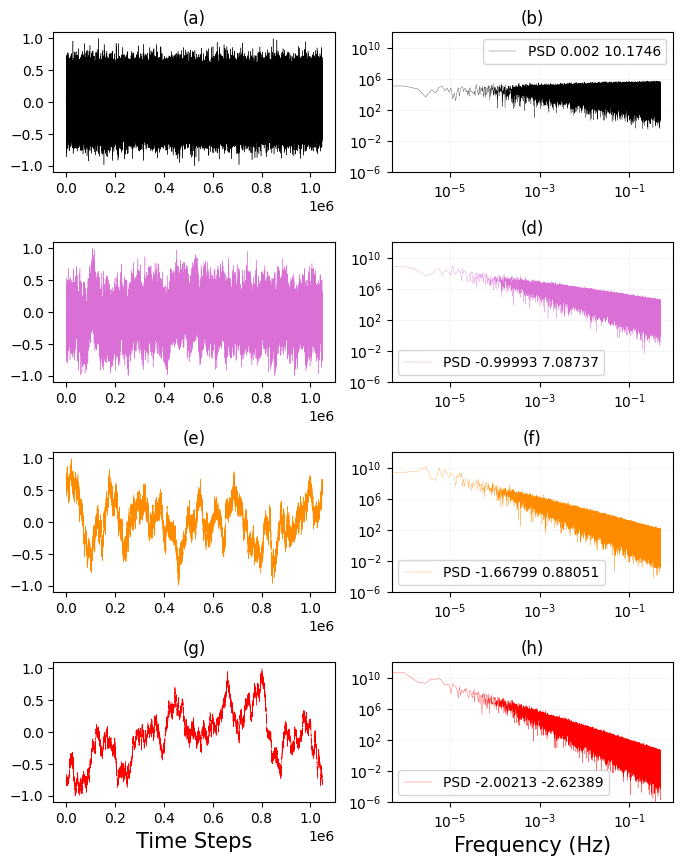

In [10]:
fig, ax = plt.subplots(4,2,figsize=(8,10),sharex=False,sharey=False)

noise_list       = [wn2,pn2,tn2,rn2]
noise_list_color = ['black','orchid','darkorange','red']
fig.subplots_adjust(hspace=0.5)

for i in range(len(noise_list)):
    ax[i,0].plot(noise_list[i],color=noise_list_color[i],alpha=1,linewidth=0.3)

for i in range(len(noise_list)):
    a,b,c,d = plot_psd(noise_list[i],is_subplot=True)
    text = f"PSD {np.round(c,5)} {np.round(d,5)}"    
    ax[i,1].loglog(a,b,color=noise_list_color[i],alpha=1,linewidth=0.2,label=text)
    ax[i,1].set_ylim(1e-6,1e12)
    ax[i,1].set_xscale('log')
    ax[i,1].grid(True,which="both",ls="--", color='0.65',alpha=0.2,linewidth=0.5, zorder=-10, axis='both')
    ax[i,1].legend()

# insert label in the last subplot
ax[3,0].set_xlabel('Time Steps',fontsize=font)
ax[3,1].set_xlabel('Frequency (Hz)',fontsize=font)

for i, axi in enumerate(ax.flat): axi.set_title('(%s)' % chr(ord('a') + i))
#plt.tight_layout()
#plt.savefig('PSD_all_data.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Creating `trainX` and `trainY`

In [10]:
# ### ⚠️⚠️⚠️⚠️⚠️ COMENTEND ⚠️⚠️⚠️⚠️⚠️⚠️ ###
# #This cell will creat and save large among of data
# #Generate and Save All data
# win_in = [1024,1024,1024,2048,2048,2048,4096,4096,4096]
# win_ou = [1024,2048,4096,1024,2048,4096,1024,2048,4096]
# n_series = 2**13

# for i in range(len(win_in)):
#   data = generate_data(n_series,win_in[i],win_ou[i],
#                      title=f'data_X{win_in[i]}_Y{win_ou[i]}_n{n_series}.pt')
# # Zip File 📦
# !zip -r /content/All_Files.zip /content  

# ##### 🆙🆙🆙🆙🆙🆙 LOAD THE DATA 🆙🆙🆙🆙🆙🆙🆙 #####
# win_in = 1024
# win_ou = 2048
# n_series = 2**13
# data1 = torch.load(f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
# trainX, trainY, trainX_test,trainY_test = data1[2][0],data1[2][1],data1[2][2],data1[2][3]

In [11]:
# def set_path(model='MLP',beta=0,user='usuario',met='ASNGNI'):
#     path = f'/home/{user}/Documentos/P1_RNN/Results/{met}/R_{model}_1024_2048_{beta}/'
#     os.chdir(path)

In [11]:
win_in = 1024
win_ou = 2048
#jump = 512*16*4
n_series = 2**8

#dataset = rn
#trainX, trainY, trainX_test,trainY_test = create_dataset(dataset,win_in,win_ou,jump,isTensor=True)
#data = generate_data(n_series,win_in,win_ou,
#                     title=f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
#os.chdir('/home/barauna/Documentos/P1_RNN/src/exp_MLP')
#os.chdir('/home/barauna/Documentos/P1_RNN/Results')
data = torch.load(f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
beta = 2
trainX, trainY, trainX_test,trainY_test = data[beta][0],data[beta][1],data[beta][2],data[beta][3]

## Ploting Data Analyse

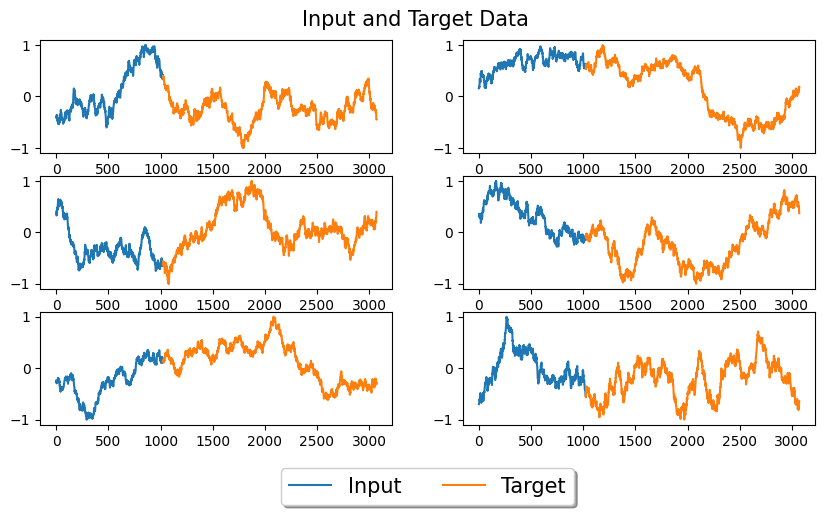

In [12]:
#Ploting a Sequence of Series for the dataframe
plt.figure(figsize=(10,5))
plt.suptitle('Input and Target Data',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
for k in range(6):
  plt.subplot(3,2,k+1)
  plot_test(trainX_test[k],trainY_test[k],color_x='C0',color_y='C1')
plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.8),
           ncol=4, fancybox=True, shadow=True,prop={'size': 15}) 
plt.show()

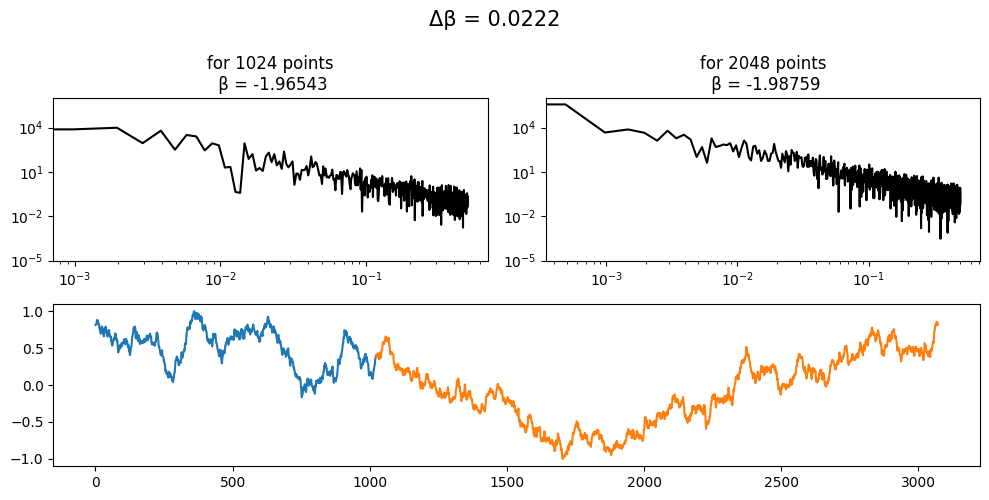

In [13]:
#Ploting train and target data with his power spectruns
k = 0
l = DBeta(1)
plt.figure(figsize=(10,5))
plt.suptitle(f'Δβ = '+str(round((l.beta(torch.Tensor(trainX))[k].detach().numpy()[0] - l.beta(torch.Tensor(trainY))[k].detach().numpy()[0]),4)),  y=0.95, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
plt.subplot(2,2,1)
plot_psd(trainX[k])
plt.ylim(1e-5,1e6)
plt.title(f'for {len(trainX[k])} points\n β = '+str(round(l.beta(torch.Tensor(trainX))[k].detach().numpy()[0],5)))
plt.subplot(2,2,2)
plt.title(f'for {len(trainY[k])} points\n β = '+str(round(l.beta(torch.Tensor(trainY))[k].detach().numpy()[0],5)))
plot_psd(trainY[k])
plt.ylim(1e-5,1e6)
plt.subplot(2,2,(3,4))
plot_test(trainX[k],trainY[k])
plt.tight_layout()
#plt.text(1, 1, r'$\mathcal{A}\mathrm{sin}(2 \omega t)$')

# Data Analysis

In [14]:
win_in = 1024
win_ou = 2048
jump   = 512

samples = 2**20 #Numbert os points

wn = cn.powerlaw_psd_gaussian(0, samples)   #White noise generation
pn = cn.powerlaw_psd_gaussian(1, samples)   #Pink Noise generation
tn = cn.powerlaw_psd_gaussian(5/3, samples) #Turbulence data generation
rn = cn.powerlaw_psd_gaussian(2, samples)   #Red Noise gereneration

#Data Set 01 - Recorted dataset
trainX_wn_01, trainY_wn_01 = dataset_test(wn,win_in,win_ou,jump,isTensor=True)
trainX_pn_01, trainY_pn_01 = dataset_test(pn,win_in,win_ou,jump,isTensor=True)
trainX_rn_01, trainY_rn_01 = dataset_test(rn,win_in,win_ou,jump,isTensor=True)
trainX_tn_01, trainY_tn_01 = dataset_test(tn,win_in,win_ou,jump,isTensor=True)

#Data Set 02 - Generated All Single Series

trainX_wn_02,trainX_pn_02,trainX_rn_02, trainX_tn_02 = [],[],[], []
trainY_wn_02,trainY_pn_02,trainY_rn_02, trainY_tn_02 = [],[],[], []
for i in range(len(trainX_wn_01)):
  trainX_wn_02.append(norm4(cn.powerlaw_psd_gaussian(0, win_in)))
  trainY_wn_02.append(norm4(cn.powerlaw_psd_gaussian(0, win_ou)))
  trainX_pn_02.append(norm4(cn.powerlaw_psd_gaussian(1, win_in)))
  trainY_pn_02.append(norm4(cn.powerlaw_psd_gaussian(1, win_ou)))
  trainX_rn_02.append(norm4(cn.powerlaw_psd_gaussian(2, win_in)))
  trainY_rn_02.append(norm4(cn.powerlaw_psd_gaussian(2, win_ou)))
  trainX_tn_02.append(norm4(cn.powerlaw_psd_gaussian(5/3, win_in)))
  trainY_tn_02.append(norm4(cn.powerlaw_psd_gaussian(5/3, win_ou)))

trainX_wn_02, trainY_wn_02= torch.tensor(trainX_wn_02), torch.tensor(trainY_wn_02)
trainX_pn_02, trainY_pn_02= torch.tensor(trainX_pn_02), torch.tensor(trainY_pn_02)
trainX_rn_02, trainY_rn_02= torch.tensor(trainX_rn_02), torch.tensor(trainY_rn_02)
trainX_tn_02, trainY_tn_02= torch.tensor(trainX_tn_02), torch.tensor(trainY_tn_02)

#Data Set 03 - TrainX and TrainY from a single Series
trainX_wn_03, trainY_wn_03 = dataset_test2(0,len(trainX_wn_01),win_in,win_ou)
trainX_pn_03, trainY_pn_03 = dataset_test2(1,len(trainX_pn_01),win_in,win_ou)
trainX_rn_03, trainY_rn_03 = dataset_test2(2,len(trainX_rn_01),win_in,win_ou)
trainX_tn_03, trainY_tn_03 = dataset_test2(2,len(trainX_tn_01),win_in,win_ou)

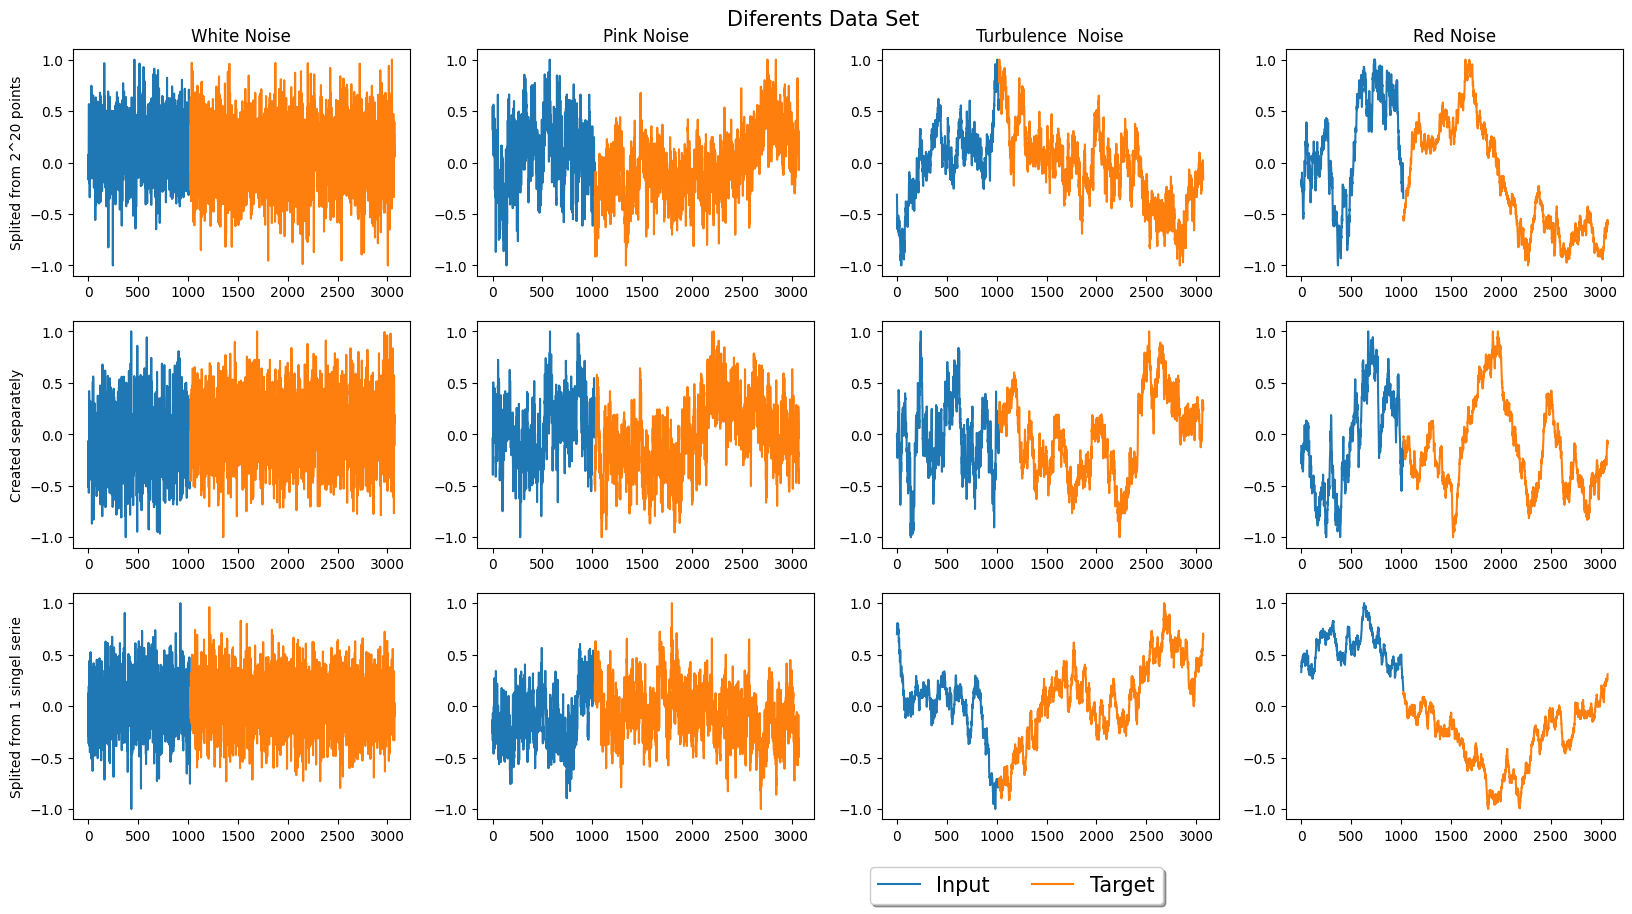

In [15]:
plt.figure(figsize=(20,10))
plt.suptitle('Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
k=0
plt.subplot(3,4,1)
plt.ylabel(f'Splited from 2^{int(np.log2(len(wn)))} points')
plt.title('White Noise')
plot_test(trainX_wn_01[k],trainY_wn_01[k])
plt.subplot(3,4,2)
plt.title('Pink Noise')
plot_test(trainX_pn_01[k],trainY_pn_01[k])
plt.subplot(3,4,3)
plt.title('Turbulence  Noise')
plot_test(trainX_tn_01[k],trainY_tn_01[k])
plt.subplot(3,4,4)
plt.title('Red Noise')
plot_test(trainX_rn_01[k],trainY_rn_01[k])

plt.subplot(3,4,5)
plt.ylabel(f'Created separately')
plot_test(trainX_wn_02[k],trainY_wn_02[k])
plt.subplot(3,4,6)
plot_test(trainX_pn_02[k],trainY_pn_02[k])
plt.subplot(3,4,7)
plot_test(trainX_tn_02[k],trainY_tn_02[k])    
plt.subplot(3,4,8)
plot_test(trainX_rn_02[k],trainY_rn_02[k])    

plt.subplot(3,4,9)
plt.ylabel(f'Splited from 1 singel serie')
plot_test(trainX_wn_03[k],trainY_wn_03[k])
plt.subplot(3,4,10)
plot_test(trainX_pn_03[k],trainY_pn_03[k])
plt.subplot(3,4,11)
plot_test(trainX_tn_03[k],trainY_tn_03[k])
plt.subplot(3,4,12)
plot_test(trainX_rn_03[k],trainY_rn_03[k])

plt.legend(loc='lower center', bbox_to_anchor=(-0.8, -0.42),
           ncol=4, fancybox=True, shadow=True,prop={'size': 15}) 
plt.show()

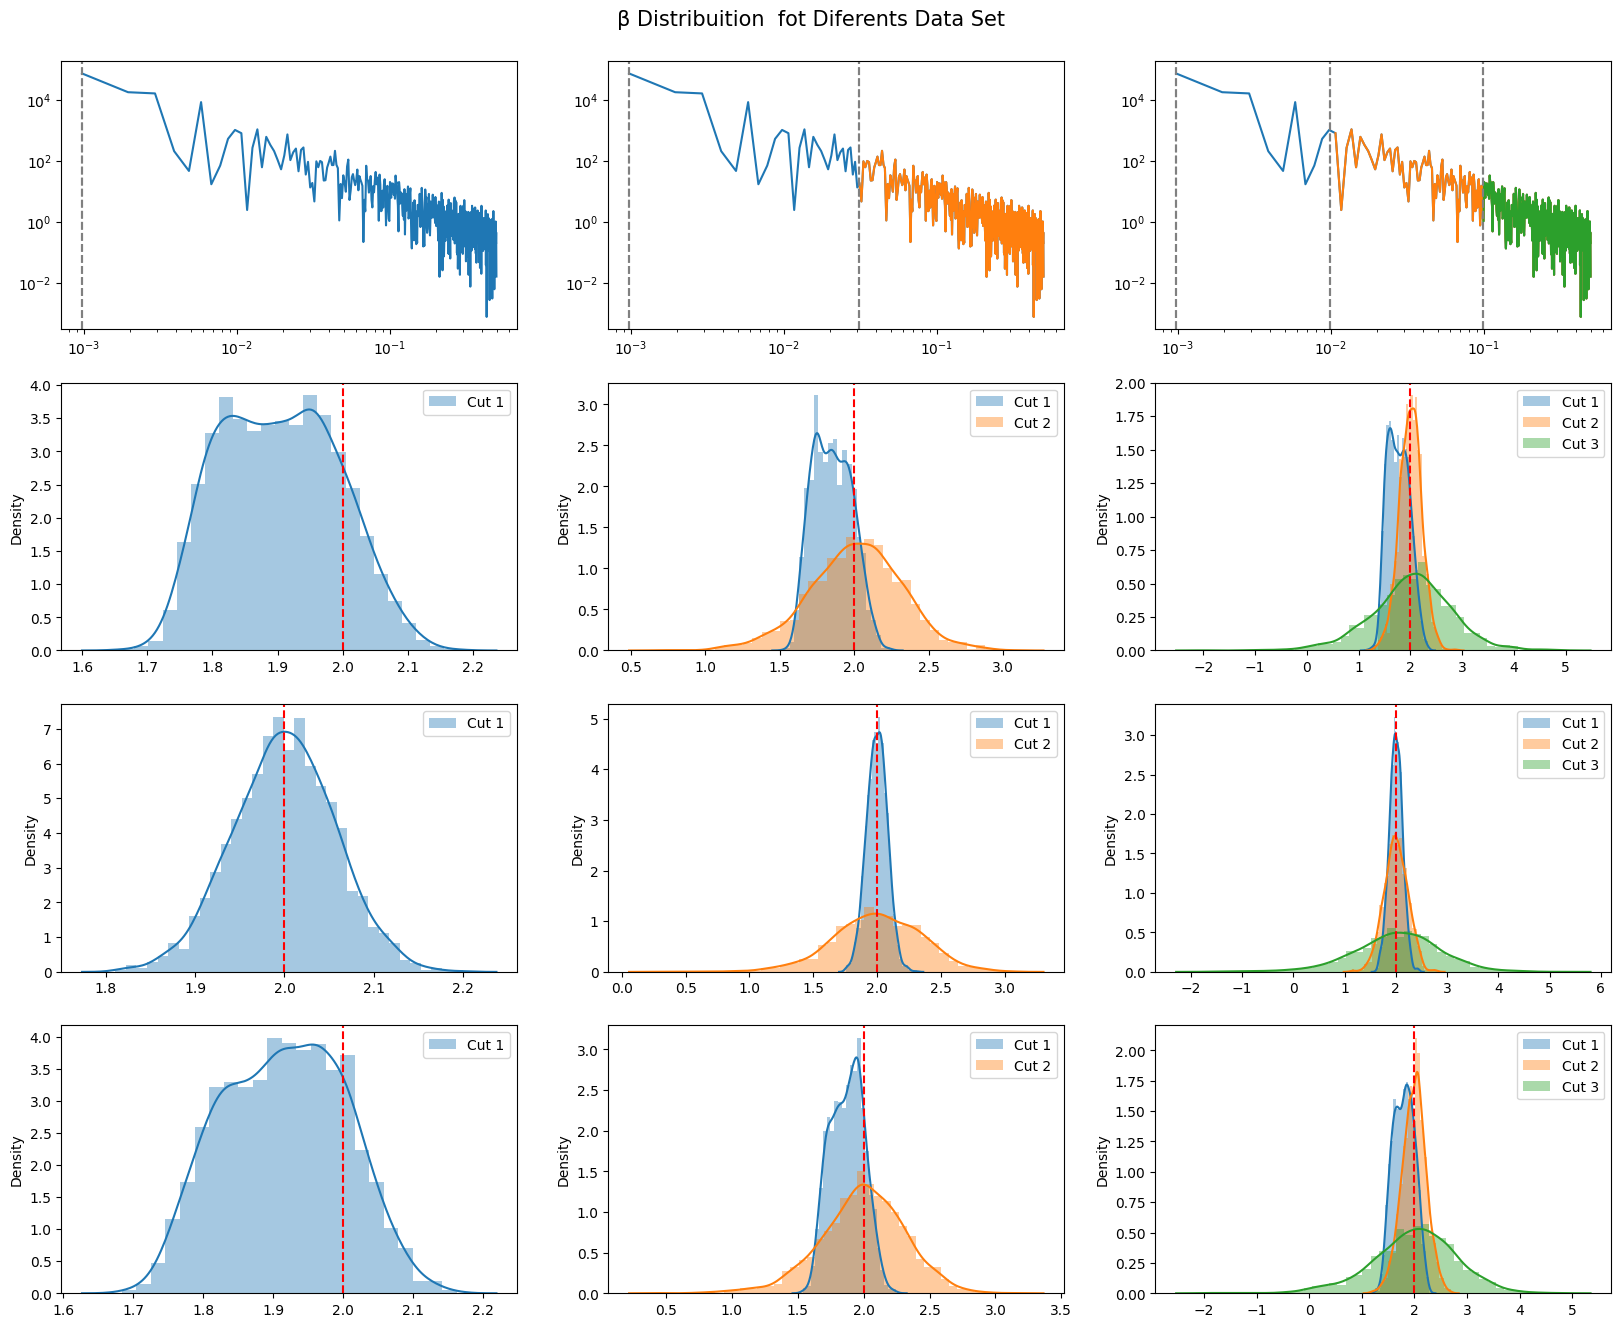

In [16]:
#l = DBeta(n_cut)

bet_index = 2
n_cut = 3
n_rowns = 4
#vets = [trainX_wn_01,trainX_wn_02,trainX_wn_03]
#vets = [trainX_pn_01,trainX_pn_02,trainX_pn_03]
vets = [trainX_rn_01,trainX_rn_02,trainX_rn_03]


def plot_ncut_beta(bet = 0,n_cut = n_cut,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi1  = 1,title=None): 
  plt.subplot(n_rowns,c_colum,possi1)
  for i in range(0,n_cut): 
    l = DBeta(n_cut)#(i+1)#??????????  
    sns.distplot(-l.beta(vet)[:,i],label=f'Cut {i+1}')
  plt.axvline(bet_index,color = 'r', linestyle='--')
  #plt.title(title)
  plt.legend()

def plot_cuted_psd(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi2  = 1,title=None):
  plt.subplot(n_rowns,c_colum,possi2)
  plot_color_psd(vet[0],n_cut)
  for i in range(n_cut):  
    plt.axvline(x=(len(vet[0])**(-(i+1)/n_cut)),color='gray',ls='--')


plt.figure(figsize=(20,16))
plt.suptitle('β Distribuition  fot Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
for i in range(1,n_cut+1):
  plot_cuted_psd(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i        ,title=f'{1}º cut')
  plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i),title=f'{i}º cut')
  plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=f'{i}º cut')
  plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=f'{i}º cut')
  #plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[3], n_rowns = n_rowns,c_colum = n_cut,possi1  = (4*n_cut+i),title=f'{i}º cut')

## Plot on Violin


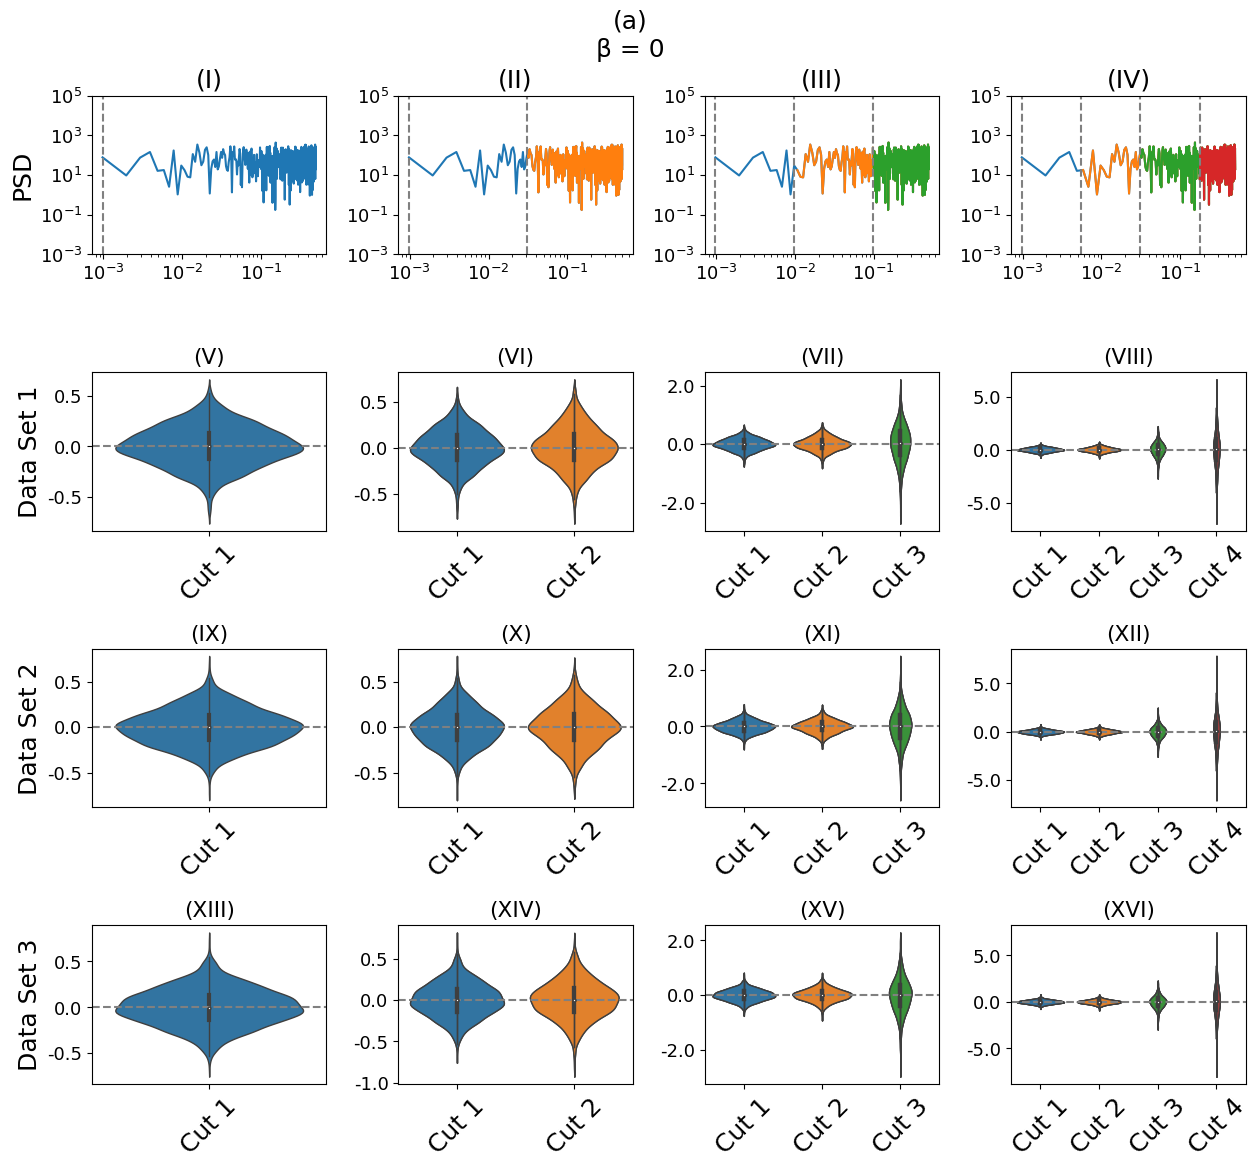

In [26]:
#Ploting Paramenters

n_cut = 4
l = DBeta(n_cut)
SIZE = 18

#### FUNCTIONS ####
def beta_df(data,data_name,n_cut):
  cuted_beta = [] #empty vector
  for i in range(n_cut): cuted_beta.append(-l.beta(data)[:,i]) #Alocating betas from the functions
  sum = torch.cat(cuted_beta).detach().numpy() #concatoneting all data in ine single numpy vector
  _df = pd.DataFrame() #Creating a dataframe
  _df.insert(0,data_name,sum) #Inserting sum on data frame
  _ds = [] #creating a vector for cut type
  for i in range(len(cuted_beta)): 
    for j in range(cuted_beta[i].size(0)): _ds.append(f'Cut {i+1}')
  _df.insert(1,'ds',_ds)
  return _df

def plot_ncut_beta_violin(bet = 0,n_cut = 4,vet = vets[0],n_rowns = 1,c_colum = 1,possi1  = 1,title=None,y_label=None,axis = False): 
  plt.subplot(n_rowns,c_colum,possi1)
  for i in range(0,n_cut): 
    l = DBeta(n_cut) #Creating a new DBeta function
    sns.violinplot(x='ds',y=data_name,data=beta_df(vet,data_name,n_cut),edgecolor="none", linewidth=1) #Plotting the violin plot
  plt.axhline(bet_index if bet_index != 3 else 5/3,color = 'gray', linestyle='--') #Plotting the line
  plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f')) #Setting the y axis format
  plt.ylabel(y_label,fontsize=SIZE) #Setting the y axis label
  plt.xlabel(None) #Setting the x axis label
  if axis == False: plt.xticks([]) #Setting the x axis ticks
  else : plt.xticks(fontsize=SIZE, rotation=45) #Setting the x axis ticks
  plt.title(title) #Setting the title

def plot_cuted_psd(bet = 0,n_cut = 4,vet = vets[0],n_rowns = 1,c_colum = 1,possi2  = 1,title=None,y_label=None):
  plt.subplot(n_rowns,c_colum,possi2) 
  if y_label != None: plt.ylabel('PSD',fontsize=SIZE) #Setting the y axis label
  plot_color_psd(vet[0],n_cut) #Plotting the PSD
  plt.ylim(1e-3,1e5) #Setting the y axis limits
  plt.title(title,fontsize=SIZE) #Setting the title

#### PLOTTING ####

vetao = [[trainX_wn_01,trainX_wn_02,trainX_wn_03],
          [trainX_pn_01,trainX_pn_02,trainX_pn_03],
          [trainX_rn_01,trainX_rn_02,trainX_rn_03],
          [trainX_tn_01,trainX_tn_02,trainX_tn_03]]

for k in range(0,1):#len(vetao)):
  
  vets = vetao[k]
  bet_index = k
  n_rowns = 4
  cinco_terco = '5/3'

  data_name = "Sun"
  lettes_suptil = ['(a)','(b)' ,'(d)' ,'(c)'  ,'(e)','(f)'  ,'(g)'   ,'(h)'    ,'(i)'  ,'(j)' ,'(k)' ,'(l)'  ,'(m)'   ,'(n)'  ,'(o)' ,'(p)'  ,'(q)']
  lettes_title  = ['(I)','(II)','(III)','(IV)','(V)', '(VI)', '(VII)', '(VIII)', '(IX)', '(X)','(XI)','(XII)','(XIII)','(XIV)','(XV)','(XVI)','(XVII)']

  #### CREATING THE FIGURE ####
    
  fig = plt.figure(figsize=(16*0.8,12)) #Creating the figure
  plt.rc('font', size=13)        # controls default text sizes
  plt.suptitle(f'{lettes_suptil[k]}\nβ = {bet_index if k != 3 else cinco_terco}',  y=0.93, horizontalalignment='center', verticalalignment='bottom', fontsize=SIZE) #Setting the suptitle
  #plt.subplots_adjust(wspace=0.1, hspace=0.9) #Setting the space between subplots
  labels = ['Data Set 1','Data Set 2', 'Data Set 3'] #Creating the labels
  for i in range(1,n_cut+1): #Plotting the plots
    plot_cuted_psd(       bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i          ,title=lettes_title[i-1]  , y_label='PSD'     if i == 1 else None) 
    #if i != 1: plt.tick_params(labelbottom=False, labelleft=False) #Setting the ticks
    plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i)  ,title=lettes_title[i+3],  y_label=labels[0] if i == 1 else None, axis = True) #Plotting the violin plot
    plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=lettes_title[i+7],  y_label=labels[1] if i == 1 else None, axis = True) #Plotting the violin plot
    plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=lettes_title[i+11], y_label=labels[2] if i == 1 else None, axis = True)  #Plotting the violin plot
  plt.savefig(f'./violin_ditri_{bet_index}.pdf', dpi=300, bbox_inches='tight') #Saving the figure
  plt.tight_layout()
  plt.rcdefaults()
  plt.show()

# Models

A ideia dessa rede é evitar a dissonância informacional. A rede guarda internamente a memória de curto prazo, ao informar novamente a rede sobre o estado de curto prazo, poderemos estar reintroduzindo informação que já foi filtrada/descartada. Esta reintrodução de dado espúrio estamos chamando de dissonância informacional.

## [10 Hyperparameters to keep an eye on for your LSTM model — and other tips](https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4) 

1. ✅NUMBER OF NODES AND HIDDEN LAYERS 

2. ✅ NUMBER OF UNITS IN A DENSE LAYER 

3. ✅ DROPOUT

4. WEIGHT INITIALIZATION

5. DECAY RATE

6. ✅ ACTIVATION FUNCTION

7. ✅ LEARNING RATE

8. MOMENTUM

9. ✅ NUMBER OF EPOCHS

10. BATCH SIZE

EXTRA 

1. OPTIMIZATION SETUP

2. ✅ NETWORK STRUCTURE (RNN, LSTM, GRU)

3. ✅ MODEL PARAMETERS

## Training Loop

In [38]:
def training_loop(n_epochs,     #Number of epochs
                  model,        #Model used for traingin 
                  loss_fn,      #Loss Functions 
                  train_input,  #Train data flow in the model traing
                  train_target, #Target data for traing
                  test_input,   #Data who will not be user for update weigths
                  test_target,  # "    "   "   "
                  optimiser,    #Optimizer criteria used in the model
                  lr  = 0.01,   # Learning Rate 
                  future=0,     # How many points in the future the model will generate
                  n_cut=1,      # Number of division of frequency in frequenct space
                  file_name='result.plk', #data Outputa name
                  plot_results_during_traing=True,
                  save_results = True,
                  verbose = True): #Do you wanna see plots during the trainig?
    loss_train_history = [] #Vector for the Loss Plot
    loss_valid_history = [] #Vector for the Loss Plot
    train_input_clone =  (train_input)   #Cloning train_input
    train_target_clone = (train_target) #Cloning target_input 
    test_input_clone =   (test_input)     #Cloning test_input
    test_target_clone =  (test_target)   #Cloning targe_input

    n = test_input_clone.shape[1] # 999
    m = test_target_clone.shape[1]
      
    if    optimiser == 'LBFGS': optimiser2 =  torch.optim.LBFGS(model.parameters(), lr=lr)
    elif  optimiser == 'Adam' : optimiser2 =  torch.optim.Adam( model.parameters(), lr=lr)
    elif  optimiser == 'SGD'  : optimiser2 =  torch.optim.SGD(  model.parameters(), lr=lr, momentum=0.1)
    
  
    #hidden_layers = model.hidden_layers
    ########## CREATING DATAFRAME ###############
    # a dataframe with 1 test time series, 1 target test time series, noise, time of runing loss traing and acuracy, time of each epochs and output anf future for each epochs
    df = create_dataframe(list(test_input_clone[0].detach().numpy().copy()),
                          list(test_target_clone[0].detach().numpy().copy()),
                          test_input_clone.detach().numpy().copy(),
                          test_target_clone.detach().numpy().copy())
     
    #LOOP TRAINING
    for i in range(n_epochs): #Runing in all the epochs
        t0 = time.time()      #Saving time of runing
        shuffle            = torch.randperm(train_input_clone.size(0)) #Embaralhando a orgem das séries
        train_input_clone  = train_input_clone[shuffle,:]
        train_target_clone = train_target_clone[shuffle,:]
        test_input_clone   = test_input_clone[shuffle,:]
        test_target_clone  = test_target_clone[shuffle,:]
        def closure():
            optimiser2.zero_grad()
            out = model(train_input_clone,train_target_clone.size(1)) #independente de quanto seja o valor de saída a mais no future, ele ira gerar um vetor de tamanho igual ao tamanho de saída. Dessa forma subtração dará o valor que queremos de saída a mais
            loss = loss_fn(out[:,-train_target_clone.size(1):], train_target_clone) #Calculate de loss functions only for the point were the data was generated
            loss.backward() #update weigts
            return loss     #Return Loss value
        optimiser2.step(closure) #Call the funcution
        with torch.no_grad(): #torch.no_grad() do not update weigths
            pred2 = model(test_input_clone,future_preds=test_target_clone.size(1)+future) #Predict values for test points
            #Savind the Betas validation distribution for each epoch
            ori_betas = loss_fn.beta((test_input_clone))
            out_betas = loss_fn.beta(pred2[:,1024:2048]).detach().numpy()[:,0]
            fut_betas = loss_fn.beta(pred2[:,1024+2048:]).detach().numpy()[:,0]
            #Traditonal data 
            y2 = pred2.detach().numpy().copy()
            y2 = y2[:,test_input_clone.size(1):] #take only the non input data
        for j in range(0,len(y2)): y2[j] = norm4(y2[j]) #NORMALIZATION (-1 a 1)
        append_dataframe(df,list(y2[0,32:m]),list(y2[0,m:]),out_betas,fut_betas,i) #Append this results in the dataframe
        

        #SAVING LOSS TRAIN
        out1 = model(train_input) #Pass the traing for the model
        loss_train_print = loss_fn(out1, train_target) #Calculate the loss for these output
        loss_train_history.append(loss_train_print.detach().numpy()) #Save this values and append it in a vector
        #SAVING LOSS VALIDATION
        out2 = model(test_input) #Do the same for test
        loss_valid_print = loss_fn(out2, test_target)
        loss_valid_history.append(loss_valid_print.detach().numpy())
        t1 = time.time() #What time is it? 
        if save_results:
          df['loss_train'].loc[i] = loss_train_history[i] #Alocatiing this value in the dataframe positon
          df['loss_valid'].loc[i] = loss_valid_history[i] #Do the same for validation data
          df['time'].loc[i] = t1-t0 #How long the take to run?
          df.to_pickle(file_name) #Save all data now 
        dft = dt(t0,t1) #Calculate de diference of time

        #PRINTING RESULTS
        if plot_results_during_traing:          
          #traini_data = df[~df.trainX.isnull()].trainX 
          target_data = df[~df.trainY.isnull()].trainY
          expect_data = df[~df[f'out{i+1}'].isnull()][f'out{i+1}']
          future_data = df[~df[f'fut{i+1}'].isnull()][f'fut{i+1}']
          ori_betas   = df[~df.ori_betas_y.isnull()].ori_betas_y
          out_betas = df[~df[f'out_betas{i+1}'].isnull()][f'out_betas{i+1}']
          fut_betas = df[~df[f'fut_betas{i+1}'].isnull()][f'fut_betas{i+1}']
          psd_target_data = plot_psd(target_data,is_subplot=True)
          psd_expect_data = plot_psd(expect_data,is_subplot=True)
          psd_future_data = plot_psd(future_data,is_subplot=True)
          plot_results3(target_data,expect_data,future_data,psd_target_data,psd_expect_data,psd_future_data,ori_betas,out_betas,fut_betas,model_title=title,sup_title=f'epochs {i+1}\nValidation Loss - {round(float(loss_train_history[i]),5)}\nTraing Loss - {round(float(loss_valid_history[i]),5)}',beta=beta)
          plt.show()      


        if verbose: print("Epoch: {}, Train Loss: {}, Validation Loss: {}, Time {}".format(i+1, round(float(loss_train_history[i]),5),round(float(loss_valid_history[i]),5),dft))
    loss = loss_valid_history[-1] 
    return loss#,delta_beta_t

## Models

### MLP

In [28]:
class MLP(nn.Module):
    #def __init__(self, input_size, hidden_layers, output_size):
    def __init__(self, input_size=1024, output_size=None, n_layers=2, hidden_layers=[32], activations=['sigmoid'],dropouts=[0.0],isGNI=True):
        '''
        input_size - numero de entradas da rede (numero fixo)
        hidden_layers - numero de neuronios na(s) camada(s) escondida (vetor)
        activations - lista da funcoes de ativacoes
        dropouts - lista de dropouts em cada camada
        output_size - numero de saidas da rede (por padrão eh igual a entrada) (numero fixo)
        '''
        super(MLP, self).__init__()

        self.isGNI = isGNI
        
        self.input_size = input_size
        self.hidden_layers = hidden_layers

        if output_size==None:
          self.output_size = input_size
        else:
          self.output_size = output_size

        self.combLayer = []
        self.activations = []
        self.dropouts = []
        self.n_layers = n_layers #len(hidden_layers)
        

        #hidden_layers2 = np.repeat(hidden_layers)
        
        for index in range(n_layers-1):
          if index == 0:
            self.combLayer.append(nn.Linear(input_size, hidden_layers[index]))
            self.activations.append(self.createActivation(str(activations[index])))
            self.dropouts.append(nn.Dropout(dropouts[index]))
          else:
            self.combLayer.append(nn.Linear(hidden_layers[index-1], hidden_layers[index])) 
            self.activations.append(self.createActivation(str(activations[index])))
            self.dropouts.append(nn.Dropout(dropouts[index]))
        if self.n_layers == 1:
          self.combLayer.append(nn.Linear(hidden_layers[0], self.output_size))
        else:
          self.combLayer.append(nn.Linear(hidden_layers[index],  self.output_size))
        #Ultima camada
        self.activations.append(self.createActivation(str(activations[-1])))
        self.dropouts.append(nn.Dropout(dropouts[-1]))

        self.combLayer = nn.ModuleList(self.combLayer)
        self.activations = nn.ModuleList(self.activations)
        self.dropouts = nn.ModuleList(self.dropouts)

    def createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()
        elif nome=='const':
          return const()          

    def __str__(self):
        output  = ""
        for i in range(self.n_layers):
          output += "======================\n"
          output += "Layer: "+str(i)+"\n"
          output += str(self.combLayer[i])+"\n"
          output += str(self.activations[i])+"\n"
          output += str(self.dropouts[i])+"\n"
        return output

    def forward(self, x, future_preds=0):
        if self.isGNI:
          x2 = torch.rand(x.size())
        else:
          x2 = torch.clone(x)
        output = []
        for i in range(len(self.combLayer)):
          x2 = self.combLayer[i](x2)
          x2 = self.activations[i](x2)
          x2 = self.dropouts[i](x2)
        output.append(x2)
        stepSize = x2.size(1)
        n = 0
        xpast = torch.clone(x2)
        
        while n<future_preds:
          xnew = torch.clone(xpast) 
          xnew= xnew[:,-(x.size(1)):]
          for j in range(len(self.combLayer)):
            xnew = self.combLayer[j](xnew)
            xnew = self.activations[j](xnew)
            xnew = self.dropouts[j](xnew)
          xpast = xnew
          output.append(xnew)
          n = n+xnew.size(1)
        output = torch.cat(output, dim=1)
        output = output[:,:x2.size(1)+future_preds]
        return output

    def __call__(self, x, future_preds=0):
      return self.forward(x, future_preds)

#print(MLP(n_layers = 2,hidden_layers=[32,64,128,8],activations=['sigmoid','tanh','relu','sigmoid'],dropouts=[0.0,0.5,0.9,0.666],output_size=len(trainY[0])))

### RNN

In [29]:
class RNN(nn.Module):
    ############## CONSTRCTUR ################
    def __init__(self,n_layers = 2, hidden_layers=[12,22,33],dropouts=[0,0,0],activations=['sigmoid'],isGNI=True):
        super(RNN, self).__init__()

        self.hidden_layers = hidden_layers  #Vectors of Neurons 
        self.n_layers = n_layers            #Number of Layers
        self.isGNI = isGNI                  #Condicional for random points in the begin
        self.dropouts = dropouts            #Vector for dropouts

        #Construct inside layers in the model
        self.layer_vec =        [nn.RNNCell( 1, self.hidden_layers[0])] #Inicial layer vector position 
        self.layer_vec.append(   nn.Dropout(self.dropouts[0]))          #Inicial Dropout Position
        for i in range(n_layers-1):                                     #Number of hinden_layers -1 becaouse the first has been allready implemented
          self.layer_vec.append( nn.RNNCell(self.hidden_layers[i], self.hidden_layers[i+1])) #Construct a layer with n neurons from a previos layer and for m neuros from the next layer
          self.layer_vec.append( nn.Dropout(self.dropouts[i+1]))        #Add dropoup layer after the layer
        #LAST TWO LAYERS - Is rnn architercute the les two layers need to be a Linear layers. 
        self.layer_vec.append(   nn.Linear(self.hidden_layers[n_layers-1], 1)) #In that case they will have the same number os neurons from the last hidden layer
        self.layer_vec.append(self.createActivation(activations[0]))    #The last layer is an activations functions

        self.layer_vec = nn.ModuleList(self.layer_vec)                  #Its importante to tranform all of the layers in pytorch lists with nn.ModuleList

    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)                             #Defeninf a empyt vector for the model output and the size of the bachs ⚠️ DEVERIAMOS PASSAR ISSO COMO A VARIÁVEL?
        h_t = []                                                        # The special vector from the rnn 
        for l in range(self.n_layers):                                  #Create h_t tensors 
          h_t.append(torch.zeros(batch_size,self.hidden_layers[l],dtype=torch.float32)) #fill all the h_t with data, zeros or rand
        
        for time_step in y.split(1, dim=1):                             # Pass the data trough the vectors
            if self.isGNI:  input = torch.rand(batch_size,1)
            else:           input = time_step
            
            for j in range(self.n_layers):
              h_t[j] = self.layer_vec[2*j](input, h_t[j])               # initial hidden and cell states
              h_t[j] = self.layer_vec[2*j+1](h_t[j])                    # dropout
              input  = h_t[j]
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)

        for i in range(future_preds):
            #input = outputs[-1]       
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = outputs[-1]
            for k in range(self.n_layers):
              h_t[k] = self.layer_vec[2*k](input, h_t[k]) # initial hidden and cell states
              h_t[k] = self.layer_vec[2*k+1](h_t[k])            # dropout
              input = h_t[k]
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)

        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

    def createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()
        elif nome=='const':
          return const()              

    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)

    def __str__(self):
        output  = ""
        for i in range(0,len(self.layer_vec),2):
          output += "======================\n"
          output += "Layer: "+str((i+1)//2)+"\n"
          output += str(self.layer_vec[i])+"\n"
          output += str(self.layer_vec[i+1])+"\n"
        return output
#print(RNN(n_layers = 4,hidden_layers=[12,24,36,45,57],dropouts=[0.1,0.2,0.3,0.4,0.5],activations=['tanh']))

### LSTM

In [30]:
class LSTM(nn.Module):
    def __init__(self,n_layers = 2, hidden_layers=[12,22,33],dropouts=[0,0,0],activations=['sigmoid'],isGNI=True):
        super(LSTM, self).__init__()

        self.hidden_layers = hidden_layers  #Vectors of Neurons 
        self.n_layers = n_layers            #Number of Layers
        self.isGNI = isGNI                  #Condicional for random points in the begin
        self.dropouts = dropouts            #Vector for dropout

        #Construct inside layers in the model
        self.layer_vec =        [nn.LSTMCell( 1, self.hidden_layers[0])] #Inicial layer vector position 
        self.layer_vec.append(   nn.Dropout(self.dropouts[0]))          #Inicial Dropout Position
        for i in range(n_layers-1):                                     #Number of hinden_layers
          self.layer_vec.append( nn.LSTMCell(self.hidden_layers[i], self.hidden_layers[i+1])) #Construct a layer with n neurons from a previos layer and for m neuros from the next layer
          self.layer_vec.append( nn.Dropout(self.dropouts[i+1]))        #Add dropoup layer after the layer
        #LAST TWO LAYERS - Is rnn architercute the les two layers need to be a Linear layers. 
        self.layer_vec.append(   nn.Linear(self.hidden_layers[n_layers-1], 1)) #In that case they will have the same number os neurons from the last hidden layer
        self.layer_vec.append(self.createActivation(activations[0]))    #The last layer is an activations functions
        
        self.layer_vec = nn.ModuleList(self.layer_vec)    
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        h_t, c_t = [],[]
        for l in range(self.n_layers):                                  #Create h_t tensors 
          h_t.append(torch.rand(batch_size,self.hidden_layers[l],dtype=torch.float32)) #fill all the h_t with data, zeros or rand
          c_t.append(torch.rand(batch_size,self.hidden_layers[l],dtype=torch.float32)) #fill all the h_t with data, zeros or rand

        for time_step in y.split(1, dim=1):
            if self.isGNI:  input = torch.rand(batch_size,1)
            else:           input = time_step
             
            for j in range(self.n_layers): 
              if j == 0: 
                h_t[0], c_t[0] = self.layer_vec[0](input, (h_t[0], c_t[0])) # initial hidden and cell states
                h_t[j]         = self.layer_vec[2*j+1](h_t[j]) 
                c_t[j]         = self.layer_vec[2*j+1](c_t[j]) 
              else: 
                h_t[j], c_t[j] = self.layer_vec[2*j](h_t[j-1], (h_t[j], c_t[j])) # new hidden and cell states
                h_t[j]         = self.layer_vec[2*j+1](h_t[j]) 
                c_t[j]         = self.layer_vec[2*j+1](c_t[j]) 
            #LAST LAYERS
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            if self.isGNI: input = torch.rand(batch_size,1)
            else:          input = out
            for k in range(self.n_layers): 
              if k == 0: 
                h_t[0], c_t[0] = self.layer_vec[0](input, (h_t[0], c_t[0])) # initial hidden and cell states
                h_t[k]         = self.layer_vec[2*k+1](h_t[k]) 
                c_t[k]         = self.layer_vec[2*k+1](c_t[k])                 

              else: 
                h_t[k], c_t[k] = self.layer_vec[2*k](h_t[k-1], (h_t[k], c_t[k])) # new hidden and cell states
                h_t[k]         = self.layer_vec[2*k+1](h_t[k]) 
                c_t[k]         = self.layer_vec[2*k+1](c_t[k])                 
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

    def createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()
        elif nome=='const':
          return const()              

    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)

    def __str__(self):
        output  = ""
        for i in range(0,len(self.layer_vec),2):
          output += "======================\n"
          output += "Layer: "+str((i+1)//2)+"\n"
          output += str(self.layer_vec[i])+"\n"
          output += str(self.layer_vec[i+1])+"\n"
        return output
#print(LSTM(n_layers = 4,hidden_layers=[12,24,36,45,57],dropouts=[0.1,0.2,0.3,0.4,0.5],activations=['tanh']))

### GRU

In [31]:
class GRU(nn.Module):
    ############## CONSTRCTUR ################
    def __init__(self,n_layers = 2, hidden_layers=[12,22,33],dropouts=[0,0,0],activations=['sigmoid'],isGNI=True):
        super(GRU, self).__init__()

        self.hidden_layers = hidden_layers  #Vectors of Neurons 
        self.n_layers = n_layers            #Number of Layers
        self.isGNI = isGNI                  #Condicional for random points in the begin
        self.dropouts = dropouts            #Vector for dropouts

        #Construct inside layers in the model
        self.layer_vec =        [nn.GRUCell( 1, self.hidden_layers[0])] #Inicial layer vector position 
        self.layer_vec.append(   nn.Dropout(self.dropouts[0]))          #Inicial Dropout Position
        for i in range(n_layers-1):                                     #Number of hinden_layers
          self.layer_vec.append( nn.GRUCell(self.hidden_layers[i], self.hidden_layers[i+1])) #Construct a layer with n neurons from a previos layer and for m neuros from the next layer
          self.layer_vec.append( nn.Dropout(self.dropouts[i+1]))        #Add dropoup layer after the layer
        #LAST TWO LAYERS - Is GRU architercute the les two layers need to be a Linear layers. 
        self.layer_vec.append(   nn.Linear(self.hidden_layers[n_layers-1], 1)) #In that case they will have the same number os neurons from the last hidden layer
        self.layer_vec.append(self.createActivation(activations[0]))    #The last layer is an activations functions

        self.layer_vec = nn.ModuleList(self.layer_vec)                  #Its importante to tranforma all of the layers in pytorch lists with nn.ModuleList

    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)                             #Defeninf a empyt vector for the model output and the size of the bachs ⚠️ DEVERIAMOS PASSAR ISSO COMO A VARIÁVEL?
        h_t = []                                                        # The special vector from the GRU 
        for l in range(self.n_layers):                                  #Create h_t tensors 
          h_t.append(torch.zeros(batch_size,self.hidden_layers[l],dtype=torch.float32)) #fill all the h_t with data, zeros or rand
        

        for time_step in y.split(1, dim=1):                             # Pass the data trough the vectors
            if self.isGNI:  input = torch.rand(batch_size,1)
            else:           input = time_step
            
            for j in range(self.n_layers):
              h_t[j] = self.layer_vec[2*j](input, h_t[j])              # initial hidden and cell states
              h_t[j] = self.layer_vec[2*j+1](h_t[j])                   # dropout
              input  = h_t[j]
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)

        for i in range(future_preds):
            #input = outputs[-1]       
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = outputs[-1]
            for k in range(self.n_layers):
              h_t[k] = self.layer_vec[2*k](input, h_t[k]) # initial hidden and cell states
              h_t[k] = self.layer_vec[2*k+1](h_t[k])            # dropout
              input = h_t[k]
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)

        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

    def createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()
        elif nome=='const':
          return const()              

    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)

    def __str__(self):
        output  = ""
        for i in range(0,len(self.layer_vec),2):
          output += "======================\n"
          output += "Layer: "+str((i+1)//2)+"\n"
          output += str(self.layer_vec[i])+"\n"
          output += str(self.layer_vec[i+1])+"\n"
        return output
#print(GRU(n_layers = 4,hidden_layers=[12,24,36,45,57],dropouts=[0.1,0.2,0.3,0.4,0.5],activations=['tanh']))

### CNN

[cnn time series forecasting with pytorch](https://www.kaggle.com/code/hanjoonchoe/cnn-time-series-forecasting-with-pytorch)

In [32]:
class CNN(nn.Module):
    def __init__(self, input_size=1024, 
                 n_layers=1, 
                 activations=['sigmoid'],
                 dropouts=[0.0,0.0,0,0,0,0,0,0], 
                 isGNI=True,
                 in_channels =3,
                 kernel_size =[3,3,3,3,3,3,3,3,3],
                 stride      =[1,1,1,1,1,1,1,1,1,1,1]):
        super(CNN, self).__init__()
        self.input_size = input_size
        #self.output_size = output_size
        self.n_layers = n_layers
        self.dropouts = dropouts

        self.input_size = input_size
        
        self.activations  = activations
        self.in_channels  = in_channels
        self.kernel_size  = kernel_size
        #self.padding      = (self.kernel_size)//2
        self.stride       = stride

        self.layer_vec = [nn.Conv1d(in_channels = self.in_channels[0], #Numero de séries temporais que eu tenho
                                   out_channels = self.in_channels[0], #numero de séries temporais que vai sair 
                                    kernel_size = kernel_size[0], #Tamanho do filtro que vai passar pelo modelo
                                    stride      = stride[0], #Quantos pontos ele vai pular pra frente
                                    padding     = (kernel_size[0])//2 )]
        self.layer_vec.append(nn.Dropout(dropouts[0]))
        self.layer_vec.append(self.createActivation(activations[0]))
        
        for d in range(n_layers-1): #ADDING SEVEREAL LAYERS
          self.layer_vec.append(nn.Conv1d(in_channels = self.in_channels[d+1], #Numero de séries temporais que eu tenho
                                    out_channels = self.in_channels[d+1], #numero de séries temporais que vai sair 
                                    kernel_size =  kernel_size[d+1], #Tamanho do filtro que vai passar pelo modelo
                                    stride      = stride[d+1], #Quantos pontos ele vai pular pra frente
                                    padding     = (kernel_size[d+1])//2 ))
          self.layer_vec.append(nn.Dropout(dropouts[d+1]))
          self.layer_vec.append(self.createActivation(activations[d+1]))
      
        self.layer_vec = nn.ModuleList(self.layer_vec) 



    def forward(self, x ,future_preds=0):
        output,outputs, batch_size = [],[], x.size(0)
        for f in x:
          # padded = nn.ConstantPad1d(self.kernel_size[0]//2,value=0)(f)
          # padded = padded.unfold(dimension = 0,size = self.in_channels, step = 1).T
          #print('p',padded.size())
          flow = f
          for f1 in range(self.n_layers):
            padded = nn.ConstantPad1d(self.kernel_size[f1]//2,value=0)(flow)
            padded = padded.unfold(dimension = 0,size = self.in_channels[f1], step = 1).T
            flow = self.layer_vec[3*f1](padded)[self.kernel_size[f1]//2,:]    #Passing trough the Conv layer
            flow = self.layer_vec[3*f1+1](flow)
            flow = self.layer_vec[3*f1+2](flow)
            
          output.append(flow)
        output = torch.stack(output)  
        outputs.append(output)
        n = 0
        xpast = torch.clone(output) 

        while n<future_preds:
          xnew = torch.clone(xpast) 
          ts = []
          for g in xnew:
            flow = g
            for g1 in range(self.n_layers):
              padded = nn.ConstantPad1d(self.kernel_size[g1]//2,value=0)(flow)
              padded = padded.unfold(dimension = 0,size = self.in_channels[g1], step = 1).T
              flow = self.layer_vec[3*g1](padded)[self.kernel_size[g1]//2,:]
              flow = self.layer_vec[3*g1+1](flow)
              flow = self.layer_vec[3*g1+2](flow)


            ts.append(flow)
          xnew = torch.stack(ts)
          outputs.append(xnew)
          xpast = xnew
          n = n + xnew.size(1)
        outputs = torch.cat(outputs, dim=1)
        outputs = outputs[:,:x.size(1)+future_preds]  #If you ganerate more points ignore then
        #print(outputs.size())
        return outputs
    

    
    def createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()      
        elif nome=='const':
          return const()
     
    def __call__(self, x, future_preds=0):
      return self.forward(x, future_preds) 

    def __str__(self):
        output  = ""
        for i in range(0,2*self.n_layers,2):
          output += "======================\n"
          output += "Layer: "+str((i+2)//2)+"\n"
          output += str(self.layer_vec[i])+"\n"
          output += str(self.layer_vec[i+1])+"\n"
        return output

# Experiments

In [33]:
train_size = len(trainX[0])
test_size =  len(trainY[0])

## E1 - MPL

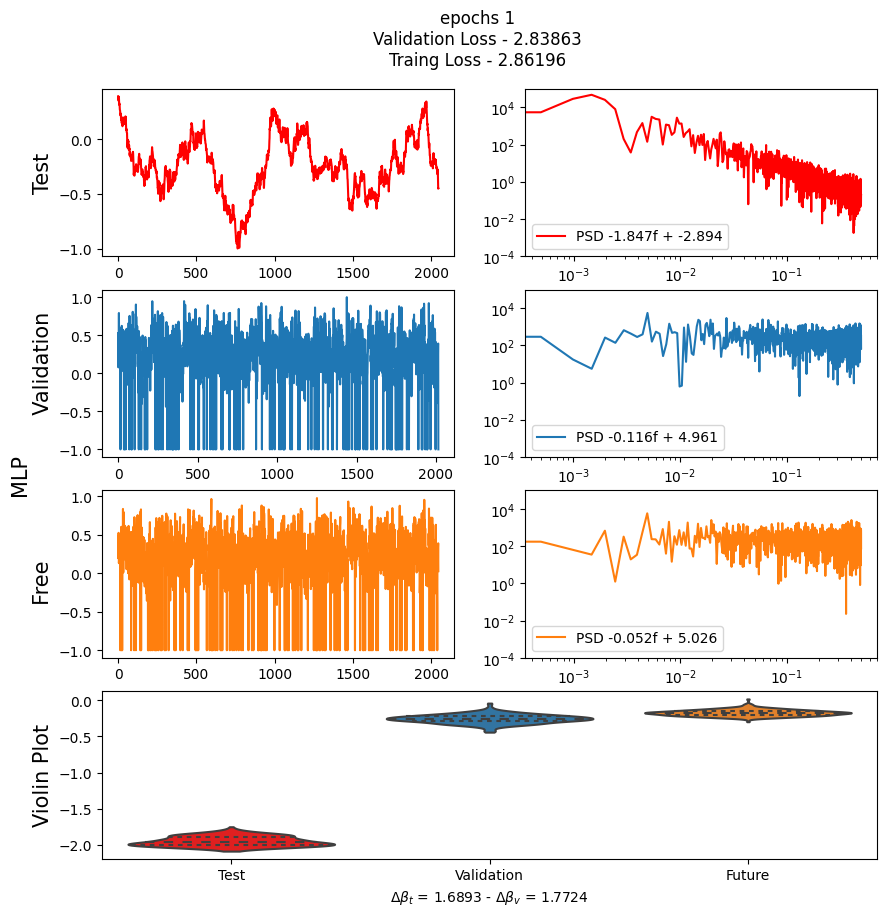

Epoch: 1, Train Loss: 2.83863, Validation Loss: 2.86196, Time 0.652 s


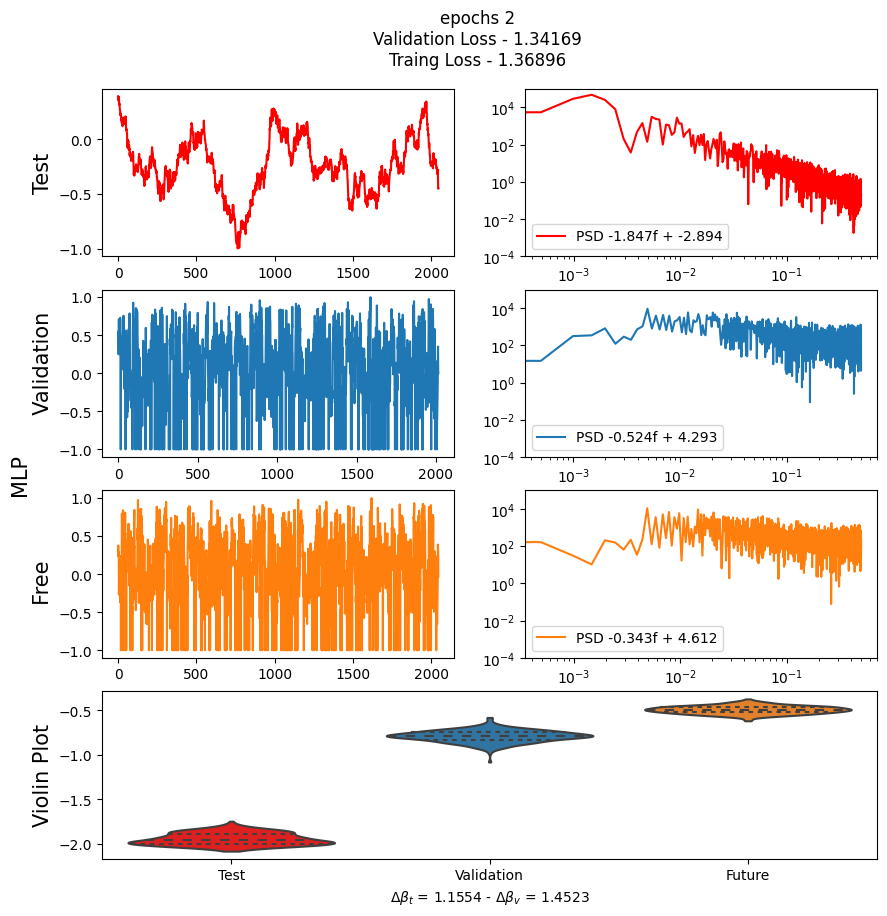

Epoch: 2, Train Loss: 1.34169, Validation Loss: 1.36896, Time 0.688 s


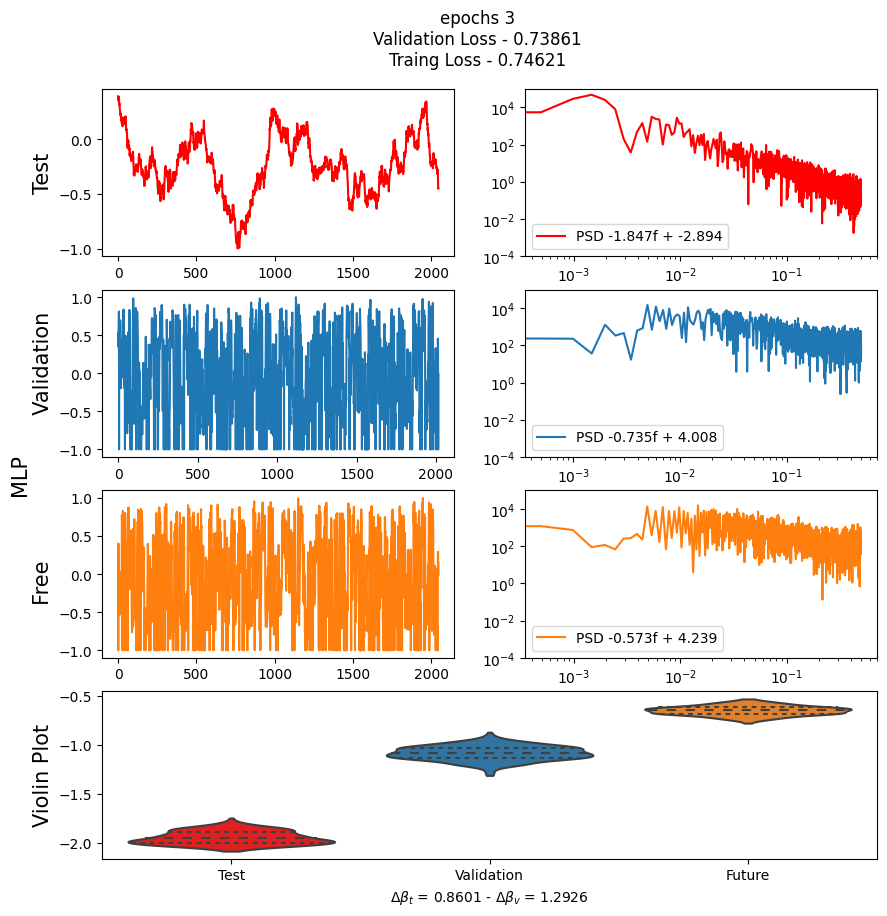

Epoch: 3, Train Loss: 0.73861, Validation Loss: 0.74621, Time 0.697 s


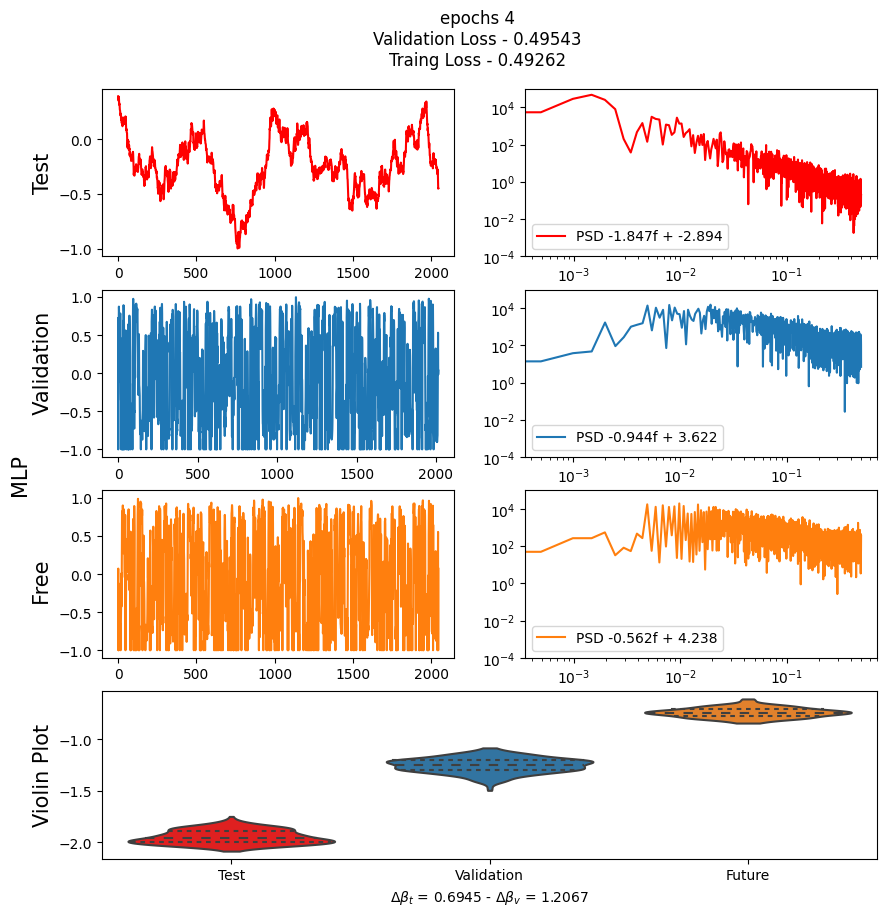

Epoch: 4, Train Loss: 0.49543, Validation Loss: 0.49262, Time 0.659 s


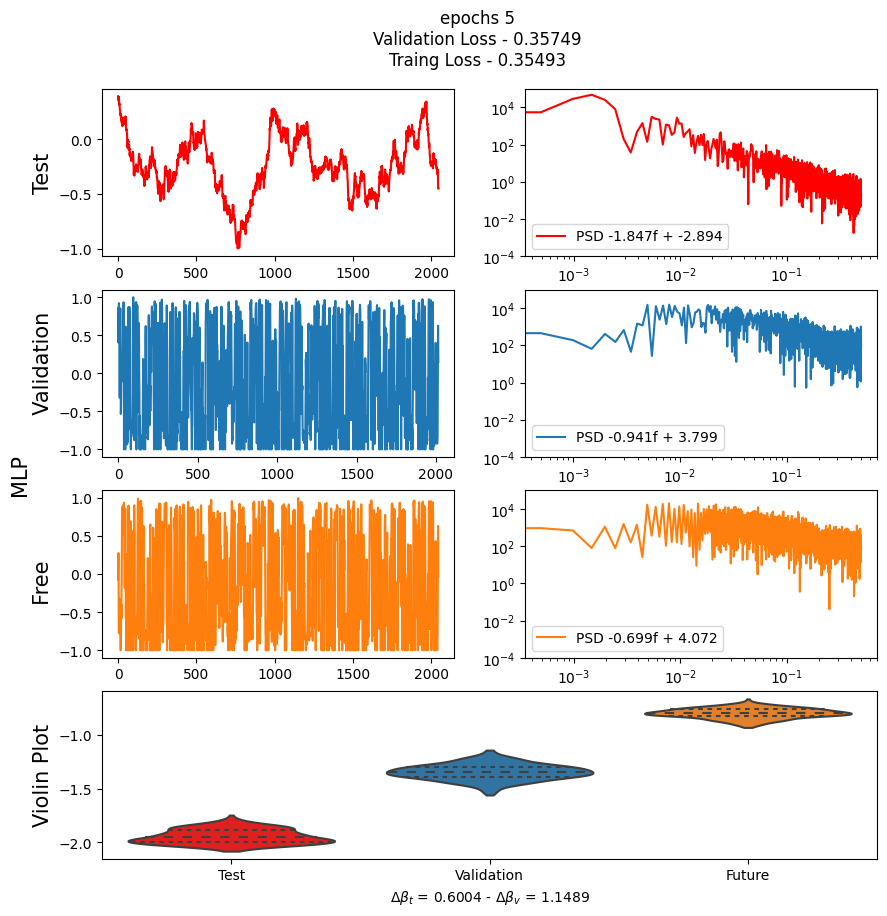

Epoch: 5, Train Loss: 0.35749, Validation Loss: 0.35493, Time 0.746 s


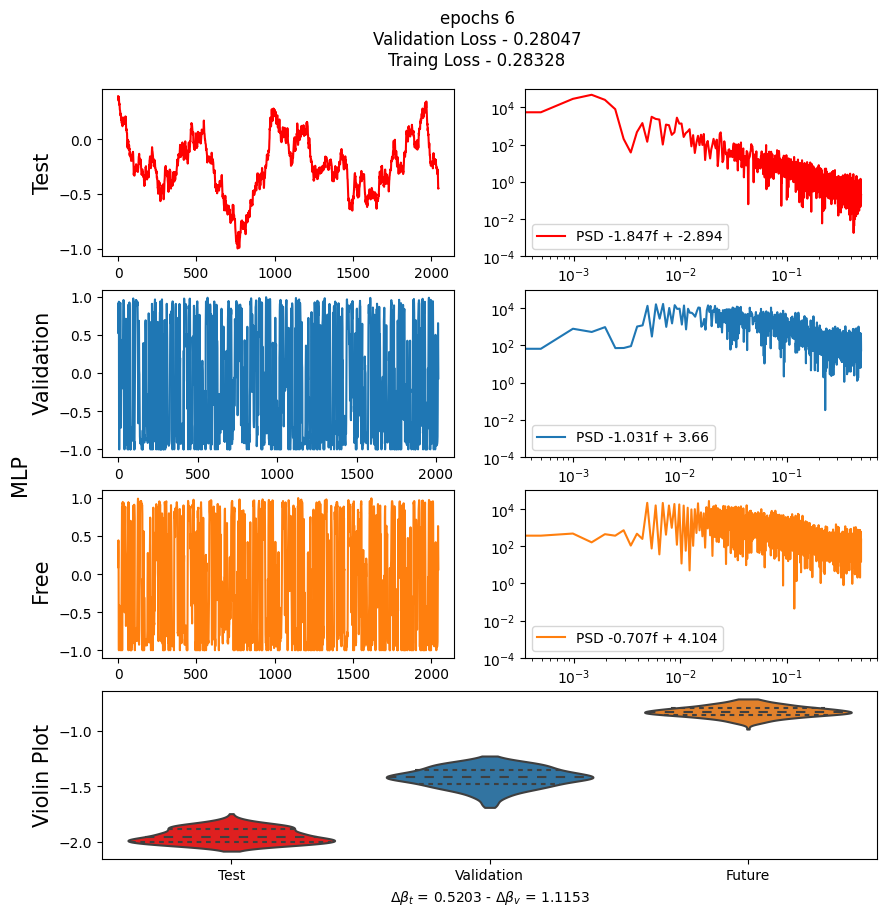

Epoch: 6, Train Loss: 0.28047, Validation Loss: 0.28328, Time 0.673 s


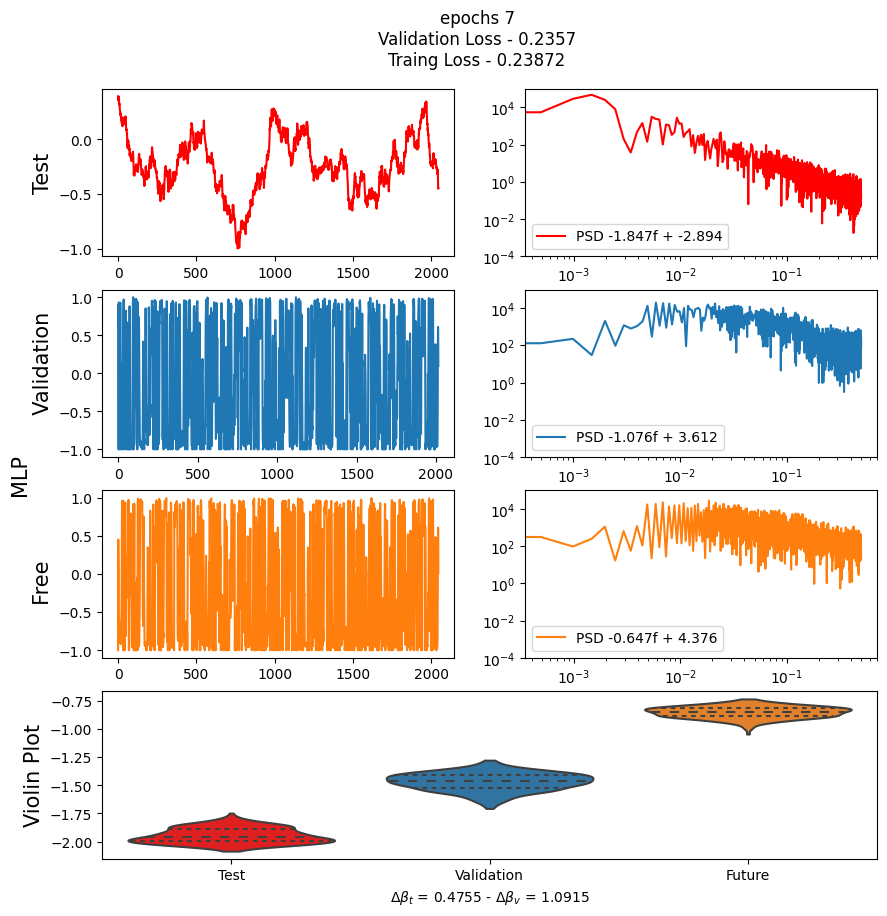

Epoch: 7, Train Loss: 0.2357, Validation Loss: 0.23872, Time 0.699 s


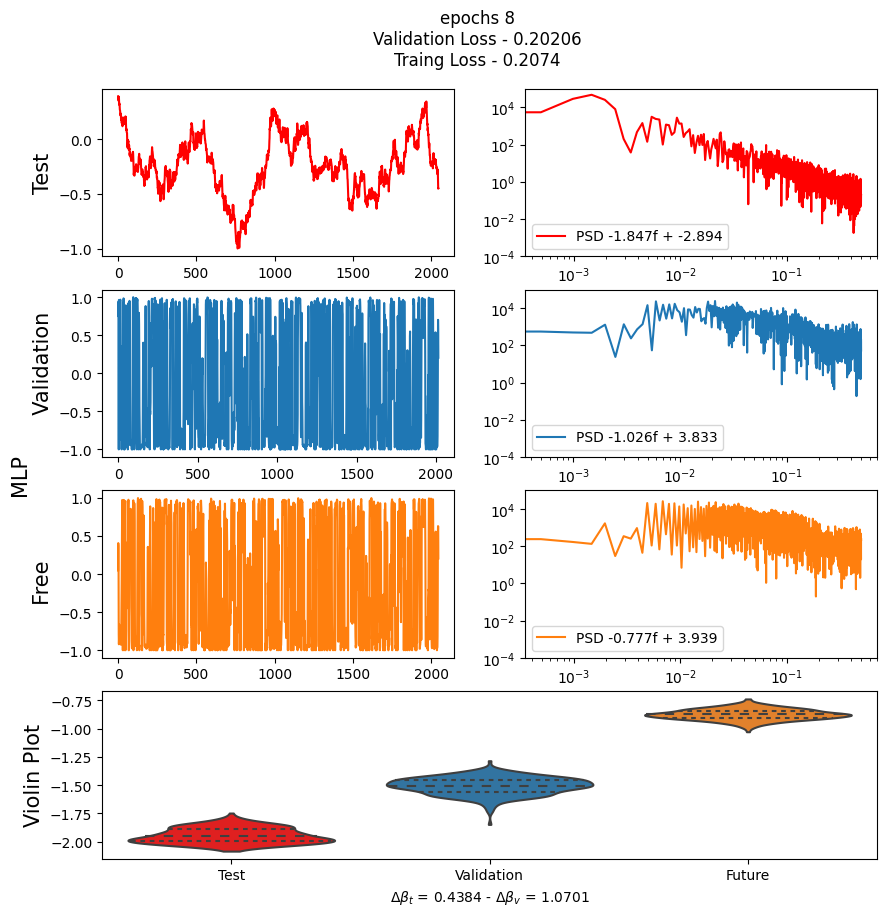

Epoch: 8, Train Loss: 0.20206, Validation Loss: 0.2074, Time 0.643 s


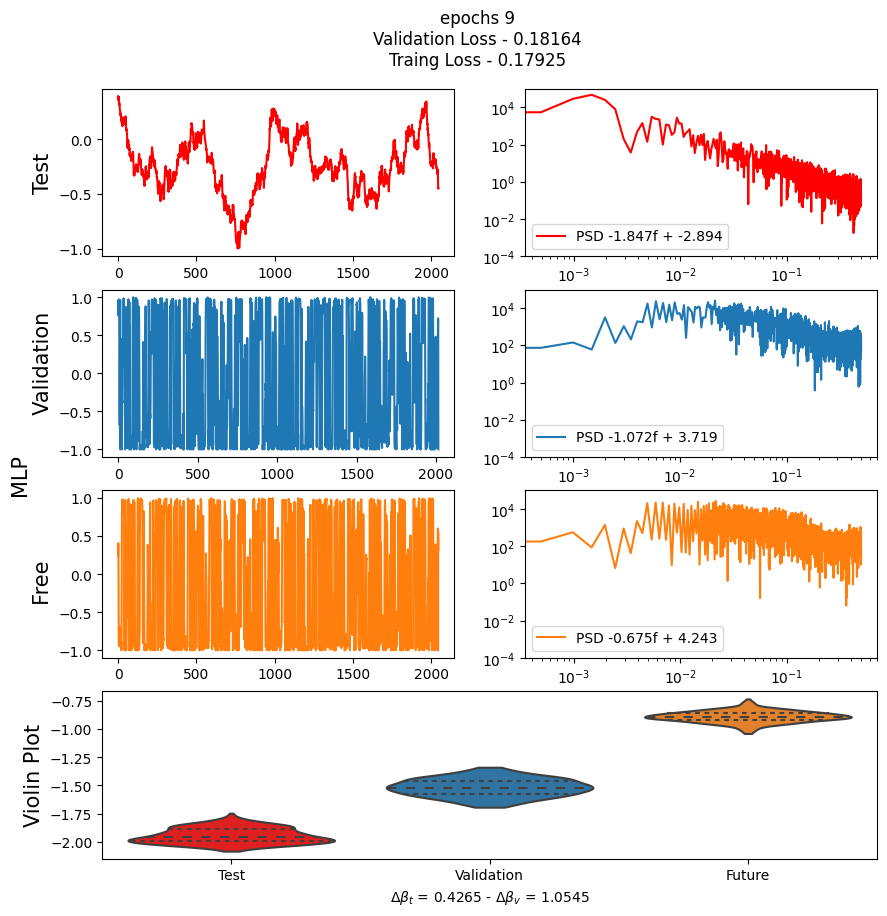

Epoch: 9, Train Loss: 0.18164, Validation Loss: 0.17925, Time 0.69 s


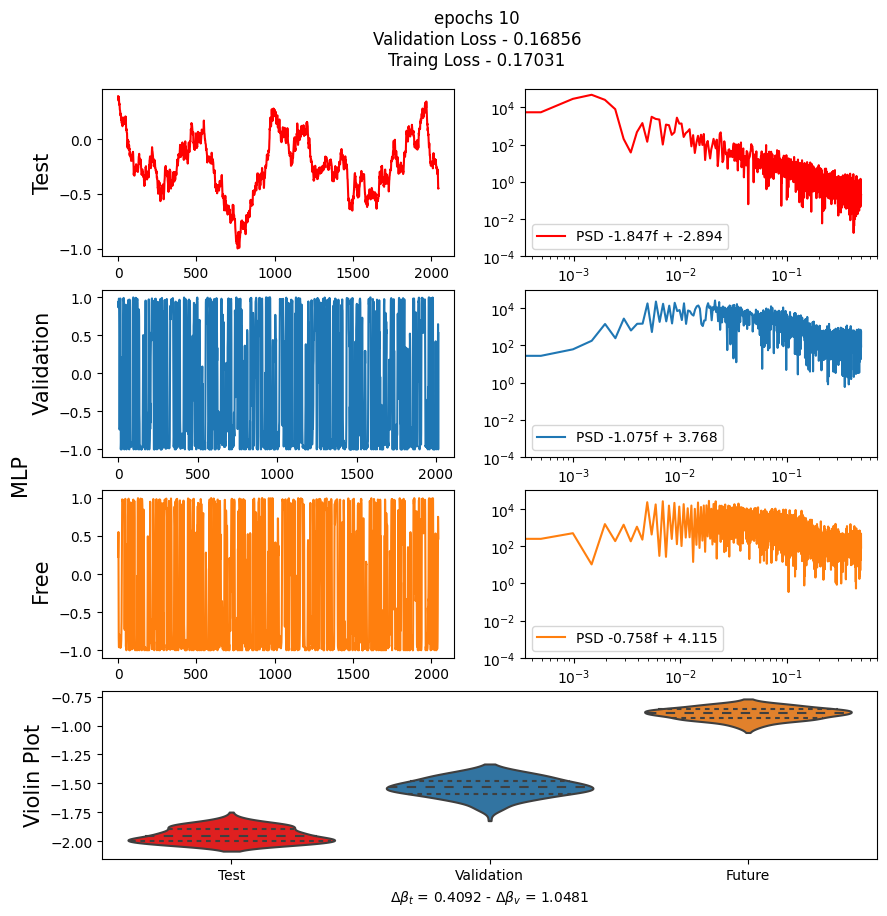

Epoch: 10, Train Loss: 0.16856, Validation Loss: 0.17031, Time 0.651 s


In [53]:
#Parameters
n_cut         = 1
title         = 'MLP'
epochs        = 10
low_freq_cut  = 0
high_freq_cut = 0
train_size    = len(trainX[0])
test_size     = len(trainY[0])
n_layers      = 2
hidden_layers = [857,110,449,2048,848,292]
input_size    = train_size#train_size,
activations   = ['tanh','tanh','sigmoid','sigmoid']#,'relu','tanh','relu'],
dropouts      = [0.105,0.13,0.092,0.065]
isGNI         = True
lr            = 0.001
optimzaer     = 'Adam'


if train_size != test_size: output = abs(len(trainY[0]))#-len(trainX[0]))
else:                       output = abs(len(trainX[0]))

model = MLP(n_layers        = n_layers,
             hidden_layers  = hidden_layers,#,848,292],
             input_size     = train_size,#train_size,
             activations    = activations,
             dropouts       = dropouts,
             isGNI          = isGNI)

l = DBeta(n_cut,
          low_freq_cut=low_freq_cut,
          high_freq_cut=high_freq_cut)
training_loop(epochs,
              model, 
              l, 
              trainX.float(), 
              trainY.float(), 
              trainX_test.float(), 
              trainY_test.float(),
              optimiser                  = optimzaer,
              future                     = len(trainY[0]),
              n_cut                      = n_cut,
              lr                         = lr,
              plot_results_during_traing = True,
              save_results               = True,
              verbose                    = True,
              file_name                  = f'out_{title}_train{train_size}_test{test_size}_beta{beta}.plk')
#SAVING MODELS
if not os.path.exists('saved_models'): os.mkdir('saved_models') #Garanties that the folder exists
torch.save(model,f'saved_models/{title}_{beta}.pth')            #Save the model


### MLP Optuna

In [5]:
import socket

hostname = socket.gethostname()
print("Hostname:", hostname)

Hostname: barauna


In [54]:
day = datetime.date.today()
def objective(trial):
    
    #Hyperparameters bonduaries
    epochs        = 3
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 10
    neuron_max = 20

    drop_max = 0.3
    drop_min = 0.0

    min_layer = 2
    max_layer = 4

    #Hyperparameters to be optimised
    n_layers       = trial.suggest_int('n_layers', min_layer, max_layer)
    n_cut          = trial.suggest_int('n_cut', 1, 4)
    lr             = trial.suggest_float('lr', 1e-4, 5e-1)
    optimiser      = trial.suggest_categorical('optimiser',['LBFGS','SGD','Adam'])
    hidden_layers, activations, dropouts = [],[],[]
    for i in range(max_layer):
        hidden_layers.append(trial.suggest_int(f'hidden_layers{i+1}', neuron_min, neuron_max))
        activations.append(trial.suggest_categorical(f'activations{i+1}',["sigmoid", "relu", "tanh","const"]))
        dropouts.append(trial.suggest_float(f'dropouts{i+1}', drop_min, drop_max))

    if train_size != test_size: output = abs(len(trainY[0]))#-len(trainX[0]))
    else:                       output = abs(len(trainX[0]))

    model = MLP(n_layers = n_layers,
                hidden_layers=hidden_layers,
                input_size = train_size,#train_size,
                activations= activations,
                dropouts   = dropouts,
                #output_size=None, #len(trainX[0]),
                isGNI=False)                                                         

    l = DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = training_loop(epochs,
              model, 
              l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              optimiser = optimiser,
              future=len(trainY[0]),
              n_cut=n_cut,
              lr = lr,
              plot_results_during_traing=False,
              save_results = False,
              verbose = False,
              file_name=f'out_{title}_train{train_size}_test{test_size}_beta{beta}_.plk')
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2,n_jobs=2)

print('Number of finished trials:', len(study.trials))
print(f'Best trial:',study.best_trial.params)

[I 2023-05-02 18:19:27,004] A new study created in memory with name: no-name-df64b064-1f0d-465c-bec6-5e8511025fed
[I 2023-05-02 18:19:31,454] Trial 0 finished with value: 2.1309900283813477 and parameters: {'n_layers': 4, 'n_cut': 1, 'lr': 0.38223636311958653, 'optimiser': 'SGD', 'hidden_layers1': 12, 'activations1': 'relu', 'dropouts1': 0.023784387922392746, 'hidden_layers2': 12, 'activations2': 'relu', 'dropouts2': 0.02585102591028301, 'hidden_layers3': 12, 'activations3': 'const', 'dropouts3': 0.10560794144139754, 'hidden_layers4': 10, 'activations4': 'const', 'dropouts4': 0.1401864905823723}. Best is trial 0 with value: 2.1309900283813477.
[I 2023-05-02 18:19:31,463] Trial 1 finished with value: 1.594895362854004 and parameters: {'n_layers': 2, 'n_cut': 1, 'lr': 0.467314283550629, 'optimiser': 'Adam', 'hidden_layers1': 18, 'activations1': 'sigmoid', 'dropouts1': 0.031948096787294246, 'hidden_layers2': 12, 'activations2': 'const', 'dropouts2': 0.026259115241774555, 'hidden_layers3':

Number of finished trials: 2
Best trial: {'n_layers': 2, 'n_cut': 1, 'lr': 0.467314283550629, 'optimiser': 'Adam', 'hidden_layers1': 18, 'activations1': 'sigmoid', 'dropouts1': 0.031948096787294246, 'hidden_layers2': 12, 'activations2': 'const', 'dropouts2': 0.026259115241774555, 'hidden_layers3': 16, 'activations3': 'tanh', 'dropouts3': 0.015095740657689248, 'hidden_layers4': 11, 'activations4': 'const', 'dropouts4': 0.16411128526922067}


## E2 - RNN

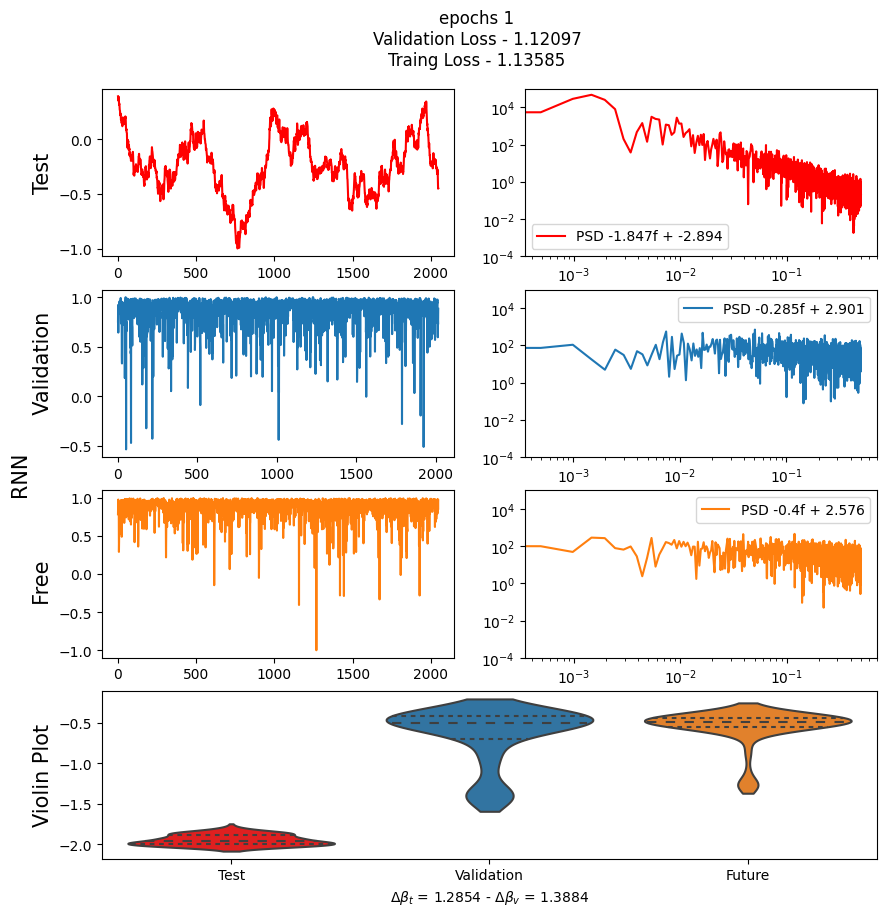

Epoch: 1, Train Loss: 1.12097, Validation Loss: 1.13585, Time 1.057 min


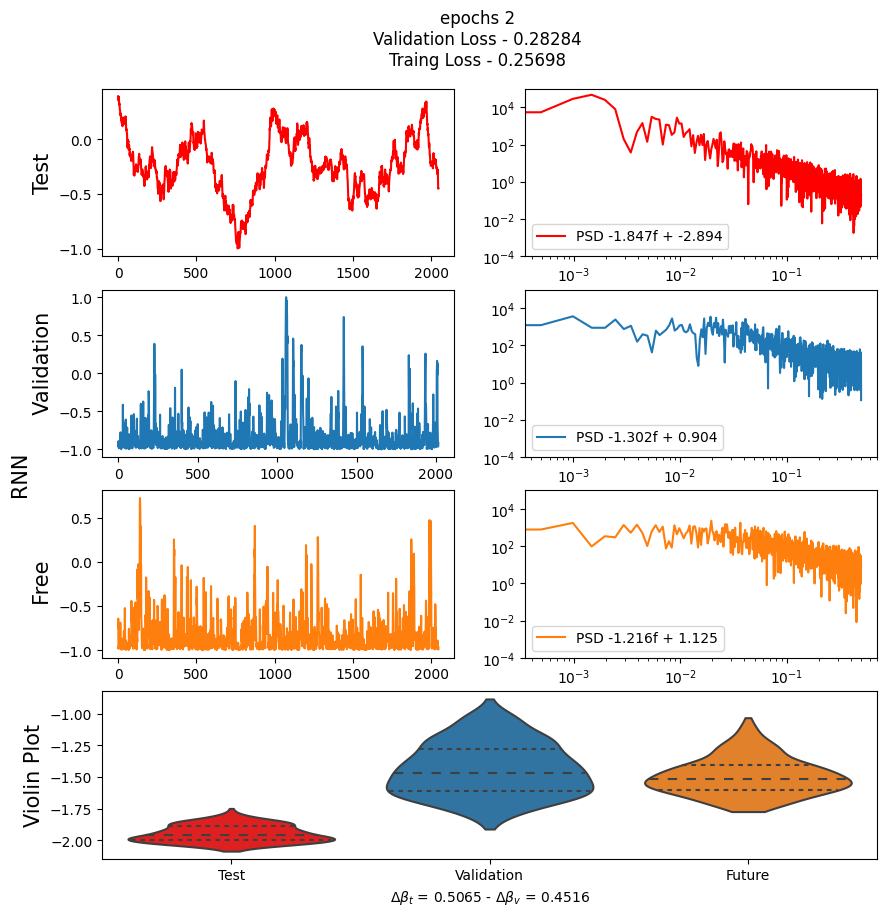

Epoch: 2, Train Loss: 0.28284, Validation Loss: 0.25698, Time 1.033 min


In [55]:
n_cut         = 1
epochs        = 3
low_freq_cut  = 0
high_freq_cut = 0

model = RNN(n_layers           = 3, 
                 hidden_layers = [8,16,32,64,54],
                 dropouts      = [0.1,0.2,0.3,0.1,0],
                 isGNI         = True)
title = 'RNN'

#optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)#,momentum=0.9)
#optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9)
l = DBeta(n_cut,
          low_freq_cut  = low_freq_cut,
          high_freq_cut = high_freq_cut)

training_loop(epochs,
              model, l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              optimiser = 'LBFGS',
              future=len(trainY[0]),
              n_cut=n_cut,
              lr = 0.01,
              plot_results_during_traing=True,
              save_results = True,
              verbose = True,
              file_name=f'RESULTS_{day}_{title}_ncut{n_cut}_.plk')
              

### RNN Optuna

In [ ]:
#day = datetime.date.today()

def objective(trial):
    data1 = torch.load(f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
    trainX, trainY, trainX_test,trainY_test = data1[beta][0],data1[beta][1],data1[beta][2],data1[beta][3]
    train_size = len(trainX[0])
    test_size =  len(trainY[0])
    title = 'RNN'
    epochs        = 10
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 8
    neuron_max = 32

    drop_max = 0.3
    drop_min = 0.0

    n_layers       = trial.suggest_int('n_layers', 1, 4)
    n_cut          = trial.suggest_int('n_cut', 1, 5)
    lr             = trial.suggest_float('lr', 1e-4, 5e-1)
    optimiser      = trial.suggest_categorical('optimiser',['LBFGS','SGD','Adam'])

    hidden_layers1 = trial.suggest_int('hidden_layers1', neuron_min, neuron_max)
    hidden_layers2 = trial.suggest_int('hidden_layers2', neuron_min, neuron_max)
    hidden_layers3 = trial.suggest_int('hidden_layers3', neuron_min, neuron_max)
    hidden_layers4 = trial.suggest_int('hidden_layers4', neuron_min, neuron_max)

    activations1    = trial.suggest_categorical('activations1',["sigmoid", "relu", "tanh","const"])
    activations2    = trial.suggest_categorical('activations2',["sigmoid", "relu", "tanh","const"])
    activations3    = trial.suggest_categorical('activations3',["sigmoid", "relu", "tanh","const"])
    activations4    = trial.suggest_categorical('activations4',["sigmoid", "relu", "tanh","const"])

    dropout1       = trial.suggest_float('dropout1', drop_min, drop_max)
    dropout2       = trial.suggest_float('dropout2', drop_min, drop_max)
    dropout3       = trial.suggest_float('dropout3', drop_min, drop_max)
    dropout4       = trial.suggest_float('dropout4', drop_min, drop_max)

    model = RNN(n_layers       = n_layers,
               hidden_layers   = [hidden_layers1,hidden_layers2,hidden_layers3, hidden_layers4],#hidden_layers5,hidden_layers6,hidden_layers7,hidden_layers8,hidden_layers9,hidden_layers0],
               activations     = [activations1,activations2,activations3,activations4],#activations5,activations6,activations7,activations8,activations9,activations0],
               dropouts        = [dropout1,dropout2,dropout3,dropout4],#dropout5,dropout6,dropout7,dropout8,dropout9,dropout0],                    
               isGNI=True)

    l = DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = training_loop(epochs,
                         model, 
                         l, 
                         trainX.float(), trainY.float(), 
                         trainX_test.float(), trainY_test.float(),
                         optimiser = optimiser,
                         future=len(trainY[0]),
                         n_cut=n_cut,
                         lr = lr,
                         plot_results_during_traing=False,
                         save_results = False,
                         verbose = False,
                         file_name=f'out_{title}_t{trial.number}_train{train_size}_test{test_size}_beta{beta}_ncut{n_cut}.plk')
    
    return loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5,n_jobs=1)

print('Number of finished trials:', len(study.trials))
print(f'Best trial:',study.best_trial.params)    

[I 2023-01-10 09:54:25,534] A new study created in memory with name: no-name-5b9d7a28-50d1-4fc6-aa15-13a3c84b6c9b
[I 2023-01-10 09:56:13,279] Trial 0 finished with value: 295.242431640625 and parameters: {'n_layers': 1, 'n_cut': 3, 'lr': 0.11001346346572603, 'optimiser': 'LBFGS', 'hidden_layers1': 13, 'hidden_layers2': 12, 'hidden_layers3': 18, 'hidden_layers4': 11, 'activations1': 'const', 'activations2': 'tanh', 'activations3': 'tanh', 'activations4': 'tanh', 'dropout1': 0.25512919846421844, 'dropout2': 0.13063009022377747, 'dropout3': 0.09691007441292811, 'dropout4': 0.050618388908621845}. Best is trial 0 with value: 295.242431640625.
[I 2023-01-10 09:56:31,188] Trial 1 finished with value: 6.248775959014893 and parameters: {'n_layers': 1, 'n_cut': 1, 'lr': 0.032371230569003984, 'optimiser': 'Adam', 'hidden_layers1': 18, 'hidden_layers2': 32, 'hidden_layers3': 30, 'hidden_layers4': 20, 'activations1': 'relu', 'activations2': 'sigmoid', 'activations3': 'tanh', 'activations4': 'tanh',

Number of finished trials: 5
Best trial: {'n_layers': 1, 'n_cut': 4, 'lr': 0.4216419966825098, 'optimiser': 'LBFGS', 'hidden_layers1': 29, 'hidden_layers2': 31, 'hidden_layers3': 32, 'hidden_layers4': 26, 'activations1': 'const', 'activations2': 'sigmoid', 'activations3': 'sigmoid', 'activations4': 'tanh', 'dropout1': 0.029758468055035334, 'dropout2': 0.007478941760875046, 'dropout3': 0.05917558865279555, 'dropout4': 0.017247744099431948}


In [ ]:
i = 0
x = df[~df.trainX.isnull()].trainX
y = df[~df.trainY.isnull()].trainY
z = df[~df[f'out{i+1}'].isnull()][f'out{i+1}']
w = df[~df[f'fut{i+1}'].isnull()][f'fut{i+1}']
plot_results(x,y,z,w,32,i)

## E3 - LSTM

In [ ]:
import numpy as np
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    median = np.nanmedian([np.NaN, np.NaN])
    print(median)

nan


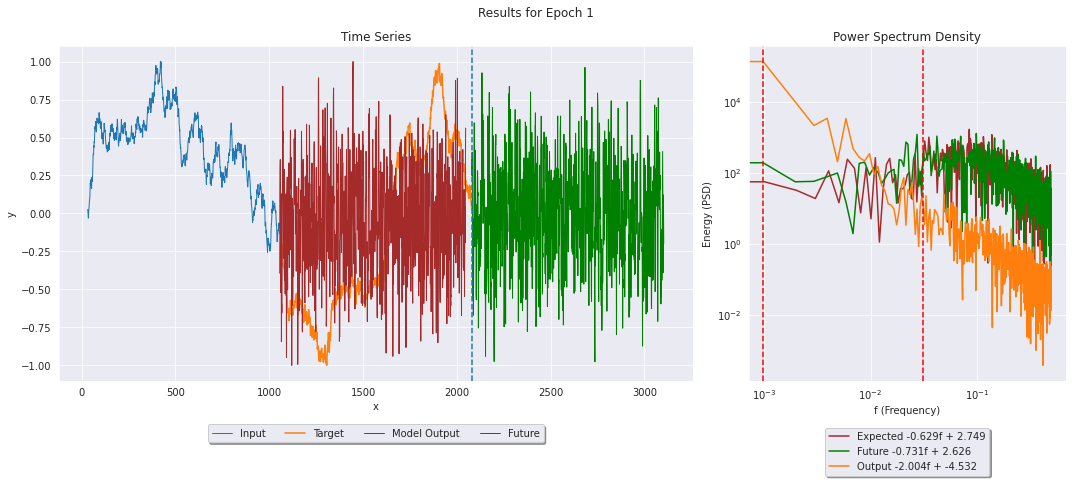

Epoch: 1, Train Loss: 0.92586, Validation Loss: 0.9988, Time 46.522 s


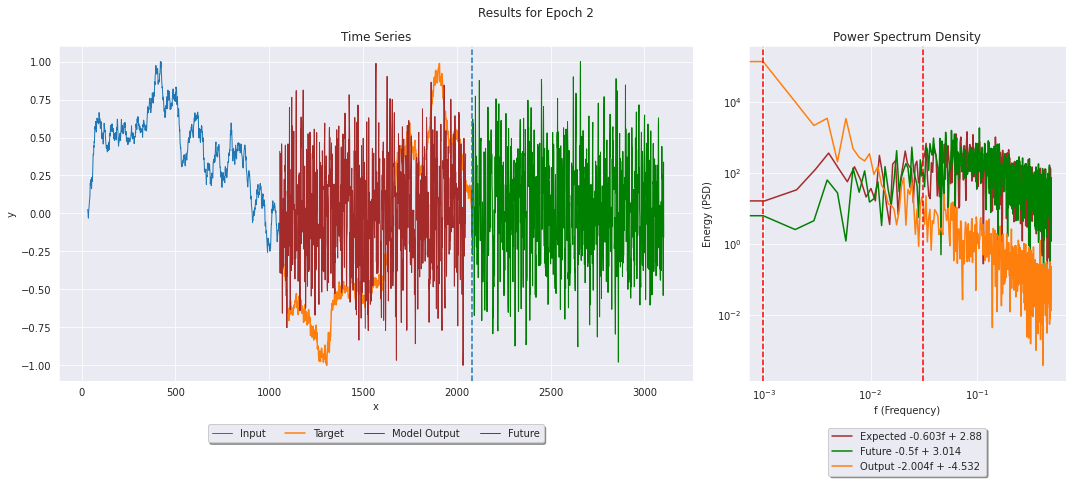

Epoch: 2, Train Loss: 1.09522, Validation Loss: 0.82766, Time 10.71 s


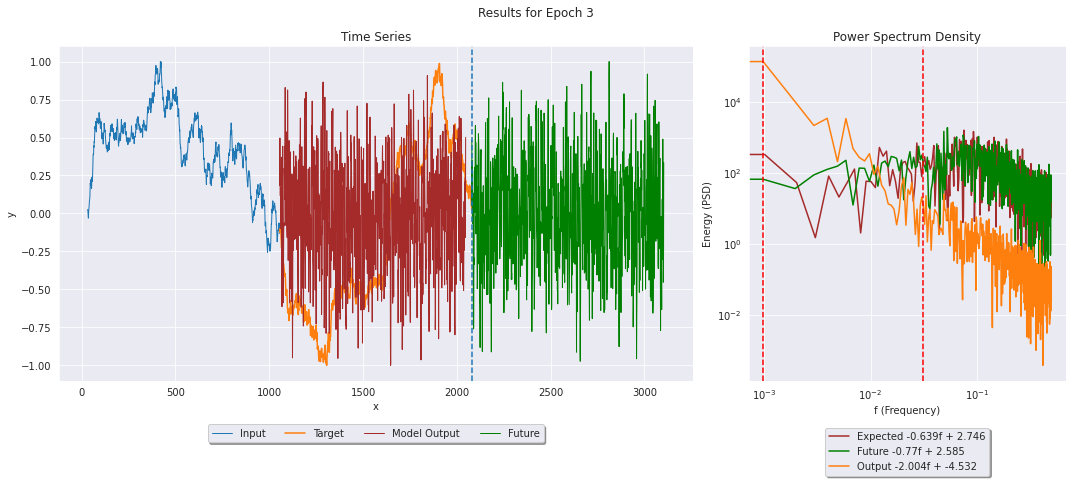

Epoch: 3, Train Loss: 1.15453, Validation Loss: 1.07293, Time 7.88 s


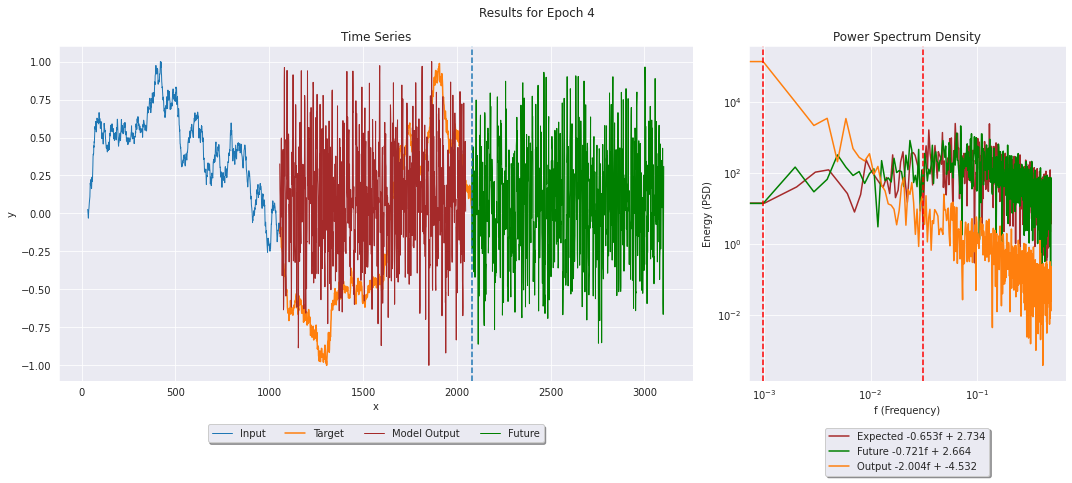

Epoch: 4, Train Loss: 1.0354, Validation Loss: 0.94177, Time 5.558 s


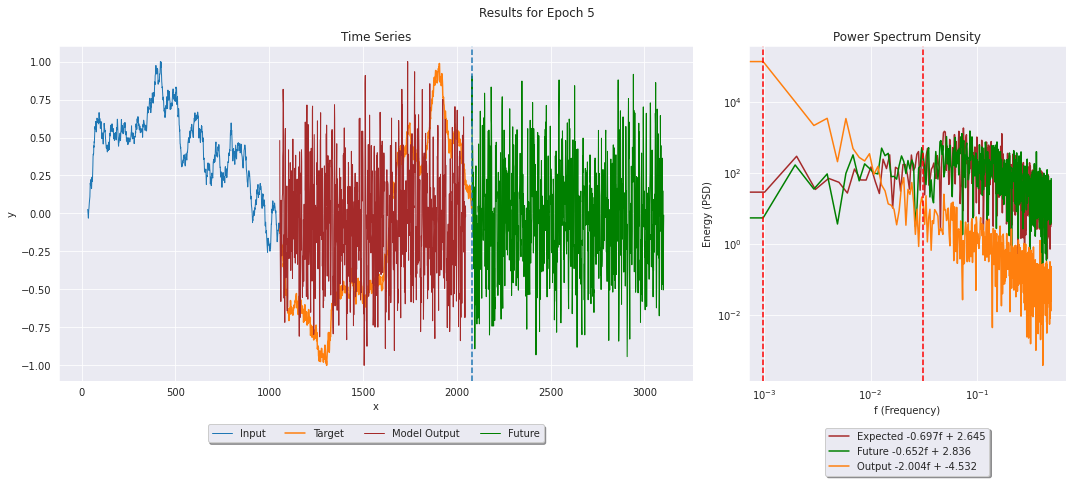

Epoch: 5, Train Loss: 1.15519, Validation Loss: 1.01328, Time 7.871 s


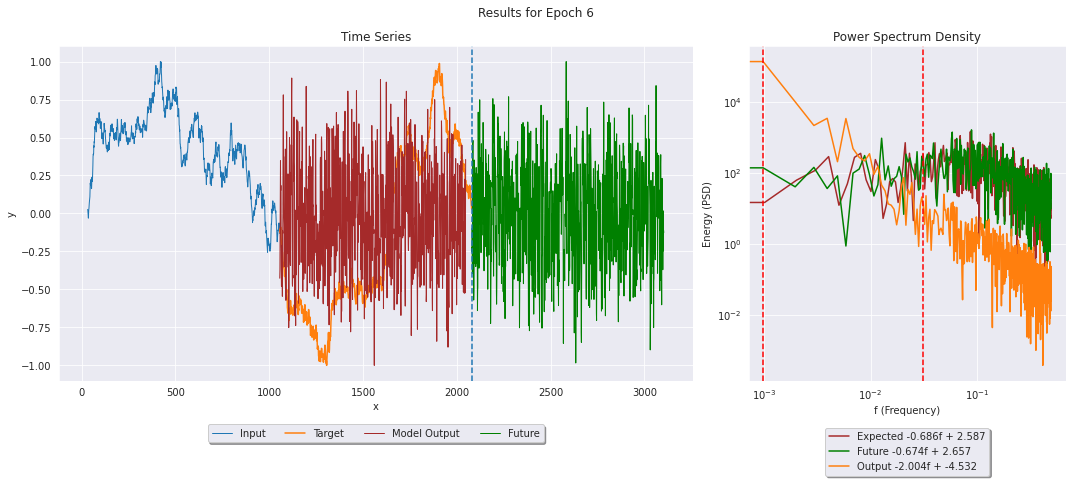

Epoch: 6, Train Loss: 1.09241, Validation Loss: 1.12407, Time 9.127 s


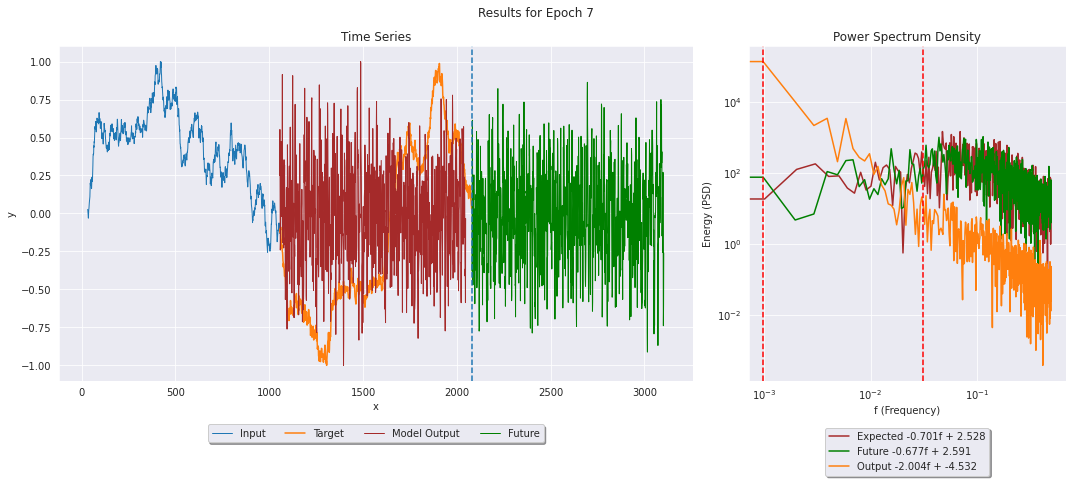

Epoch: 7, Train Loss: 1.22033, Validation Loss: 0.90284, Time 5.476 s


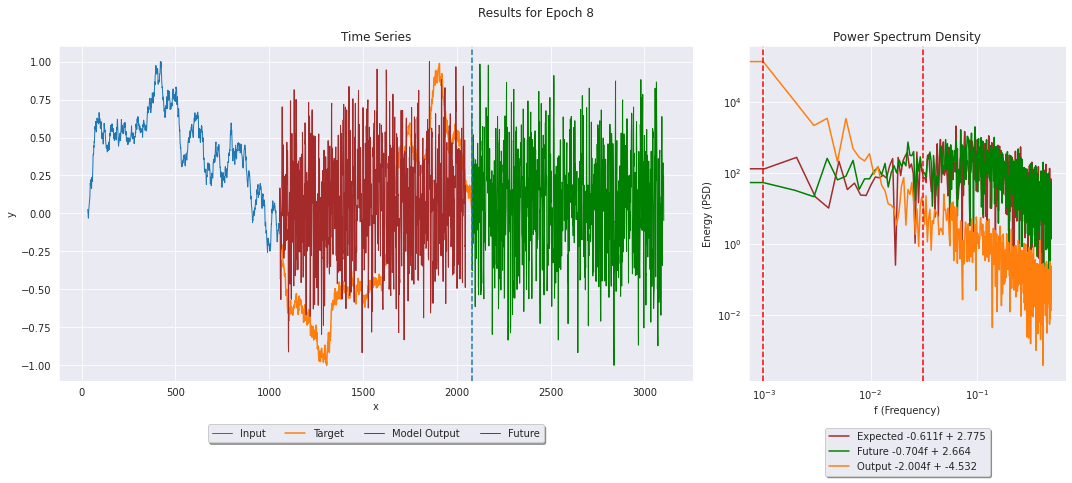

Epoch: 8, Train Loss: 1.19732, Validation Loss: 1.09024, Time 8.053 s


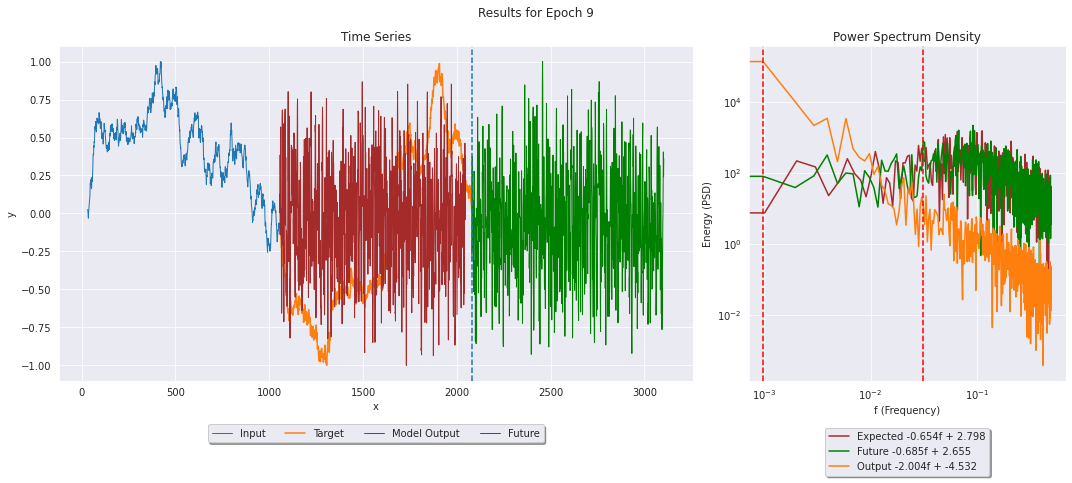

Epoch: 9, Train Loss: 0.9876, Validation Loss: 0.64157, Time 8.105 s


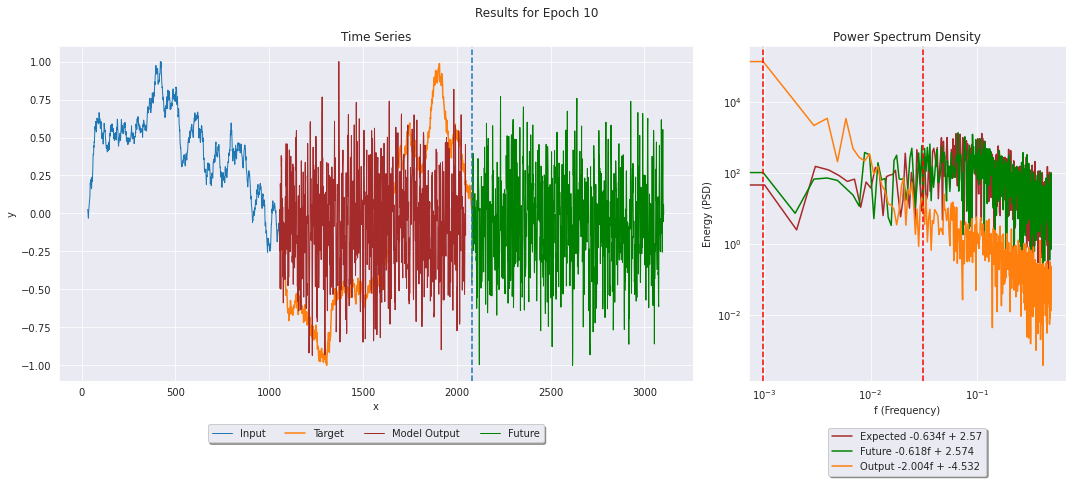

Epoch: 10, Train Loss: 1.0554, Validation Loss: 1.28077, Time 7.991 s


array(1.280765, dtype=float32)

In [ ]:
n_cut         = 2
epochs        = 10
low_freq_cut  = 0
high_freq_cut = 0
#model = LSTM_GNI(hidden_layers=32,isGNI=False)
model = LSTM(n_layers      = 2, 
                 hidden_layers = [64,64,32,64,54],
                 dropouts      = [0.0,0.0,0.0,0.1,0],
                 isGNI         = True)
title = 'LSTM'

#optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)#,momentum=0.9)
#optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9)
l = DBeta(n_cut,
          low_freq_cut  = low_freq_cut,
          high_freq_cut = high_freq_cut)

training_loop(epochs,
              model, l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              optimiser = 'LBFGS',
              future=len(trainY[0]),
              n_cut=n_cut,
              lr = 0.01,
              plot_results_during_traing=True,
              save_results = True,
              verbose = True,
              file_name=f'RESULTS_{day}_{title}_ncut{n_cut}_.plk')
              

### LSTM Optuna

In [ ]:
day = datetime.date.today()

def objective(trial):
    title = 'LSTM'
    epochs        = 3
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 32
    neuron_max = 34

    drop_max = 0.3
    drop_min = 0.0

    n_layers       = trial.suggest_int('n_layers', 1, 2)
    n_cut          = trial.suggest_int('n_cut', 1, 2)
    lr             = trial.suggest_float('lr', 1e-4, 5e-1)
    optimiser      = trial.suggest_categorical('optimiser',['LBFGS','SGD','Adam'])

    hidden_layers1 = trial.suggest_int('hidden_layers1', neuron_min, neuron_max)
    hidden_layers2 = trial.suggest_int('hidden_layers2', neuron_min, neuron_max)
    hidden_layers3 = trial.suggest_int('hidden_layers3', neuron_min, neuron_max)
    hidden_layers4 = trial.suggest_int('hidden_layers4', neuron_min, neuron_max)
    hidden_layers5 = trial.suggest_int('hidden_layers5', neuron_min, neuron_max)
    hidden_layers6 = trial.suggest_int('hidden_layers6', neuron_min, neuron_max)
    hidden_layers7 = trial.suggest_int('hidden_layers7', neuron_min, neuron_max)
    hidden_layers8 = trial.suggest_int('hidden_layers8', neuron_min, neuron_max)
    hidden_layers9 = trial.suggest_int('hidden_layers9', neuron_min, neuron_max)
    hidden_layers0 = trial.suggest_int('hidden_layers0', neuron_min, neuron_max)

    activations1    = trial.suggest_categorical('activations1',["sigmoid", "relu", "tanh","const"])
    activations2    = trial.suggest_categorical('activations2',["sigmoid", "relu", "tanh","const"])
    activations3    = trial.suggest_categorical('activations3',["sigmoid", "relu", "tanh","const"])
    activations4    = trial.suggest_categorical('activations4',["sigmoid", "relu", "tanh","const"])
    activations5    = trial.suggest_categorical('activations5',["sigmoid", "relu", "tanh","const"])
    activations6    = trial.suggest_categorical('activations6',["sigmoid", "relu", "tanh","const"])
    activations7    = trial.suggest_categorical('activations7',["sigmoid", "relu", "tanh","const"])
    activations8    = trial.suggest_categorical('activations8',["sigmoid", "relu", "tanh","const"])
    activations9    = trial.suggest_categorical('activations9',["sigmoid", "relu", "tanh","const"])
    activations0    = trial.suggest_categorical('activations0',["sigmoid", "relu", "tanh","const"])
    activations5    = trial.suggest_categorical('activations5',["sigmoid", "relu", "tanh","const"])

    dropout1       = trial.suggest_float('dropout1', drop_min, drop_max)
    dropout2       = trial.suggest_float('dropout2', drop_min, drop_max)
    dropout3       = trial.suggest_float('dropout3', drop_min, drop_max)
    dropout4       = trial.suggest_float('dropout4', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)
    dropout6       = trial.suggest_float('dropout6', drop_min, drop_max)
    dropout7       = trial.suggest_float('dropout7', drop_min, drop_max)
    dropout8       = trial.suggest_float('dropout8', drop_min, drop_max)
    dropout9       = trial.suggest_float('dropout9', drop_min, drop_max)
    dropout0       = trial.suggest_float('dropout0', drop_min, drop_max)

    model = LSTM(n_layers       = n_layers,
               hidden_layers   = [hidden_layers1,hidden_layers2,hidden_layers3, hidden_layers4,hidden_layers5,hidden_layers6,hidden_layers7,hidden_layers8,hidden_layers9,hidden_layers0],
               activations     = [activations1,activations2,activations3,activations4,activations5,activations6,activations7,activations8,activations9,activations0],
               dropouts        = [dropout1,dropout2,dropout3,dropout4,dropout5,dropout6,dropout7,dropout8,dropout9,dropout0],                    
               isGNI=True)

    l = DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = training_loop(epochs,
                         model, 
                         l, 
                         trainX.float(), trainY.float(), 
                         trainX_test.float(), trainY_test.float(),
                         optimiser = optimiser[0],
                         future=len(trainY[0]),
                         n_cut=n_cut,
                         lr = lr,
                         plot_results_during_traing=False,
                         save_results = True,
                         verbose = False,
                         file_name=f'out_{title}_t{trial.number}_train{train_size}_test{test_size}_beta{beta}_ncut{n_cut}.plk')    
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5,n_jobs=1)

print('Number of finished trials:', len(study.trials))
print(f'Best trial:',study.best_trial.params)

[I 2023-01-05 20:29:55,960] A new study created in memory with name: no-name-0b56ca76-78fa-47f6-baed-b340d67d742b
[W 2023-01-05 20:29:56,004] Trial 0 failed because of the following error: UnboundLocalError("local variable 'optimiser2' referenced before assignment")
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-48-88573bddcf9c>", line 65, in objective
    loss = training_loop(epochs,
  File "<ipython-input-24-f1738c3a1a57>", line 52, in training_loop
    optimiser2.step(closure) #Call the funcution
UnboundLocalError: local variable 'optimiser2' referenced before assignment


UnboundLocalError: ignored

## E4 - GRU

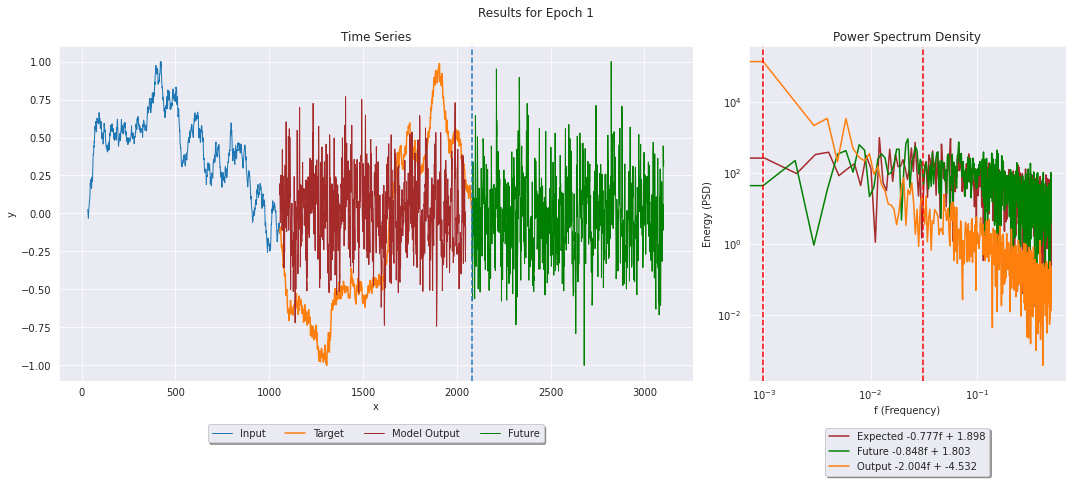

Epoch: 1, Train Loss: 2.03393, Validation Loss: 1.6903, Time 22.081 s


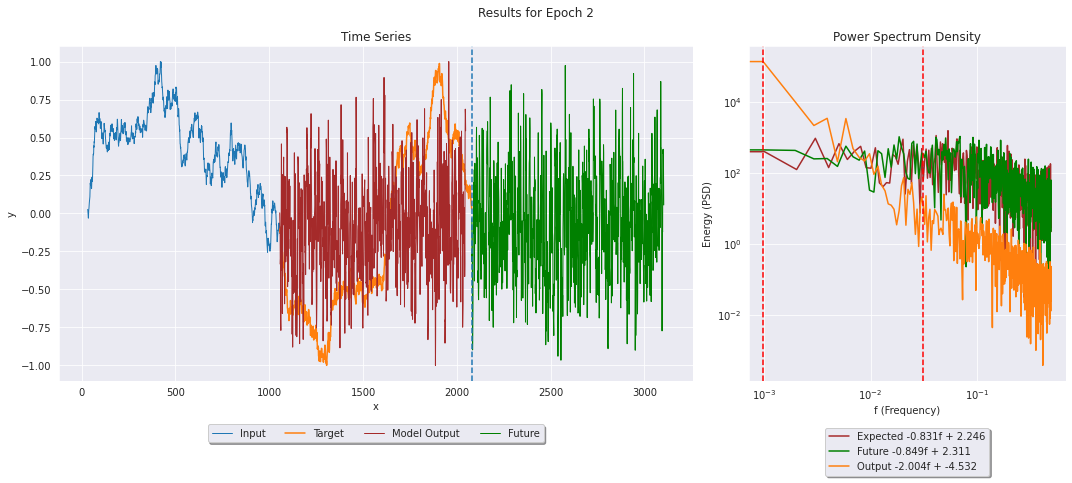

Epoch: 2, Train Loss: 2.31399, Validation Loss: 1.35931, Time 10.358 s


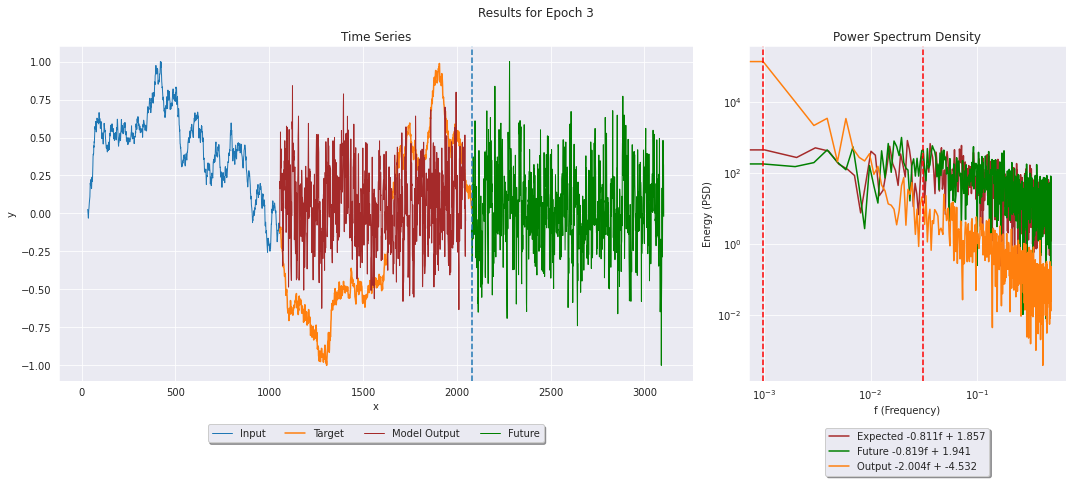

Epoch: 3, Train Loss: 0.80358, Validation Loss: 2.1934, Time 7.794 s


array(2.193404, dtype=float32)

In [ ]:
n_cut         = 2
epochs        = 3
low_freq_cut  = 0
high_freq_cut = 0
#model = RNN_GNI(hidden_layers=32,isGNI=False)
model = GRU(n_layers      = 2, 
                 hidden_layers = [64,64,64,64,54],
                 dropouts      = [0.1,0.1,0.1,0.1,0],
                 isGNI         = True)
title = 'GRU'

#optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)#,momentum=0.9)
#optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9)
l = DBeta(n_cut,
          low_freq_cut  = low_freq_cut,
          high_freq_cut = high_freq_cut)

training_loop(epochs,
              model, l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              optimiser = 'LBFGS',
              future=len(trainY[0]),
              n_cut=n_cut,
              lr = 0.01,
              plot_results_during_traing=True,
              save_results = True,
              verbose = True,
              file_name=f'RESULTS_{day}_{title}_ncut{n_cut}_.plk')
              

### GRU Optuna



In [ ]:
day = datetime.date.today()

def objective(trial):
    title = 'RNN'
    epochs        = 3
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 32
    neuron_max = 34

    drop_max = 0.3
    drop_min = 0.0

    n_layers       = trial.suggest_int('n_layers', 1, 2)
    n_cut          = trial.suggest_int('n_cut', 1, 2)
    lr             = trial.suggest_float('lr', 1e-4, 5e-1)
    optimiser      = trial.suggest_categorical('optimiser',['LBFGS','SGD','Adam'])

    hidden_layers1 = trial.suggest_int('hidden_layers1', neuron_min, neuron_max)
    hidden_layers2 = trial.suggest_int('hidden_layers2', neuron_min, neuron_max)
    hidden_layers3 = trial.suggest_int('hidden_layers3', neuron_min, neuron_max)
    hidden_layers4 = trial.suggest_int('hidden_layers4', neuron_min, neuron_max)
    hidden_layers5 = trial.suggest_int('hidden_layers5', neuron_min, neuron_max)
    hidden_layers6 = trial.suggest_int('hidden_layers6', neuron_min, neuron_max)
    hidden_layers7 = trial.suggest_int('hidden_layers7', neuron_min, neuron_max)
    hidden_layers8 = trial.suggest_int('hidden_layers8', neuron_min, neuron_max)
    hidden_layers9 = trial.suggest_int('hidden_layers9', neuron_min, neuron_max)
    hidden_layers0 = trial.suggest_int('hidden_layers0', neuron_min, neuron_max)

    activations1    = trial.suggest_categorical('activations1',["sigmoid", "relu", "tanh","const"])
    activations2    = trial.suggest_categorical('activations2',["sigmoid", "relu", "tanh","const"])
    activations3    = trial.suggest_categorical('activations3',["sigmoid", "relu", "tanh","const"])
    activations4    = trial.suggest_categorical('activations4',["sigmoid", "relu", "tanh","const"])
    activations5    = trial.suggest_categorical('activations5',["sigmoid", "relu", "tanh","const"])
    activations6    = trial.suggest_categorical('activations6',["sigmoid", "relu", "tanh","const"])
    activations7    = trial.suggest_categorical('activations7',["sigmoid", "relu", "tanh","const"])
    activations8    = trial.suggest_categorical('activations8',["sigmoid", "relu", "tanh","const"])
    activations9    = trial.suggest_categorical('activations9',["sigmoid", "relu", "tanh","const"])
    activations0    = trial.suggest_categorical('activations0',["sigmoid", "relu", "tanh","const"])
    activations5    = trial.suggest_categorical('activations5',["sigmoid", "relu", "tanh","const"])

    dropout1       = trial.suggest_float('dropout1', drop_min, drop_max)
    dropout2       = trial.suggest_float('dropout2', drop_min, drop_max)
    dropout3       = trial.suggest_float('dropout3', drop_min, drop_max)
    dropout4       = trial.suggest_float('dropout4', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)
    dropout6       = trial.suggest_float('dropout6', drop_min, drop_max)
    dropout7       = trial.suggest_float('dropout7', drop_min, drop_max)
    dropout8       = trial.suggest_float('dropout8', drop_min, drop_max)
    dropout9       = trial.suggest_float('dropout9', drop_min, drop_max)
    dropout0       = trial.suggest_float('dropout0', drop_min, drop_max)

    model = GRU(n_layers       = n_layers,
               hidden_layers   = [hidden_layers1,hidden_layers2,hidden_layers3, hidden_layers4,hidden_layers5,hidden_layers6,hidden_layers7,hidden_layers8,hidden_layers9,hidden_layers0],
               activations     = [activations1,activations2,activations3,activations4,activations5,activations6,activations7,activations8,activations9,activations0],
               dropouts        = [dropout1,dropout2,dropout3,dropout4,dropout5,dropout6,dropout7,dropout8,dropout9,dropout0],                    
               isGNI=True)

    l = DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = training_loop(epochs,
                         model, 
                         l, 
                         trainX.float(), trainY.float(), 
                         trainX_test.float(), trainY_test.float(),
                         optimiser = optimiser[0],
                         future=len(trainY[0]),
                         n_cut=n_cut,
                         lr = lr,
                         plot_results_during_traing=False,
                         save_results = True,
                         verbose = False,
                         file_name=f'out_{title}_t{trial.number}_train{train_size}_test{test_size}_beta{beta}_ncut{n_cut}.plk')
    
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5,n_jobs=5)

print('Number of finished trials:', len(study.trials))
print(f'Best trial:',study.best_trial.params)

[I 2022-11-16 15:07:25,313] A new study created in memory with name: no-name-129b4bbd-e34b-4ec8-b772-d52ca47eee49
[I 2022-11-16 15:08:53,058] Trial 0 finished with value: 5.3263020515441895 and parameters: {'n_layers': 2, 'n_cut': 1, 'hidden_layers1': 34, 'hidden_layers2': 34, 'hidden_layers3': 33, 'hidden_layers4': 32, 'hidden_layers5': 33, 'dropout1': 0.45093931585979297, 'dropout2': 0.4932919972803247, 'dropout3': 0.5484001088831199, 'dropout4': 0.7177100393395979, 'dropout5': 0.56312000175935, 'lr': 0.18639850087226237}. Best is trial 0 with value: 5.3263020515441895.
[I 2022-11-16 15:10:05,170] Trial 1 finished with value: 0.5207642912864685 and parameters: {'n_layers': 2, 'n_cut': 1, 'hidden_layers1': 33, 'hidden_layers2': 32, 'hidden_layers3': 34, 'hidden_layers4': 33, 'hidden_layers5': 34, 'dropout1': 0.11107990530498846, 'dropout2': 0.3218577889005734, 'dropout3': 0.5193328376347065, 'dropout4': 0.17946892246480403, 'dropout5': 0.4844101568154005, 'lr': 0.47541285770012726}. B

Number of finished trials: 10
Best trial: {'n_layers': 2, 'n_cut': 1, 'hidden_layers1': 33, 'hidden_layers2': 32, 'hidden_layers3': 34, 'hidden_layers4': 33, 'hidden_layers5': 34, 'dropout1': 0.11107990530498846, 'dropout2': 0.3218577889005734, 'dropout3': 0.5193328376347065, 'dropout4': 0.17946892246480403, 'dropout5': 0.4844101568154005, 'lr': 0.47541285770012726}


## E5 - CNN

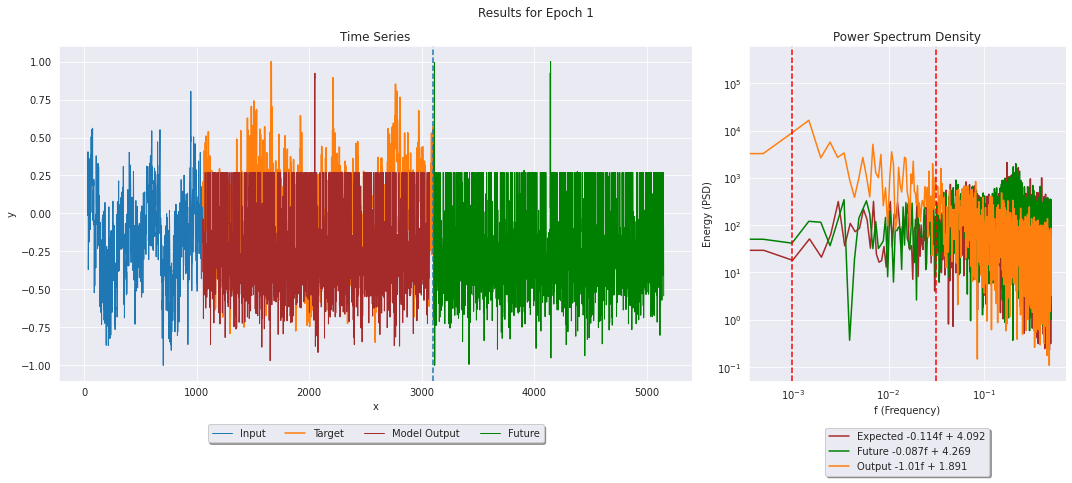

Epoch: 1, Train Loss: 0.43201, Validation Loss: 0.41476, Time 8.419 s


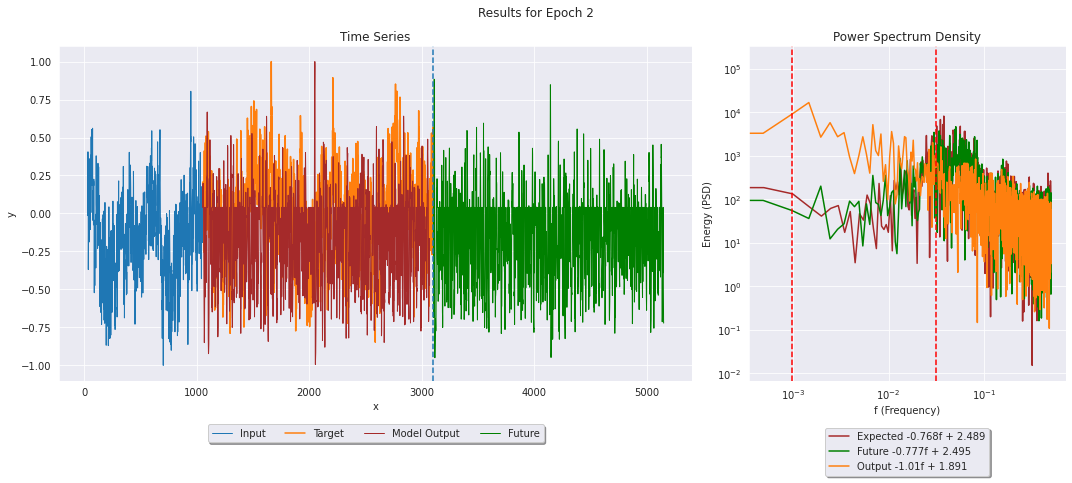

Epoch: 2, Train Loss: 0.34557, Validation Loss: 0.4331, Time 8.675 s


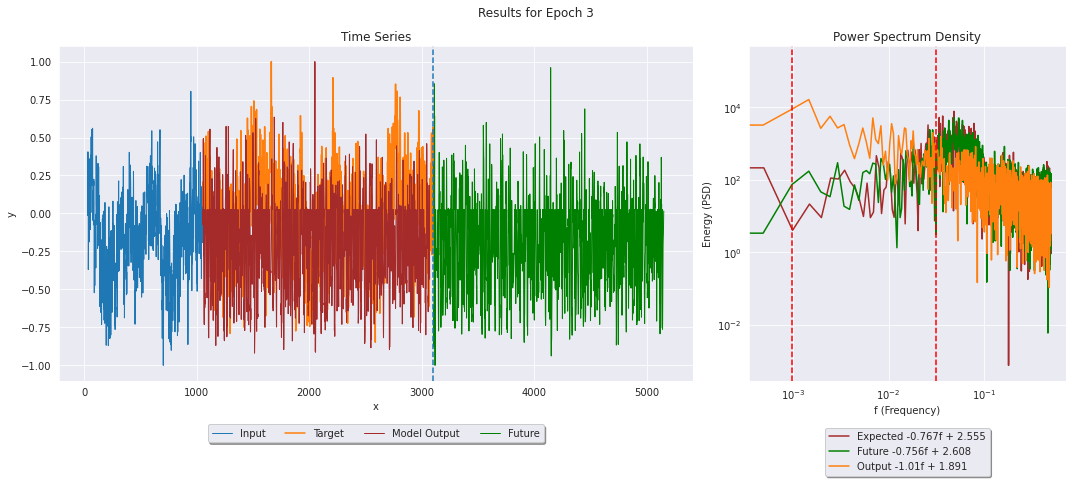

Epoch: 3, Train Loss: 0.35214, Validation Loss: 0.33773, Time 12.825 s


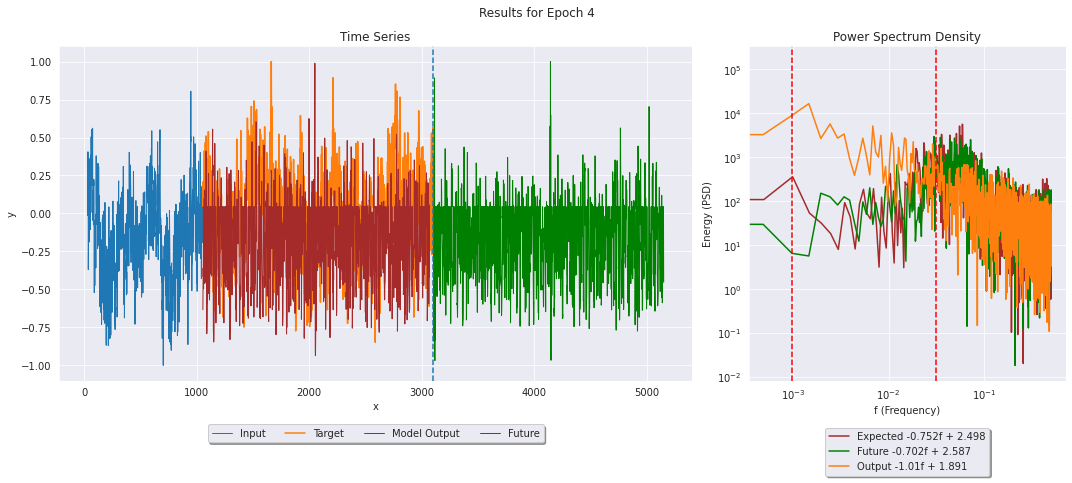

Epoch: 4, Train Loss: 0.41469, Validation Loss: 0.40729, Time 8.391 s


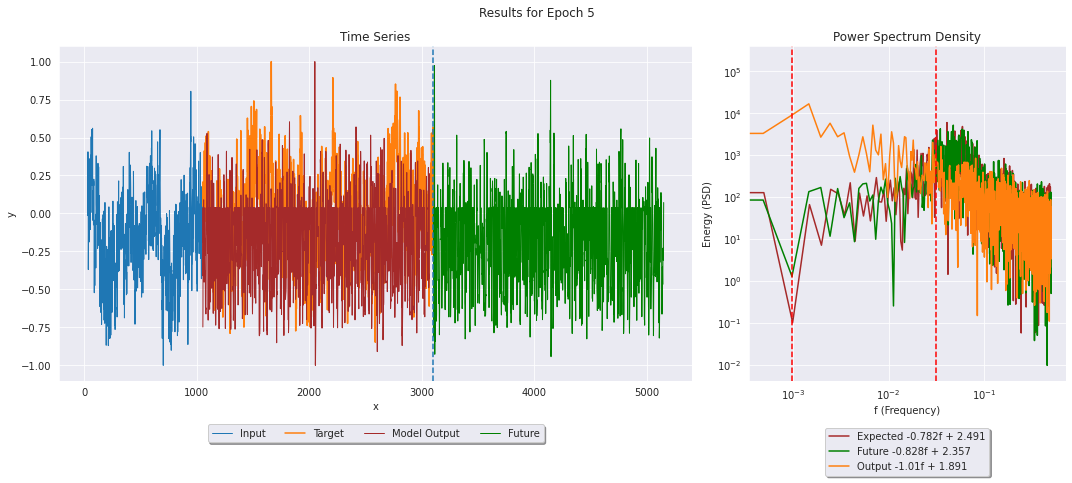

Epoch: 5, Train Loss: 0.3741, Validation Loss: 0.35512, Time 8.529 s


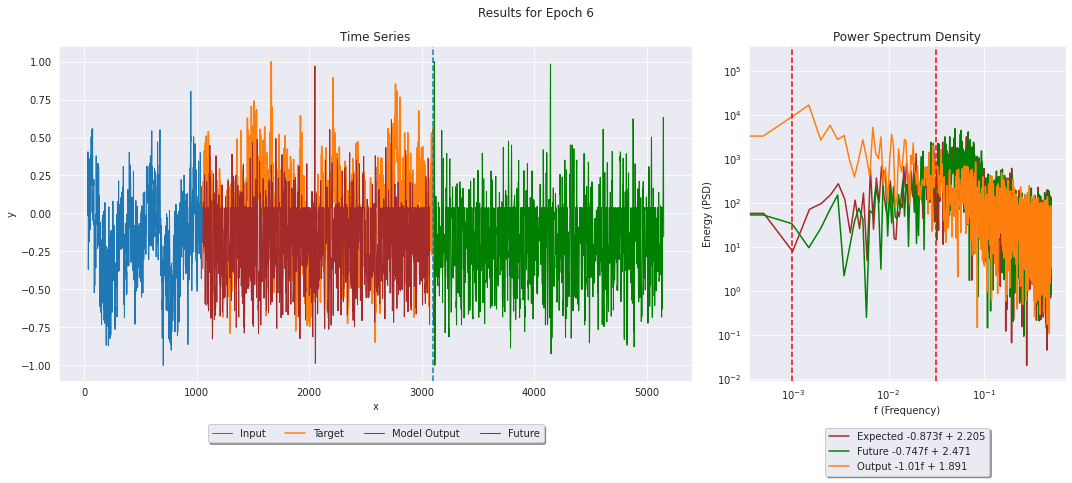

Epoch: 6, Train Loss: 0.32059, Validation Loss: 0.35738, Time 8.263 s


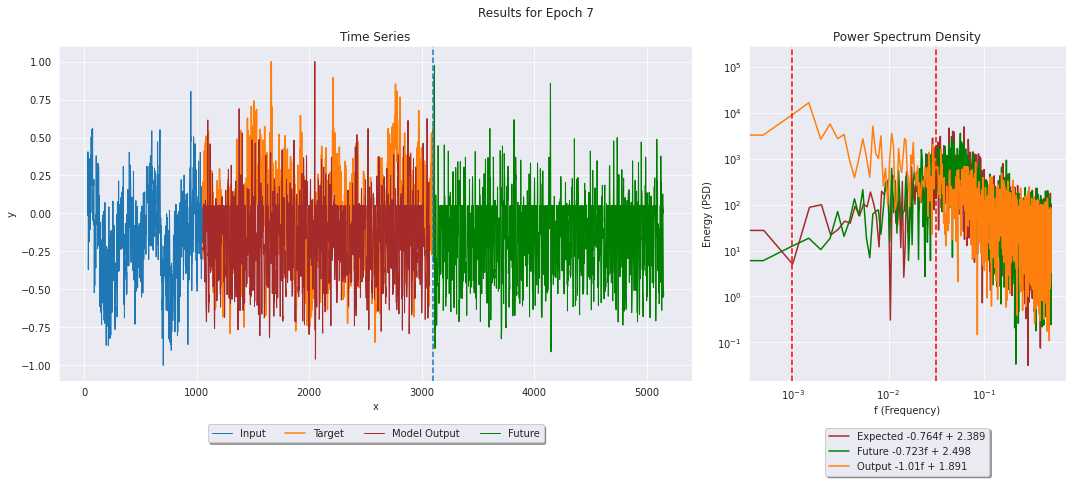

Epoch: 7, Train Loss: 0.36401, Validation Loss: 0.39054, Time 8.282 s


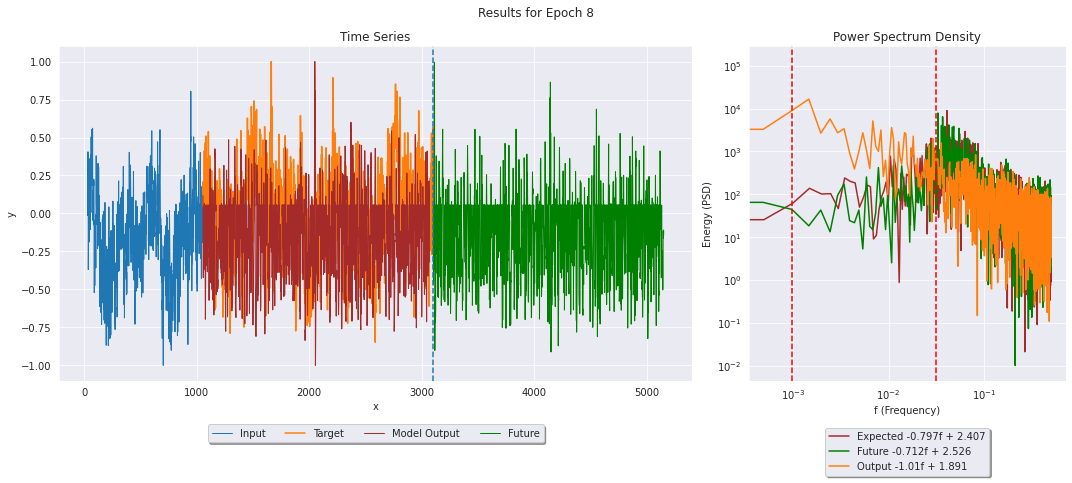

Epoch: 8, Train Loss: 0.39077, Validation Loss: 0.34762, Time 8.475 s


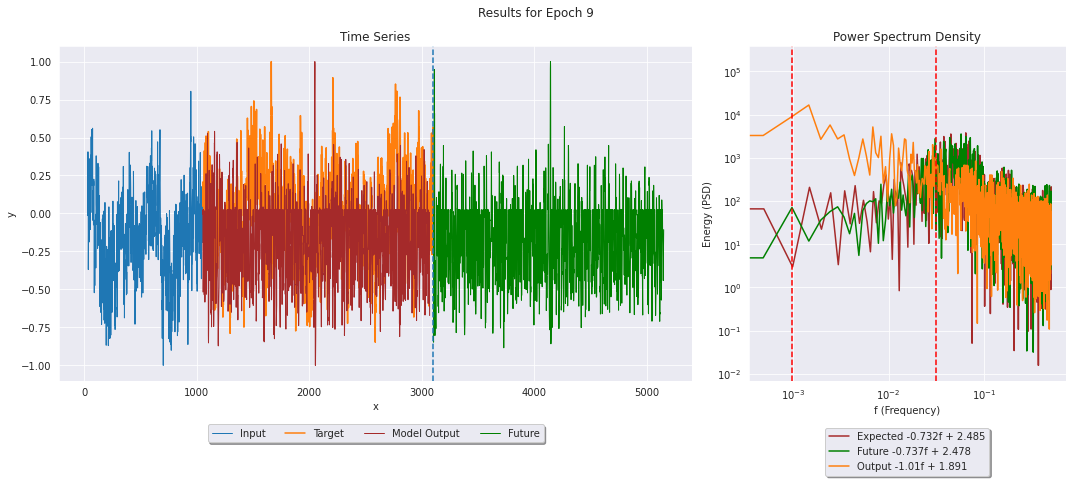

Epoch: 9, Train Loss: 0.33967, Validation Loss: 0.35789, Time 8.755 s


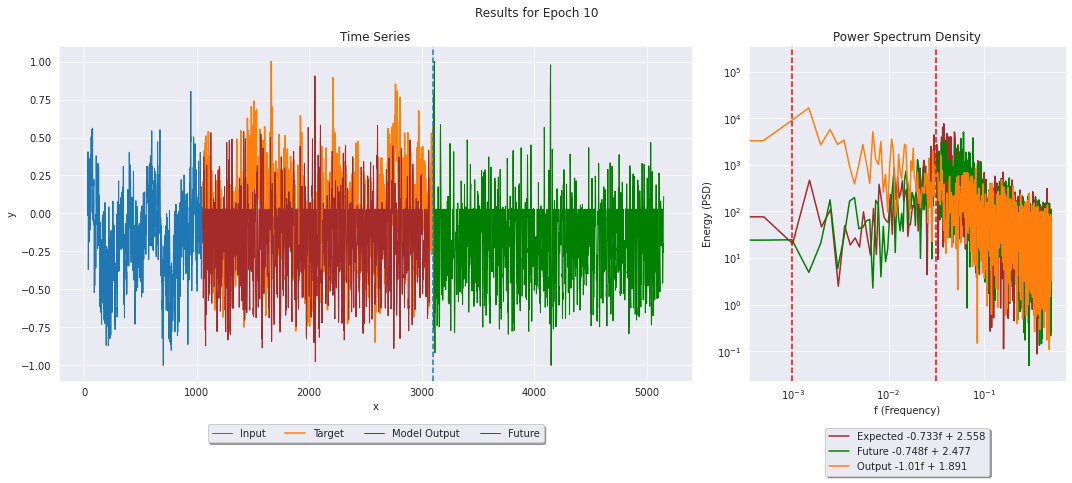

Epoch: 10, Train Loss: 0.31393, Validation Loss: 0.39073, Time 9.35 s


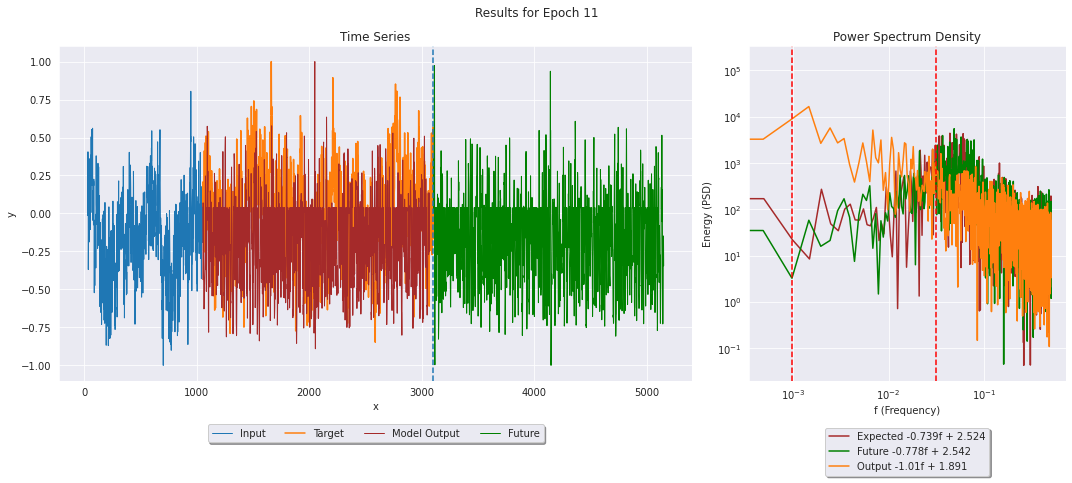

Epoch: 11, Train Loss: 0.30366, Validation Loss: 0.39617, Time 13.874 s


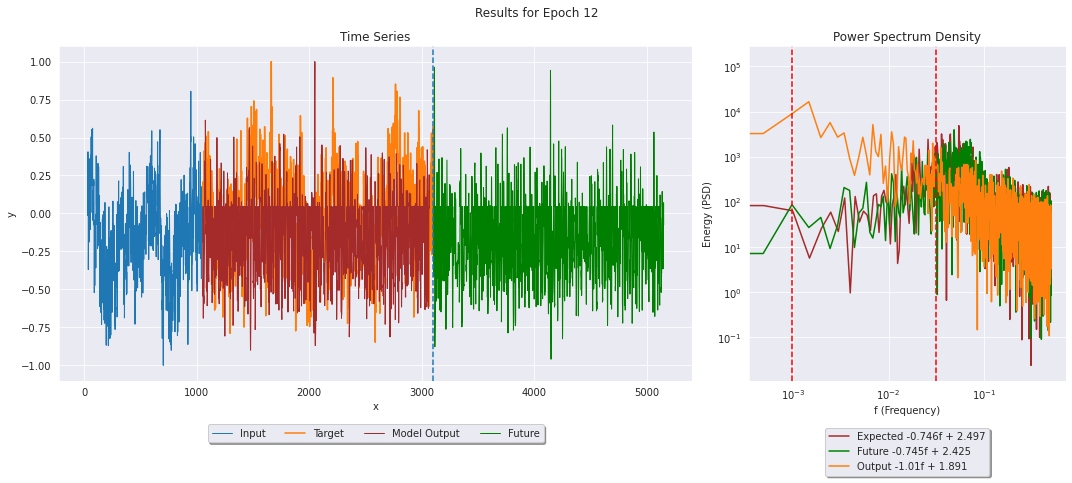

Epoch: 12, Train Loss: 0.3586, Validation Loss: 0.39776, Time 10.399 s


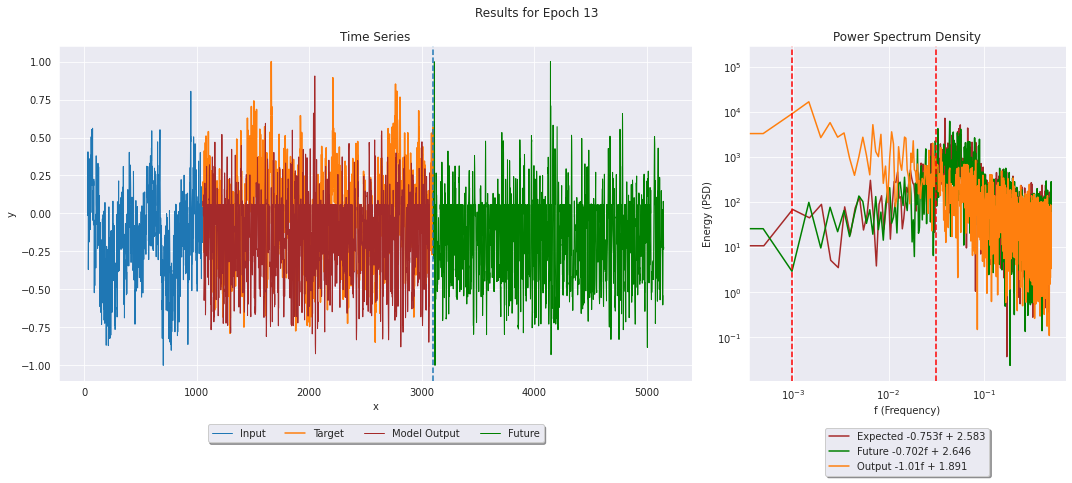

Epoch: 13, Train Loss: 0.38344, Validation Loss: 0.39398, Time 2.451 s


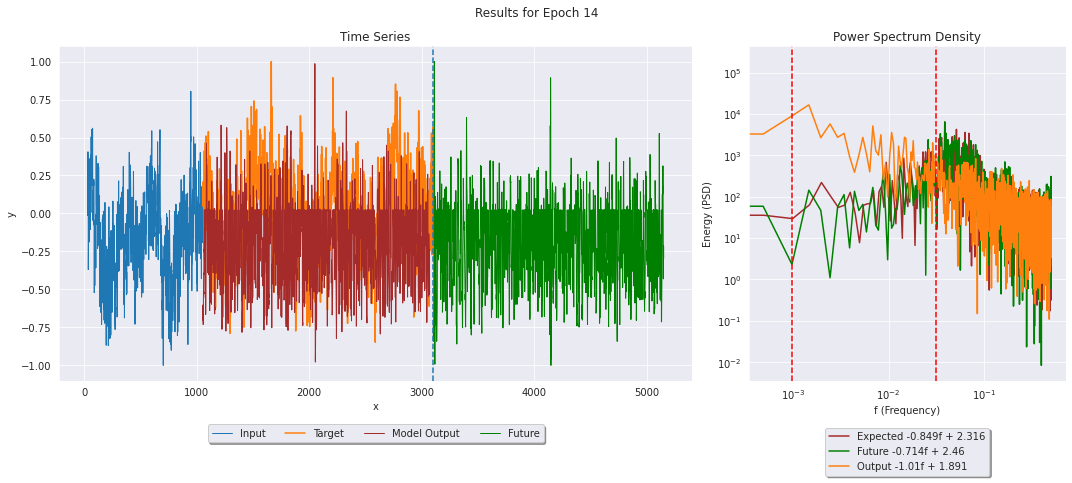

Epoch: 14, Train Loss: 0.3692, Validation Loss: 0.36679, Time 7.9 s


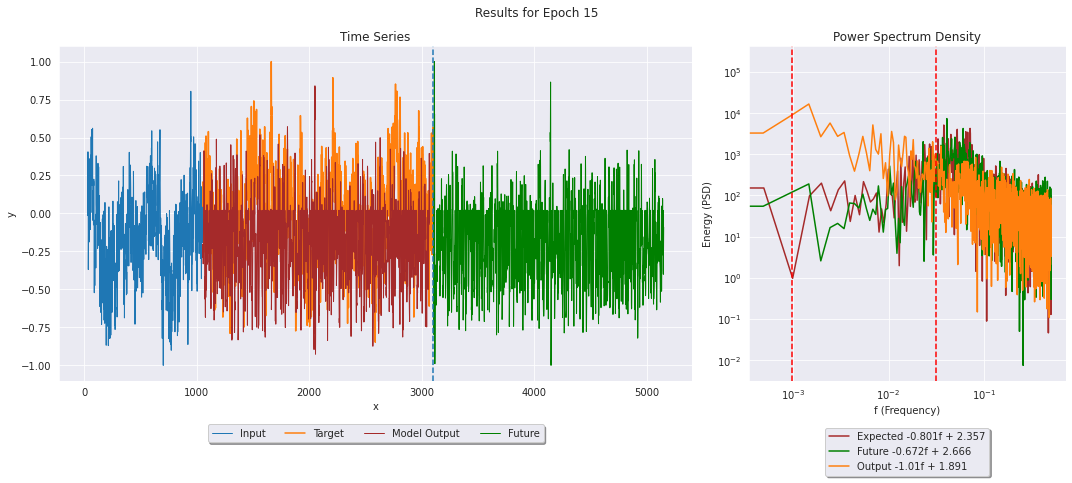

Epoch: 15, Train Loss: 0.33699, Validation Loss: 0.37387, Time 8.01 s


array(0.373865, dtype=float32)

In [ ]:
n_cut         = 2
title         = 'CNN'
epochs        = 15
low_freq_cut  = 0
high_freq_cut = 0

model = CNN(n_layers=3, 
                 activations=['sigmoid','tanh','sigmoid','tanh','sigmoid','sigmoid'],
                 dropouts=[0.25854,0.07107,0.128206,0.099857,0,0], 
                 #isGNI=True,
                 in_channels =[3,7,3,7,5],
                 kernel_size =[5,7,3,5,7,1,3,3],
                 stride      =[1,1,1,1,1,1,1,1],
                 isGNI=True
            )

optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
l = DBeta(n_cut,
          low_freq_cut=low_freq_cut,
          high_freq_cut=high_freq_cut)
training_loop(epochs,
              model, l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              optimiser = 'LBFGS',
              future=len(trainY[0]),
              n_cut=n_cut,
              lr = 0.366167,
              plot_results_during_traing = True,
              save_results               = True,
              verbose                    = True,
              file_name=f'RESULTS_{title}_ncut{n_cut}_.plk')
              

### CNN - Optuna

In [ ]:
#day = datetime.date.today()
def objective(trial):
    title         = 'CNN' 
    epochs        = 15
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 128
    neuron_max = 1024

    drop_max = 0.9
    drop_min = 0.0


    n_layers      = trial.suggest_int('n_layers', 1, 5)
    n_cut         = trial.suggest_int('n_cut', 1, 5)

    
    activations1    = trial.suggest_categorical('activations1',["sigmoid", "relu", "tanh","const"])
    activations2    = trial.suggest_categorical('activations2',["sigmoid", "relu", "tanh","const"])
    activations3    = trial.suggest_categorical('activations3',["sigmoid", "relu", "tanh","const"])
    activations4    = trial.suggest_categorical('activations4',["sigmoid", "relu", "tanh","const"])
    activations5    = trial.suggest_categorical('activations5',["sigmoid", "relu", "tanh","const"])
    
    dropout1       = trial.suggest_float('dropout1', drop_min, drop_max)
    dropout2       = trial.suggest_float('dropout2', drop_min, drop_max)
    dropout3       = trial.suggest_float('dropout3', drop_min, drop_max)
    dropout4       = trial.suggest_float('dropout4', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)

    kernel_size1    = 2*trial.suggest_int('kernel_size1', 1, 3) +1
    kernel_size2    = 2*trial.suggest_int('kernel_size2', 1, 3) +1
    kernel_size3    = 2*trial.suggest_int('kernel_size3', 1, 3) +1
    kernel_size4    = 2*trial.suggest_int('kernel_size4', 1, 3) +1
    kernel_size5    = 2*trial.suggest_int('kernel_size5', 1, 3) +1

    in_channels1    = 2*(kernel_size1 + trial.suggest_int('in_channels1', 1, 3))+1
    in_channels2    = 2*(kernel_size2 + trial.suggest_int('in_channels2', 1, 3))+1
    in_channels3    = 2*(kernel_size3 + trial.suggest_int('in_channels3', 1, 3))+1
    in_channels4    = 2*(kernel_size4 + trial.suggest_int('in_channels4', 1, 3))+1
    in_channels5    = 2*(kernel_size5 + trial.suggest_int('in_channels5', 1, 3))+1

    lr              = trial.suggest_float('lr', 1e-4, 5e-1)
    optimiser       = trial.suggest_categorical('optimiser',['LBFGS','SGD','Adam','const'])

    model = CNN(n_layers=n_layers, 
                 activations     = [activations1,activations2,activations3,activations4,activations5],
                 dropouts        = [dropout1,dropout2,dropout3,dropout4,dropout5],
                 in_channels     = [in_channels1,in_channels2,in_channels3,in_channels4,in_channels5],
                 kernel_size     = [kernel_size1,kernel_size2,kernel_size3,kernel_size4,kernel_size5],
                 stride          = [1,1,1,1,1,1,1,1,1])

    l = DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = training_loop(epochs,
                         model, 
                         l, 
                         trainX.float(), trainY.float(), 
                         trainX_test.float(), trainY_test.float(),
                         optimiser = optimiser[0],
                         future=len(trainY[0]),
                         n_cut=n_cut,
                         lr = lr,
                         plot_results_during_traing=False,
                         save_results = False,
                         verbose = False,
                         file_name=f'out_{title}_t{trial.number}_train{train_size}_test{test_size}_beta{beta}_ncut{n_cut}.plk')
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10,n_jobs=1)

print('Number of finished trials:', len(study.trials))
print(f'Best trial:',study.best_trial.params)

In [ ]:
import optuna
import functions as fn
import torch
import sys
import report as rp
import warnings
warnings.filterwarnings('ignore')

#LOAD DATA

beta = 2
win_in = 1024
win_ou = 2048
n_series = 2**8
data1 = torch.load(f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
trainX, trainY, trainX_test,trainY_test = data1[beta][0],data1[beta][1],data1[beta][2],data1[beta][3]


#EXPERIMENT

#n_cut = 1
low_freq_cut= 0
high_freq_cut= 0
train_size = len(trainX[0])
test_size =  len(trainY[0])

def objective(trial):
    data1 = torch.load(f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
    trainX, trainY, trainX_test,trainY_test = data1[beta][0],data1[beta][1],data1[beta][2],data1[beta][3]
    train_size = len(trainX[0])
    test_size =  len(trainY[0])
    title         = 'CNN' 
    epochs        = 10
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 32
    neuron_max = 1024

    drop_max = 0.3
    drop_min = 0.0

    n_layers      = trial.suggest_int('n_layers', 1, 5)
    n_cut         = trial.suggest_int('n_cut', 1, 5)
    
    activations1    = trial.suggest_categorical('activations1',["sigmoid", "relu", "tanh","const"])
    activations2    = trial.suggest_categorical('activations2',["sigmoid", "relu", "tanh","const"])
    activations3    = trial.suggest_categorical('activations3',["sigmoid", "relu", "tanh","const"])
    activations4    = trial.suggest_categorical('activations4',["sigmoid", "relu", "tanh","const"])
    activations5    = trial.suggest_categorical('activations5',["sigmoid", "relu", "tanh","const"])
    activations6    = trial.suggest_categorical('activations6',["sigmoid", "relu", "tanh","const"])
    activations7    = trial.suggest_categorical('activations7',["sigmoid", "relu", "tanh","const"])
    activations8    = trial.suggest_categorical('activations8',["sigmoid", "relu", "tanh","const"])
    activations9    = trial.suggest_categorical('activations9',["sigmoid", "relu", "tanh","const"])
    activations0    = trial.suggest_categorical('activations0',["sigmoid", "relu", "tanh","const"])
    
    dropout1       = trial.suggest_float('dropout1', drop_min, drop_max)
    dropout2       = trial.suggest_float('dropout2', drop_min, drop_max)
    dropout3       = trial.suggest_float('dropout3', drop_min, drop_max)
    dropout4       = trial.suggest_float('dropout4', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)
    dropout6       = trial.suggest_float('dropout6', drop_min, drop_max)
    dropout7       = trial.suggest_float('dropout7', drop_min, drop_max)
    dropout8       = trial.suggest_float('dropout8', drop_min, drop_max)
    dropout9       = trial.suggest_float('dropout9', drop_min, drop_max)
    dropout0       = trial.suggest_float('dropout0', drop_min, drop_max)

    kernel_size1    = 2*trial.suggest_int('kernel_size1', 1, 3) +1
    kernel_size2    = 2*trial.suggest_int('kernel_size2', 1, 3) +1
    kernel_size3    = 2*trial.suggest_int('kernel_size3', 1, 3) +1
    kernel_size4    = 2*trial.suggest_int('kernel_size4', 1, 3) +1
    kernel_size5    = 2*trial.suggest_int('kernel_size5', 1, 3) +1
    kernel_size6    = 2*trial.suggest_int('kernel_size6', 1, 3) +1
    kernel_size7    = 2*trial.suggest_int('kernel_size7', 1, 3) +1
    kernel_size8    = 2*trial.suggest_int('kernel_size8', 1, 3) +1
    kernel_size9    = 2*trial.suggest_int('kernel_size9', 1, 3) +1
    kernel_size0    = 2*trial.suggest_int('kernel_size0', 1, 3) +1

    in_channels1    = 2*(kernel_size1 + trial.suggest_int('in_channels1', 1, 3))+1
    in_channels2    = 2*(kernel_size2 + trial.suggest_int('in_channels2', 1, 3))+1
    in_channels3    = 2*(kernel_size3 + trial.suggest_int('in_channels3', 1, 3))+1
    in_channels4    = 2*(kernel_size4 + trial.suggest_int('in_channels4', 1, 3))+1
    in_channels5    = 2*(kernel_size5 + trial.suggest_int('in_channels5', 1, 3))+1
    in_channels6    = 2*(kernel_size5 + trial.suggest_int('in_channels6', 1, 3))+1
    in_channels7    = 2*(kernel_size5 + trial.suggest_int('in_channels7', 1, 3))+1
    in_channels8    = 2*(kernel_size5 + trial.suggest_int('in_channels8', 1, 3))+1
    in_channels9    = 2*(kernel_size5 + trial.suggest_int('in_channels9', 1, 3))+1
    in_channels0    = 2*(kernel_size5 + trial.suggest_int('in_channels0', 1, 3))+1

    lr              = trial.suggest_float('lr', 1e-4, 5e-1)
    optimiser       = trial.suggest_categorical('optimiser',['LBFGS','SGD','Adam'])

    model = fn.CNN(n_layers=n_layers, 
                 activations     = [activations1,activations2,activations3,activations4,activations5,activations6,activations7,activations8,activations9,activations0],
                 dropouts        = [dropout1,dropout2,dropout3,dropout4,dropout5,dropout6,dropout7,dropout8,dropout9,dropout0],
                 in_channels     = [in_channels1,in_channels2,in_channels3,in_channels4,in_channels5,in_channels6,in_channels7,in_channels8,in_channels9,in_channels0],
                 kernel_size     = [kernel_size1,kernel_size2,kernel_size3,kernel_size4,kernel_size5,kernel_size6,kernel_size7,kernel_size8,kernel_size9,kernel_size0],
                 stride          = [1,1,1,1,1,1,1,1,1])

    l = fn.DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = fn.training_loop(epochs,
                         model, 
                         l, 
                         trainX.float(), trainY.float(), 
                         trainX_test.float(), trainY_test.float(),
                         optimiser = optimiser,
                         future=len(trainY[0]),
                         n_cut=n_cut,
                         lr = lr,
                         plot_results_during_traing=False,
                         save_results = True,
                         verbose = False,
                         file_name=f'out_{title}_t{trial.number}_train{train_size}_test{test_size}_beta{beta}_ncut{n_cut}.plk')
    return loss

# if __name__ == "__main__":
# 	win_in = int(sys.argv[1])
# 	win_ou = int(sys.argv[2])
# 	beta   = int(sys.argv[3])
# 	study = optuna.create_study(direction='minimize')
# 	study.optimize(objective, n_trials=127,n_jobs=2)

	print('Number of finished trials:', len(study.trials))
	print(f'Best trial:',study.best_trial.params) 
	rp.report(f'CNN_{win_in}_{win_ou}_{beta}')

ModuleNotFoundError: ignored

In [ ]:
!pip install --upgrade pandas==1.5.2

# import pickle

# with open("dump_from_v1.3.4.pickle", "rb") as f: 
#     df = pickle.load(f) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
pd.__version__

'1.3.5'

In [ ]:
epoch=0
df = pd.read_pickle('out_RNN_t52_train1024_test2048_beta1_ncut1.plk')
plot_results(x = df[~df.trainX.isnull()].trainX,
             y = df[~df.trainY.isnull()].trainY,
             z = df[~df[df.columns[epoch+2]].isnull()][df.columns[epoch+2]],
             w = df[~df[df.columns[epoch+3]].isnull()][df.columns[epoch+3]])


AttributeError: ignored

Refazendo o plot da função de treino, pois a do exemplo é muito ruim. Excluimos os 32 iniciais devido a arquitetura da rede, este é o tempo necessário para preencher a memória da primeira camada. 

In [ ]:
df

trainX    trainY  input_GNI  loss_train  loss_valid  time      out1  \
0    -0.321402  0.546242   0.575745         NaN         NaN   NaN  0.229290   
1    -0.313167  0.616376   0.929755         NaN         NaN   NaN  0.103090   
2    -0.238514  0.658087   0.969923         NaN         NaN   NaN  0.311933   
3    -0.267650  0.757543   0.255346         NaN         NaN   NaN -0.843553   
4    -0.297758  0.759828   0.937380         NaN         NaN   NaN -0.726584   
...        ...       ...        ...         ...         ...   ...       ...   
2043       NaN -0.330675   0.492419         NaN         NaN   NaN       NaN   
2044       NaN -0.309484   0.868225         NaN         NaN   NaN       NaN   
2045       NaN -0.295489   0.367035         NaN         NaN   NaN       NaN   
2046       NaN -0.289877   0.067292         NaN         NaN   NaN       NaN   
2047       NaN -0.302251   0.811561         NaN         NaN   NaN       NaN   

          fut1  (0, loss_train)  (0, loss_valid)  ...      out2      fut2  \
0     0.360062              NaN              NaN  ...  0.174631  0.419445   
1    -0.277947              NaN              NaN  ...  0.175451 -0.232381   
2     0.246911              NaN              NaN  ...  0.290461  0.305295   
3     0.071345              NaN              NaN  ... -0.823461  0.125434   
4    -0.139374              NaN              NaN  ... -0.856215 -0.089708   
...        ...              ...              ...  ...       ...       ...   
2043  0.345788              NaN              NaN  ...       NaN  0.399677   
2044  0.416719              NaN              NaN  ...       NaN  0.471683   
2045  0.206983              NaN              NaN  ...       NaN  0.259397   
2046  0.409281              NaN              NaN  ...       NaN  0.464895   
2047  0.310547              NaN              NaN  ...       NaN  0.364046   

      (1, loss_train)  (1, loss_valid)  (1, time)      out3      fut3  \
0                 NaN              NaN   0.318581  0.252713  0.419085   
1                 NaN              NaN   0.318581  0.219118 -0.277808   
2                 NaN              NaN   0.318581  0.160458  0.298847   
3                 NaN              NaN   0.318581 -0.877862  0.111094   
4                 NaN              NaN   0.318581 -0.906692 -0.112962   
...               ...              ...        ...       ...       ...   
2043              NaN              NaN   0.318581       NaN  0.406556   
2044              NaN              NaN   0.318581       NaN  0.483023   
2045              NaN              NaN   0.318581       NaN  0.253532   
2046              NaN              NaN   0.318581       NaN  0.474061   
2047              NaN              NaN   0.318581       NaN  0.366549   

      (2, loss_train)  (2, loss_valid)  (2, time)  
0                 NaN              NaN   0.311125  
1                 NaN              NaN   0.311125  
2                 NaN              NaN   0.311125  
3                 NaN              NaN   0.311125  
4                 NaN              NaN   0.311125  
...               ...              ...        ...  
2043              NaN              NaN   0.311125  
2044              NaN              NaN   0.311125  
2045              NaN              NaN   0.311125  
2046              NaN              NaN   0.311125  
2047              NaN              NaN   0.311125  

[2048 rows x 21 columns]

In [ ]:
df

trainX    trainY  input_GNI  loss_train  loss_valid  time      out1  \
0    -0.321402  0.546242   0.456656         NaN         NaN   NaN  0.438227   
1    -0.313167  0.616376   0.190289         NaN         NaN   NaN  0.027246   
2    -0.238514  0.658087   0.779875         NaN         NaN   NaN  0.252026   
3    -0.267650  0.757543   0.689642         NaN         NaN   NaN -0.397040   
4    -0.297758  0.759828   0.553142         NaN         NaN   NaN  0.008849   
...        ...       ...        ...         ...         ...   ...       ...   
2043       NaN -0.330675   0.250681         NaN         NaN   NaN       NaN   
2044       NaN -0.309484   0.288110         NaN         NaN   NaN       NaN   
2045       NaN -0.295489   0.608949         NaN         NaN   NaN       NaN   
2046       NaN -0.289877   0.288806         NaN         NaN   NaN       NaN   
2047       NaN -0.302251   0.351279         NaN         NaN   NaN       NaN   

          fut1  (loss_train, 0)  (loss_valid, 0)  ...      out4      fut4  \
0     0.426940         3.712598         4.209513  ...  0.344151  0.402676   
1    -0.246792         3.712598         4.209513  ...  0.235487 -0.229628   
2    -0.253927         3.712598         4.209513  ...  0.440279 -0.250417   
3    -0.301500         3.712598         4.209513  ... -0.515789 -0.283143   
4     0.115135         3.712598         4.209513  ...  0.113252  0.128293   
...        ...              ...              ...  ...       ...       ...   
2043  0.164926         3.712598         4.209513  ...       NaN  0.160693   
2044  0.306311         3.712598         4.209513  ...       NaN  0.301209   
2045  0.072372         3.712598         4.209513  ...       NaN  0.072955   
2046 -0.342992         3.712598         4.209513  ...       NaN -0.327120   
2047  0.536063         3.712598         4.209513  ...       NaN  0.528440   

      (loss_train, 3)  (loss_valid, 3)  (time, 3)      out5      fut5  \
0            3.694574         4.128592   0.032632  0.323413  0.415597   
1            3.694574         4.128592   0.032632  0.185223 -0.248952   
2            3.694574         4.128592   0.032632  0.341508 -0.264977   
3            3.694574         4.128592   0.032632 -0.457947 -0.301277   
4            3.694574         4.128592   0.032632  0.114566  0.125427   
...               ...              ...        ...       ...       ...   
2043         3.694574         4.128592   0.032632       NaN  0.159561   
2044         3.694574         4.128592   0.032632       NaN  0.300411   
2045         3.694574         4.128592   0.032632       NaN  0.070590   
2046         3.694574         4.128592   0.032632       NaN -0.349583   
2047         3.694574         4.128592   0.032632       NaN  0.532259   

      (loss_train, 4)  (loss_valid, 4)  (time, 4)  
0            3.735813         4.055337   0.032809  
1            3.735813         4.055337   0.032809  
2            3.735813         4.055337   0.032809  
3            3.735813         4.055337   0.032809  
4            3.735813         4.055337   0.032809  
...               ...              ...        ...  
2043         3.735813         4.055337   0.032809  
2044         3.735813         4.055337   0.032809  
2045         3.735813         4.055337   0.032809  
2046         3.735813         4.055337   0.032809  
2047         3.735813         4.055337   0.032809  

[2048 rows x 31 columns]

#Pos Processing

Now we have allready run the code in a HPC. Lets now analyse the data

# Models Results

In [301]:
#model.eval()

# #model = torch.load('saved_models/MLP_0.pt')
# print(model.eval())
#os.setpath('saved_models')
model = torch.load('saved_models/MLP_2.pth')
# print(model.eval())


In [360]:
#Plot the results Betas distributions
l = DBeta()
out = model(trainX_test,future_preds=2048+2048)
#out = out.detach().numpy()
a = (l.beta(out[:,1024:2048])).detach().numpy()[:,0]
a
out[:,1024:2048].shape

torch.Size([256, 1024])

In [370]:
#Plot the results Betas distributions
l = DBeta()
x = torch.tensor(np.resize(trainX[0],(1,1024)))
l.beta_mono(x).detach().numpy().item()

float

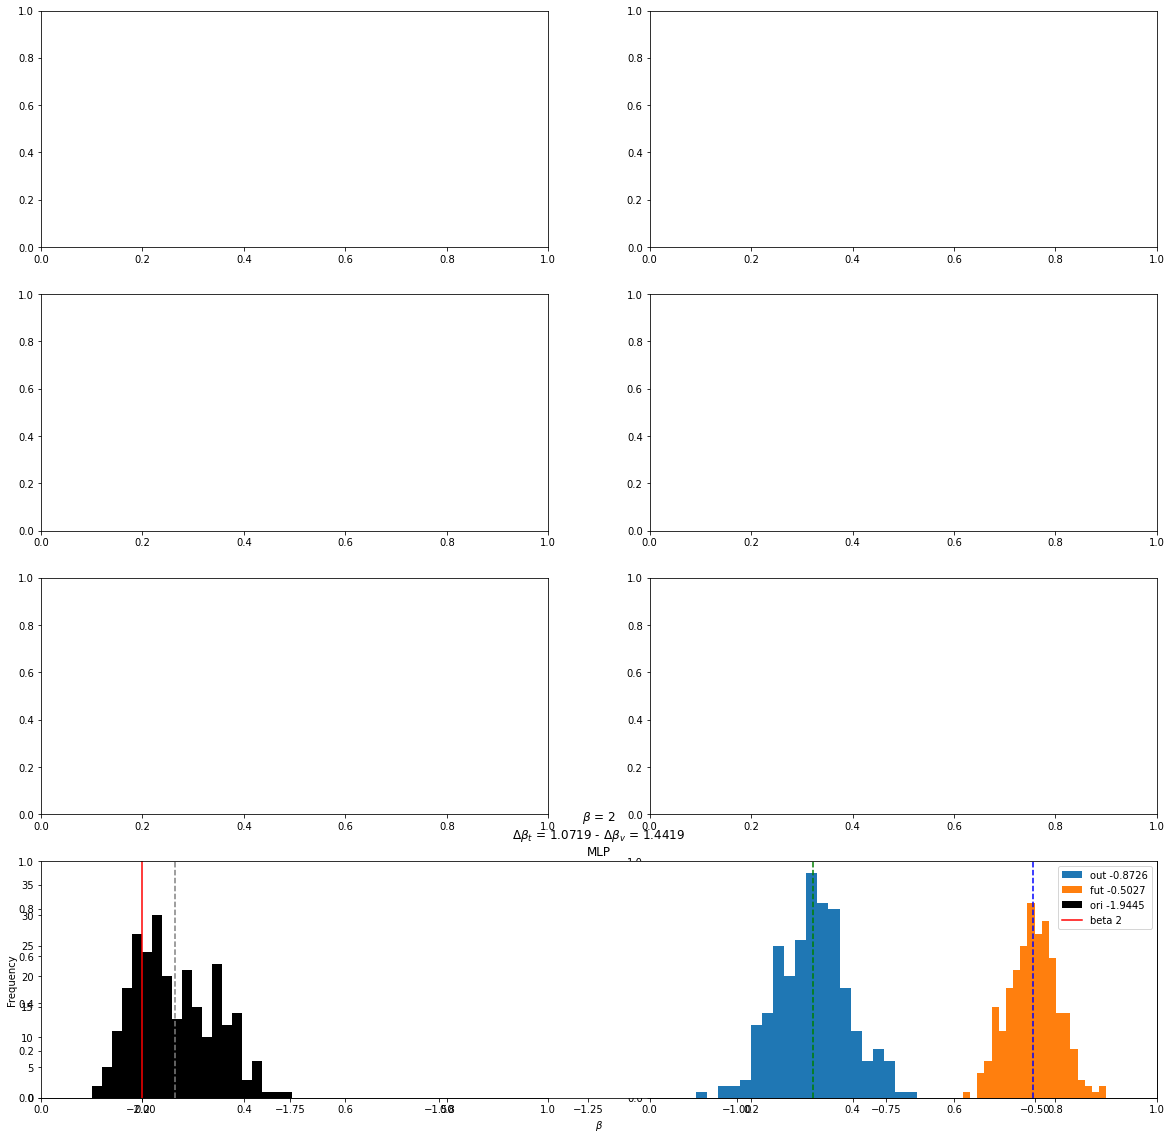

In [104]:
# model = torch.load('saved_models/MLP_2.pth')
# future_preds = 2048+2048
# title = 'MLP'
# beta = 2
# ###
# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,20))
# def plot_dist(model,future_preds=2048+2048,title='MLP',beta=2):
#     model = torch.load('saved_models/MLP_2.pth')
#     out = model(trainX_test,future_preds=future_preds).detach().numpy()
#     ori_betas,out_betas ,fut_betas = [],[],[]
#     for i in range(len(trainY_test)): ori_betas.append(plot_psd(norm4(trainY_test[i]),is_subplot=True)[2])
#     for i in range(len(out)):
#         out_betas.append(plot_psd(norm4(out[i][1024:2048]),is_subplot=True)[2])
#         fut_betas.append(plot_psd(norm4(out[i][1024+2048:]),is_subplot=True)[2])
    
#     beta_t, beta_v,  beta_o= round(np.mean(out_betas),4), round(np.mean(fut_betas),4),round(np.mean(ori_betas),4)
#     delta_beta_t = round(abs(np.mean(ori_betas)-np.mean(out_betas)),4)
#     delta_beta_v = round(abs(np.mean(ori_betas)-np.mean(fut_betas)),4)
    
#     ax7 = fig.add_subplot(gs[3, :])
#     ax7.set_title(f'$\\beta$ = {beta}\n$\\Delta \\beta_t$ = {delta_beta_t} - $\\Delta \\beta_v$ = {delta_beta_v}\n{title}')
#     ax7.hist(out_betas,bins = 20,label = f'out {beta_t}')
#     ax7.hist(fut_betas,bins = 20,label = f'fut {beta_v}')
#     ax7.hist(ori_betas,bins = 20,label = f'ori {beta_o}' ,color='black')
#     ax7.axvline(x=-beta,color='red',label = f'beta {beta}')
#     ax7.axvline(x=beta_t,color='green',linestyle = '--')
#     ax7.axvline(x=beta_v,color='blue' ,linestyle = '--')
#     ax7.axvline(x=beta_o,color='gray',linestyle = '--')
#     ax7.set_ylabel('Frequency')
#     ax7.set_xlabel('$\\beta$')
#     ax7.legend()
# plot_dist(model,future_preds=2048+2048,title='MLP',beta=2)    
# #plt.show()


NameError: name 'model' is not defined

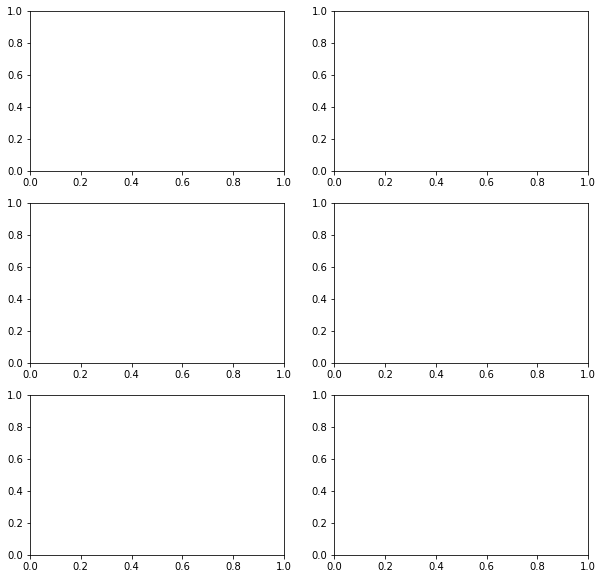

In [20]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

out = model(trainX_test,future_preds=future_preds).detach().numpy()
ori_betas,out_betas ,fut_betas = [],[],[]
for i in range(len(trainY_test)): ori_betas.append(plot_psd(norm4(trainY_test[i]),is_subplot=True)[2])
for i in range(len(out)):
    out_betas.append(plot_psd(norm4(out[i][1024:2048]),is_subplot=True)[2])
    fut_betas.append(plot_psd(norm4(out[i][1024+2048:]),is_subplot=True)[2])

y_test = trainY_test[0].detach().numpy()
#for j in range(len(y)): y[j] = norm4(y[j])
out_data = norm4(out[0][1024:2048])
fut_data = norm4(out[0][1024+2048:])
#out = out.reshape(-1,1)
log_y_test   = plot_psd(y_test,is_subplot=True)
log_out_data = plot_psd(out_data,is_subplot=True)
log_fut_data = plot_psd(fut_data,is_subplot=True)

plot_results2(y_test,
              out_data,
              fut_data,
              log_y_test,
              log_out_data,
              log_fut_data,
              ori_betas,
              out_betas,
              fut_betas)
    #plot_dist(model,future_preds=2048+2048,title='MLP',beta=2) 
#plot_results2(y_test,out_data,fut_data,log_y_test,log_out_data,aw,ori_betas,out_betas,fut_betas,size_x=10,size_y=10,model_title = None,title = None):    #  


In [134]:
set_path('RNN',0,'barauna',met='ASNGNI')

In [386]:
df = pd.read_pickle('out_MLP_train1024_test2048_beta2.plk')
df

trainX    trainY  input_GNI  ori_betas_x  ori_betas_y  loss_train  \
0    -0.411264  0.394927   0.246220    -1.914522    -1.847013    2.830548   
1    -0.396487  0.380476   0.119285    -1.959592    -2.001091    1.313177   
2    -0.397109  0.355544   0.047347    -1.777554    -1.840815    0.712946   
3    -0.365267  0.360730   0.306006    -1.987377    -2.032885    0.468439   
4    -0.369677  0.379671   0.897975    -1.980905    -1.994125    0.338847   
...        ...       ...        ...          ...          ...         ...   
2043       NaN -0.292711   0.800657          NaN          NaN         NaN   
2044       NaN -0.323292   0.846083          NaN          NaN         NaN   
2045       NaN -0.396733   0.518332          NaN          NaN         NaN   
2046       NaN -0.451748   0.521413          NaN          NaN         NaN   
2047       NaN -0.449340   0.942866          NaN          NaN         NaN   

      loss_valid      time      out1      fut1  ...  out_betas8  fut_betas8  \
0       2.836493  0.761977 -0.163819 -1.000000  ...   -1.421507   -0.837024   
1       1.315813  0.853628  0.125870  0.098536  ...   -1.372269   -0.841595   
2       0.713023  0.941159  0.102697  0.269848  ...   -1.464263   -0.832354   
3       0.453677  0.970131  0.056725  0.247517  ...   -1.495594   -0.878863   
4       0.337730  0.999711  0.115185  0.234093  ...   -1.466469   -0.886244   
...          ...       ...       ...       ...  ...         ...         ...   
2043         NaN       NaN       NaN  0.499612  ...         NaN         NaN   
2044         NaN       NaN       NaN -1.000000  ...         NaN         NaN   
2045         NaN       NaN       NaN  0.235753  ...         NaN         NaN   
2046         NaN       NaN       NaN  0.272455  ...         NaN         NaN   
2047         NaN       NaN       NaN  0.728251  ...         NaN         NaN   

          out9      fut9  out_betas9  fut_betas9     out10     fut10  \
0    -0.927504  0.968704   -1.505687   -0.859046 -0.951970  0.973177   
1    -0.815574  0.889446   -1.471630   -0.892227 -0.922922  0.897877   
2    -0.568863  0.481884   -1.590075   -0.878608 -0.755500  0.482737   
3    -0.216714 -0.093666   -1.530054   -0.831367 -0.209579 -0.124545   
4     0.586623 -1.000000   -1.476465   -0.930164  0.556058 -0.560835   
...        ...       ...         ...         ...       ...       ...   
2043       NaN  0.689267         NaN         NaN       NaN  0.775048   
2044       NaN  0.522541         NaN         NaN       NaN  0.508002   
2045       NaN  0.724967         NaN         NaN       NaN  0.666325   
2046       NaN  0.686213         NaN         NaN       NaN  0.732286   
2047       NaN  0.863686         NaN         NaN       NaN  0.884137   

      out_betas10  fut_betas10  
0       -1.588149    -0.931300  
1       -1.504318    -0.862717  
2       -1.559849    -0.920930  
3       -1.623953    -0.924328  
4       -1.539683    -0.908962  
...           ...          ...  
2043          NaN          NaN  
2044          NaN          NaN  
2045          NaN          NaN  
2046          NaN          NaN  
2047          NaN          NaN  

[2048 rows x 48 columns]

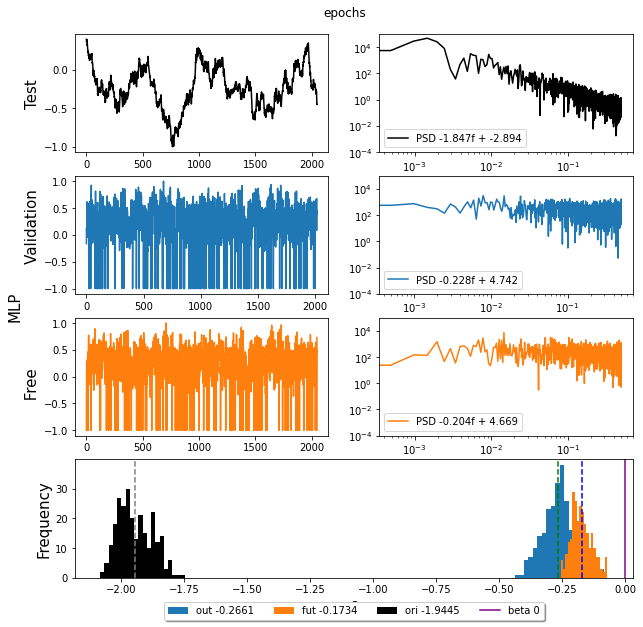

In [387]:
#Plotin Results from PLK
#fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
#df = pd.read_pickle('out_RNN_t1_train1024_test2048_beta0.plk')
df = pd.read_pickle('out_MLP_train1024_test2048_beta2.plk')
i=0
traini_data = df[~df.trainX.isnull()].trainX 
target_data = df[~df.trainY.isnull()].trainY
ori_betas   = df[~df.ori_betas_y.isnull()].ori_betas_y
expect_data = df[~df[f'out{i+1}'].isnull()][f'out{i+1}']
future_data = df[~df[f'fut{i+1}'].isnull()][f'fut{i+1}']
out_betas   = df[~df[f'out_betas{i+1}'].isnull()][f'out_betas{i+1}']
fut_betas   = df[~df[f'fut_betas{i+1}'].isnull()][f'fut_betas{i+1}']
psd_target_data = plot_psd(target_data,is_subplot=True)
psd_expect_data = plot_psd(expect_data,is_subplot=True)
psd_future_data = plot_psd(future_data,is_subplot=True)
plot_results2(target_data,expect_data,future_data,psd_target_data,psd_expect_data,psd_future_data,ori_betas,out_betas,fut_betas,model_title='MLP',sup_title='epochs',beta=0)

## Clean output

Claring error informations writed in the output files
https://stackoverflow.com/questions/4710067/how-to-delete-a-specific-line-in-a-file

# Referencias

[⚠️ Pytorch LSTMs for time-series data](https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7)

[Copyright 2019, Rafael Ballester-Ripoll Revision 8c81a1cb.](https://tntorch.readthedocs.io/en/latest/_modules/metrics.html)

https://blog.paperspace.com/pytorch-loss-functions/

[LSTM and LSTMCell ？ - PyTorch Forums](https://discuss.pytorch.org/t/lstm-and-lstmcell/7488/5)

[Optuna Reference](https://dl.acm.org/doi/10.1145/3292500.3330701)

[Has anyone implemented a optuna Hyperparameter optimization for a Pytorch LSTM?](https://stackoverflow.com/questions/72685216/has-anyone-implemented-a-optuna-hyperparameter-optimization-for-a-pytorch-lstm)

[10 Hyperparameters to keep an eye on for your LSTM model — and other tips](https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4)

[C 4.1 | 1D Convolution | CNN | Object Detection | Machine Learning | EvODN](https://www.youtube.com/watch?v=yd_j_zdLDWs)

# Email

https://towardsdatascience.com/automate-your-emails-with-python-for-2022-and-beyond-2284054d1012

In [ ]:
def report(CODE_NAME):
  # Creating the respective object along with the gmail login and port number
  from smtplib import SMTP

  email_mine  = "fismatcom.py1@gmail.com"
  password_mine  = "kuwfpepwzukdydwd"
  email1 = "luanorion@hotmail.com"
  #email2 = "luanorion1@gmail.com"
  CODE_NAME = str('TEST')

  smtp_port = SMTP("smtp.gmail.com", 587)# Establishing a connection to the SMTP server with Transport Layer Security (TLS) mode
  smtp_port.ehlo()# Informing the client to establish a secure connection, either to a TLS or SSL
  smtp_port.starttls()# Logging into your account
  smtp_port.login(email_mine , password_mine)

  # Creating the contents of the email
  subject = f"[Lab Report] {CODE_NAME} has Finish"
  body = f"\nCongratulations \n\n{CODE_NAME}\n\nHas finished"
  final_message = f"Subject: {subject} \n \n {body}"

  # Creating the list of email addresses
  address_list = [email1]#, email2]
  smtp_port.sendmail(email_mine, address_list, final_message)
  print("Email Sent")
  smtp_port.quit()

Email Sent


(221,
 b'2.0.0 closing connection f20-20020a1f1f14000000b003bc69ed4fa4sm630188vkf.36 - gsmtp')

In [ ]:
A new study created in RDB with name: jornal-study
Trial 0 failed because of the following error: TypeError("fft_fft(): argument 'input' (position 1) must be Tensor, not numpy.ndarray")
Traceback (most recent call last):
  File "/home/luan/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/data/luan/exp_ASNGNI_RNN0/RNN.py", line 74, in objective
    loss = fn.training_loop(epochs,
  File "/data/luan/exp_ASNGNI_RNN0/functions.py", line 1275, in training_loop
    df = create_dataframe(list(test_input_clone[0].detach().numpy().copy()),
  File "/data/luan/exp_ASNGNI_RNN0/functions.py", line 347, in create_dataframe
    for i_1 in range(len(data_val_x)): ori_betas_x.append(plot_psd(norm4(data_val_x[i_1]),is_subplot=True)[2])
  File "/data/luan/exp_ASNGNI_RNN0/functions.py", line 276, in plot_psd
    ft = torch.fft.fft(data)
TypeError: fft_fft(): argument 'input' (position 1) must be Tensor, not numpy.ndarray
(base) [luan@orion-d11 exp_ASNGNI_RNN0]$ 


Email Sent


(221,
 b'2.0.0 closing connection f125-20020a1f3883000000b003abc65990b0sm620364vka.7 - gsmtp')